# TITLE OF PROJECT

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time:
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:
* Video of 5-min Non-Technical Presentation:

## TABLE OF CONTENTS 

*Click to jump to matching Markdown Header.*<br><br>
 
- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
___

# INTRODUCTION

> Explain the point of your project and what question you are trying to answer with your modeling.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***



According to the Environmental Protection Agency (EPA), "greenhouse gas (GHG) emissions from transportation account for about 29 percent of total U.S. greenhouse gas emissions, making it the largest contributor of U.S. GHG emissions."[¹](https://www.epa.gov/transportation-air-pollution-and-climate-change/carbon-pollution-transportation) States like California and Washington are working towards mandating electric vehicles by 2035 and 2030 respectively, in an effort to phase out vehicles that use gasoline. Once the legislature catches up to the intentions, the demand for electric vehicles (EVs) will be at an all time high. The question is: how will the current charging infrastructure of these states support this many new EVs? 

To be able to achieve a fully electric future and keep up with the demand for chargers, the charging infrastructure has to be expanded. Therefore, Washington Department of Transportation is planning on spending $8 million on charging infrastructure projects between July 1st, 2021 and June 30, 2023[²](https://wsdot.wa.gov/business/innovative-partnerships/zero-emission-vehicle-infrastructure-partnerships). This is a great business opportunity for EV charging companies. By investing in Washington state, these companies can not only get government funding, but also be in a profitable position as the demand continues to increase over the coming years. 

In order to position these chargers strategically, it is vital to model and predict the demand for electric vehicles in each county. To achieve this task, we will be using the [electric vehicle title and registration activity data](https://data.wa.gov/Transportation/Electric-Vehicle-Title-and-Registration-Activity/rpr4-cgyd) provided by Washington state. Additionally, we will be looking at the [current charging infrastructure data](https://developer.nrel.gov/docs/transportation/alt-fuel-stations-v1/all/) provided by the National Renewable Energy Laboratory to find counties with the most potential for generating financial success. 

# OBTAIN

## Obtaining data from Washington State

### Accessing and Storing API Keys

In [274]:
#option to run API calls in the notebook
run_api_calls = False

In [275]:
#defining a function to open/load json files
import json

def get_keys(path):
    with open(path) as f:
        return json.load(f)

In [276]:
#storing api keys in variables
keys = get_keys("/Users/berke/.secret/socrata_api_project_5.json")

api_key_socrata = keys['api_key']
app_token_socrata = keys['app_token']
api_key_secret_socrata = keys['api_key_secret']

### API Requests and Pagination

In [277]:
import requests
import time
import pandas as pd

if run_api_calls == True:
    #Defining/initializing API request headers and parameters
    headers = {'X-App-Token': app_token_socrata, 'username': api_key_socrata,
               'password': api_key_secret_socrata}
    params = {'$limit': '50000', '$offset': None}
    offset = list(range(0, 500000, 50000))

    #Requesting data from API and parsing results to a dictionary
    dfs = {}
    for number in offset:
        params['$offset'] = str(number)
        r = requests.get(f'https://data.wa.gov/resource/rpr4-cgyd.json?', 
                         headers=headers, params=params)
        dfs[f'df_{number}']=pd.DataFrame.from_records(r.json())
        time.sleep(1)

### Parsing results to a final compressed .csv file

In [278]:
if run_api_calls == True:
    #saving all pages as one csv file
    import os
    path = './data'
    output_file = os.path.join(path,'title_transactions.csv.gz')

    for key, df in dfs.items():
        if key == 'df_0':
            df_final = dfs['df_0']
        else:
            df_final = pd.concat([df_final, df], axis=0)

    df_final.to_csv(output_file, index=False, compression='gzip')    

### Importing data

In [279]:
#importing the data back into the notebook
df=pd.read_csv('data/title_transactions.csv.gz', compression='gzip', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433172 entries, 0 to 433171
Data columns (total 30 columns):
 #   Column                                                   Non-Null Count   Dtype  
---  ------                                                   --------------   -----  
 0   electric_vehicle_type                                    433172 non-null  object 
 1   vin_1_10                                                 433172 non-null  object 
 2   model_year                                               433172 non-null  int64  
 3   make                                                     433172 non-null  object 
 4   model                                                    433172 non-null  object 
 5   new_or_used_vehicle                                      433172 non-null  object 
 6   sale_price                                               433172 non-null  float64
 7   transaction_date                                         433172 non-null  object 
 8   transaction_ty

# SCRUB

## Changing type of 'transaction_date' to datetime

Since we will be using the transaction_date column for the time series we are going to be creating, we need to change its type from object to datetime.

In [280]:
#display all columns
pd.set_option('max_columns', None)
df.head()

electric_vehicle_type    vin_1_10  model_year       make  \
0          Battery Electric Vehicle (BEV)  5YJXCBE2XG        2016      TESLA   
1          Battery Electric Vehicle (BEV)  5YJXCBE49H        2017      TESLA   
2          Battery Electric Vehicle (BEV)  5YJXCBE49H        2017      TESLA   
3  Plug-in Hybrid Electric Vehicle (PHEV)  1G1RA6S59H        2017  CHEVROLET   
4  Plug-in Hybrid Electric Vehicle (PHEV)  1G1RA6S59H        2017  CHEVROLET   

     model new_or_used_vehicle  sale_price         transaction_date  \
0  Model X                 New    102000.0  2017-01-31T00:00:00.000   
1  Model X                 New         0.0  2017-03-22T00:00:00.000   
2  Model X                 New    166250.0  2017-03-22T00:00:00.000   
3     Volt                 New         0.0  2017-03-24T00:00:00.000   
4     Volt                 New     32499.0  2017-03-24T00:00:00.000   

        transaction_type  transaction_year electric_vehicle_fee_paid  county  \
0         Original Title              2017            Not Applicable    King   
1  Original Registration              2017                        No    King   
2         Original Title              2017            Not Applicable    King   
3  Original Registration              2017                        No  Island   
4         Original Title              2017            Not Applicable  Island   

         city      zip  electric_range  base_msrp  \
0      MEDINA  98039.0             200          0   
1  SNOQUALMIE  98065.0             200          0   
2  SNOQUALMIE  98065.0             200          0   
3  OAK HARBOR  98277.0              53          0   
4  OAK HARBOR  98277.0              53          0   

                          non_clean_alternative_fuel     date_of_vehicle_sale  \
0  CANNOT DETERMINE ELIGIBILITY: Base MSRP has no...  2016-12-27T00:00:00.000   
1  TRANSACTION NOT ELIGIBLE: Non-sale, registrati...                      NaN   
2  CANNOT DETERMINE ELIGIBILITY: Base MSRP has no...  2017-03-03T00:00:00.000   
3  TRANSACTION NOT ELIGIBLE: Non-sale, registrati...                      NaN   
4  CANNOT DETERMINE ELIGIBILITY: Base MSRP has no...  2017-03-11T00:00:00.000   

  vehicle_primary_use state_of_residence  dol_vehicle_id  \
0           Passenger                 WA       348693390   
1           Passenger                 WA       329748177   
2           Passenger                 WA       329748177   
3           Passenger                 WA       242531271   
4           Passenger                 WA       242531271   

   legislative_district  \
0                  48.0   
1                   5.0   
2                   5.0   
3                  10.0   
4                  10.0   

  hb_2042_clean_alternative_fuel_vehicle_cafv_eligibility  \
0  TRANSACTION NOT ELIGIBLE: Sale before August 2...        
1  TRANSACTION NOT ELIGIBLE: Non-sale, registrati...        
2  TRANSACTION NOT ELIGIBLE: Sale before August 2...        
3  TRANSACTION NOT ELIGIBLE: Non-sale, registrati...        
4  TRANSACTION NOT ELIGIBLE: Sale before August 2019        

   meets_2019_hb_2042_electric_range_requirement  \
0                                           True   
1                                           True   
2                                           True   
3                                           True   
4                                           True   

   meets_2019_hb_2042_sale_date_requirement  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

   meets_2019_hb_2042_sale_price_value_requirement  odometer_reading  \
0                                            False                50   
1                                            False                 0   
2                                            False                50   
3                                            False

In [281]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df.head()

electric_vehicle_type    vin_1_10  model_year       make  \
0          Battery Electric Vehicle (BEV)  5YJXCBE2XG        2016      TESLA   
1          Battery Electric Vehicle (BEV)  5YJXCBE49H        2017      TESLA   
2          Battery Electric Vehicle (BEV)  5YJXCBE49H        2017      TESLA   
3  Plug-in Hybrid Electric Vehicle (PHEV)  1G1RA6S59H        2017  CHEVROLET   
4  Plug-in Hybrid Electric Vehicle (PHEV)  1G1RA6S59H        2017  CHEVROLET   

     model new_or_used_vehicle  sale_price transaction_date  \
0  Model X                 New    102000.0       2017-01-31   
1  Model X                 New         0.0       2017-03-22   
2  Model X                 New    166250.0       2017-03-22   
3     Volt                 New         0.0       2017-03-24   
4     Volt                 New     32499.0       2017-03-24   

        transaction_type  transaction_year electric_vehicle_fee_paid  county  \
0         Original Title              2017            Not Applicable    King   
1  Original Registration              2017                        No    King   
2         Original Title              2017            Not Applicable    King   
3  Original Registration              2017                        No  Island   
4         Original Title              2017            Not Applicable  Island   

         city      zip  electric_range  base_msrp  \
0      MEDINA  98039.0             200          0   
1  SNOQUALMIE  98065.0             200          0   
2  SNOQUALMIE  98065.0             200          0   
3  OAK HARBOR  98277.0              53          0   
4  OAK HARBOR  98277.0              53          0   

                          non_clean_alternative_fuel     date_of_vehicle_sale  \
0  CANNOT DETERMINE ELIGIBILITY: Base MSRP has no...  2016-12-27T00:00:00.000   
1  TRANSACTION NOT ELIGIBLE: Non-sale, registrati...                      NaN   
2  CANNOT DETERMINE ELIGIBILITY: Base MSRP has no...  2017-03-03T00:00:00.000   
3  TRANSACTION NOT ELIGIBLE: Non-sale, registrati...                      NaN   
4  CANNOT DETERMINE ELIGIBILITY: Base MSRP has no...  2017-03-11T00:00:00.000   

  vehicle_primary_use state_of_residence  dol_vehicle_id  \
0           Passenger                 WA       348693390   
1           Passenger                 WA       329748177   
2           Passenger                 WA       329748177   
3           Passenger                 WA       242531271   
4           Passenger                 WA       242531271   

   legislative_district  \
0                  48.0   
1                   5.0   
2                   5.0   
3                  10.0   
4                  10.0   

  hb_2042_clean_alternative_fuel_vehicle_cafv_eligibility  \
0  TRANSACTION NOT ELIGIBLE: Sale before August 2...        
1  TRANSACTION NOT ELIGIBLE: Non-sale, registrati...        
2  TRANSACTION NOT ELIGIBLE: Sale before August 2...        
3  TRANSACTION NOT ELIGIBLE: Non-sale, registrati...        
4  TRANSACTION NOT ELIGIBLE: Sale before August 2019        

   meets_2019_hb_2042_electric_range_requirement  \
0                                           True   
1                                           True   
2                                           True   
3                                           True   
4                                           True   

   meets_2019_hb_2042_sale_date_requirement  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

   meets_2019_hb_2042_sale_price_value_requirement  odometer_reading  \
0                                            False                50   
1                                            False                 0   
2                                            False                50   
3                                            False                 0   
4                         

## Feature Engineering "m/y" column

We will be using the m/y information to clean duplicates in section 4.5.

In [282]:
df['m/y'] = df['transaction_date'].dt.strftime("%m-%Y")

## Adjusting the index of df

In [283]:
df.set_index('transaction_date', inplace=True)
df.head()

electric_vehicle_type    vin_1_10  \
transaction_date                                                       
2017-01-31                Battery Electric Vehicle (BEV)  5YJXCBE2XG   
2017-03-22                Battery Electric Vehicle (BEV)  5YJXCBE49H   
2017-03-22                Battery Electric Vehicle (BEV)  5YJXCBE49H   
2017-03-24        Plug-in Hybrid Electric Vehicle (PHEV)  1G1RA6S59H   
2017-03-24        Plug-in Hybrid Electric Vehicle (PHEV)  1G1RA6S59H   

                  model_year       make    model new_or_used_vehicle  \
transaction_date                                                       
2017-01-31              2016      TESLA  Model X                 New   
2017-03-22              2017      TESLA  Model X                 New   
2017-03-22              2017      TESLA  Model X                 New   
2017-03-24              2017  CHEVROLET     Volt                 New   
2017-03-24              2017  CHEVROLET     Volt                 New   

                  sale_price       transaction_type  transaction_year  \
transaction_date                                                        
2017-01-31          102000.0         Original Title              2017   
2017-03-22               0.0  Original Registration              2017   
2017-03-22          166250.0         Original Title              2017   
2017-03-24               0.0  Original Registration              2017   
2017-03-24           32499.0         Original Title              2017   

                 electric_vehicle_fee_paid  county        city      zip  \
transaction_date                                                          
2017-01-31                  Not Applicable    King      MEDINA  98039.0   
2017-03-22                              No    King  SNOQUALMIE  98065.0   
2017-03-22                  Not Applicable    King  SNOQUALMIE  98065.0   
2017-03-24                              No  Island  OAK HARBOR  98277.0   
2017-03-24                  Not Applicable  Island  OAK HARBOR  98277.0   

                  electric_range  base_msrp  \
transaction_date                              
2017-01-31                   200          0   
2017-03-22                   200          0   
2017-03-22                   200          0   
2017-03-24                    53          0   
2017-03-24                    53          0   

                                         non_clean_alternative_fuel  \
transaction_date                                                      
2017-01-31        CANNOT DETERMINE ELIGIBILITY: Base MSRP has no...   
2017-03-22        TRANSACTION NOT ELIGIBLE: Non-sale, registrati...   
2017-03-22        CANNOT DETERMINE ELIGIBILITY: Base MSRP has no...   
2017-03-24        TRANSACTION NOT ELIGIBLE: Non-sale, registrati...   
2017-03-24        CANNOT DETERMINE ELIGIBILITY: Base MSRP has no...   

                     date_of_vehicle_sale vehicle_primary_use  \
transaction_date                                                
2017-01-31        2016-12-27T00:00:00.000           Passenger   
2017-03-22                            NaN           Passenger   
2017-03-22        2017-03-03T00:00:00.000           Passenger   
2017-03-24                            NaN           Passenger   
2017-03-24        2017-03-11T00:00:00.000           Passenger   

                 state_of_residence  dol_vehicle_id  legislative_district  \
transaction_date                                                            
2017-01-31                       WA       348693390                  48.0   
2017-03-22                       WA       329748177                   5.0   
2017-03-22                       WA       329748177                   5.0   
2017-03-24                       WA       242531271                  10.0   
2017-03-24                       WA       242531271                  10.0   

                 hb_2042_clean_alternative_fuel_vehicle_cafv_eligibility  \
transaction_date                                                           
2017-01-31 

## Column Exploration

There is great information in this dataframe but there seems to also be irrelevant information for our purposes. In order to clean up the dataframe we need to know which columns we should keep and which ones we should drop. 

### Dropping columns that are for Governmental Use

To start off, there are several columns that seem to be of use for the government or the vehicle's owner but is irrelevant for us in answering the business question at hand. Some examples include the following along with the description provided in the API:

**'meets_2019_hb_2042_electric_range_requirement':** True = The vehicle model can travel 30 miles or more solely on electricity. Otherwise, False.

**'meets_2019_hb_2042_sale_date_requirement':** True = The vehicle was sold on or after August 1, 2019. Otherwise, False.

**'meets_2019_hb_2042_sale_price_value_requirement':** True = The vehicle sale price/value was 45,000 or less for new vehicles, or 30,000 or less for used vehicles. Otherwise, False.

**'hb_2042_clean_alternative_fuel_vehicle_cafv_eligibility':** Shows if vehicle title transactions were eligible for the sales tax exemption authorized by House Bill 2042 during the 2019 Legislative Session. If not eligible, reasons are provided.

**'non_clean_alternative_fuel':** Shows if new vehicle title transactions were eligible for the sales tax exemption authorized by House Bill 2778 during the 2015 Legislative Session. If not eligible, reasons are provided.

**'transportation_electrification_fee_paid':** The Transportation Electrification Fee is charged to some electric vehicles when they renew their registration. This indicates if it was collected during the transaction

**'hybrid_vehicle_electrification_fee_paid':** The Hybrid Vehicle Electrification Fee is charged to some electric vehicles when they renew their registration. This indicates if it was collected during the transaction.

**'legislative_district':** The specific section of Washington State that the vehicle's owner resides in, as represented in the state legislature.

**'electric_vehicle_fee_paid':** The Electric Vehicle Fee is charged to some electric vehicles when they renew their registration. This indicates if it was collected during the transaction.

We can go ahead and drop these columns since these are mostly about whether a fee was paid or if the vehicle met certain governmental requirements for tax credits or otherwise.

In [284]:
drop_cols = ['electric_vehicle_fee_paid',
             'hb_2042_clean_alternative_fuel_vehicle_cafv_eligibility',
             'meets_2019_hb_2042_electric_range_requirement', 
             'meets_2019_hb_2042_sale_date_requirement', 
             'meets_2019_hb_2042_sale_price_value_requirement', 
             'transportation_electrification_fee_paid', 
             'hybrid_vehicle_electrification_fee_paid', 'legislative_district', 
             'non_clean_alternative_fuel']
df.drop(drop_cols, axis=1, inplace=True)
df.head()

electric_vehicle_type    vin_1_10  \
transaction_date                                                       
2017-01-31                Battery Electric Vehicle (BEV)  5YJXCBE2XG   
2017-03-22                Battery Electric Vehicle (BEV)  5YJXCBE49H   
2017-03-22                Battery Electric Vehicle (BEV)  5YJXCBE49H   
2017-03-24        Plug-in Hybrid Electric Vehicle (PHEV)  1G1RA6S59H   
2017-03-24        Plug-in Hybrid Electric Vehicle (PHEV)  1G1RA6S59H   

                  model_year       make    model new_or_used_vehicle  \
transaction_date                                                       
2017-01-31              2016      TESLA  Model X                 New   
2017-03-22              2017      TESLA  Model X                 New   
2017-03-22              2017      TESLA  Model X                 New   
2017-03-24              2017  CHEVROLET     Volt                 New   
2017-03-24              2017  CHEVROLET     Volt                 New   

                  sale_price       transaction_type  transaction_year  county  \
transaction_date                                                                
2017-01-31          102000.0         Original Title              2017    King   
2017-03-22               0.0  Original Registration              2017    King   
2017-03-22          166250.0         Original Title              2017    King   
2017-03-24               0.0  Original Registration              2017  Island   
2017-03-24           32499.0         Original Title              2017  Island   

                        city      zip  electric_range  base_msrp  \
transaction_date                                                   
2017-01-31            MEDINA  98039.0             200          0   
2017-03-22        SNOQUALMIE  98065.0             200          0   
2017-03-22        SNOQUALMIE  98065.0             200          0   
2017-03-24        OAK HARBOR  98277.0              53          0   
2017-03-24        OAK HARBOR  98277.0              53          0   

                     date_of_vehicle_sale vehicle_primary_use  \
transaction_date                                                
2017-01-31        2016-12-27T00:00:00.000           Passenger   
2017-03-22                            NaN           Passenger   
2017-03-22        2017-03-03T00:00:00.000           Passenger   
2017-03-24                            NaN           Passenger   
2017-03-24        2017-03-11T00:00:00.000           Passenger   

                 state_of_residence  dol_vehicle_id  odometer_reading  \
transaction_date                                                        
2017-01-31                       WA       348693390                50   
2017-03-22                       WA       329748177                 0   
2017-03-22                       WA       329748177                50   
2017-03-24                       WA       242531271                 0   
2017-03-24                       WA       242531271                99   

                                                      odometer_code      m/y  
transaction_date                                                              
2017-01-31                                           Actual Mileage  01-2017  
2017-03-22        Odometer reading is not collected at time of r...  03-2017  
2017-03-22                                           Actual Mileage  03-2017  
2017-03-24        Odometer reading is not collected at time of r...  03-2017  
2017-03-24                                           Actual Mileage  03-2017

### Dropping columns with redundant information

In [285]:
df['date_of_vehicle_sale'].isna().sum()

289770

Since we have the full transaction date in our index the 'transaction_year' column is redundant. Additionally, the date_of_vehicle_sale column seems to be missing quite a bit of information. Where there is data, the difference between the transaction date and the actual vehicle sale seems to be around a couple weeks so the difference is not meaningful for our purposes.

Also, we already have the sale price of the vehicle at the time of the transaction so the base MSRP column is irrelevant. So we can go ahead and drop these columns from our dataframe as well. We will be keeping the rest of the columns for the time being for EDA purposes.

In [286]:
drop_cols = ['transaction_year', 'base_msrp', 'date_of_vehicle_sale']
df.drop(drop_cols, axis=1, inplace=True)
df.head()

electric_vehicle_type    vin_1_10  \
transaction_date                                                       
2017-01-31                Battery Electric Vehicle (BEV)  5YJXCBE2XG   
2017-03-22                Battery Electric Vehicle (BEV)  5YJXCBE49H   
2017-03-22                Battery Electric Vehicle (BEV)  5YJXCBE49H   
2017-03-24        Plug-in Hybrid Electric Vehicle (PHEV)  1G1RA6S59H   
2017-03-24        Plug-in Hybrid Electric Vehicle (PHEV)  1G1RA6S59H   

                  model_year       make    model new_or_used_vehicle  \
transaction_date                                                       
2017-01-31              2016      TESLA  Model X                 New   
2017-03-22              2017      TESLA  Model X                 New   
2017-03-22              2017      TESLA  Model X                 New   
2017-03-24              2017  CHEVROLET     Volt                 New   
2017-03-24              2017  CHEVROLET     Volt                 New   

                  sale_price       transaction_type  county        city  \
transaction_date                                                          
2017-01-31          102000.0         Original Title    King      MEDINA   
2017-03-22               0.0  Original Registration    King  SNOQUALMIE   
2017-03-22          166250.0         Original Title    King  SNOQUALMIE   
2017-03-24               0.0  Original Registration  Island  OAK HARBOR   
2017-03-24           32499.0         Original Title  Island  OAK HARBOR   

                      zip  electric_range vehicle_primary_use  \
transaction_date                                                
2017-01-31        98039.0             200           Passenger   
2017-03-22        98065.0             200           Passenger   
2017-03-22        98065.0             200           Passenger   
2017-03-24        98277.0              53           Passenger   
2017-03-24        98277.0              53           Passenger   

                 state_of_residence  dol_vehicle_id  odometer_reading  \
transaction_date                                                        
2017-01-31                       WA       348693390                50   
2017-03-22                       WA       329748177                 0   
2017-03-22                       WA       329748177                50   
2017-03-24                       WA       242531271                 0   
2017-03-24                       WA       242531271                99   

                                                      odometer_code      m/y  
transaction_date                                                              
2017-01-31                                           Actual Mileage  01-2017  
2017-03-22        Odometer reading is not collected at time of r...  03-2017  
2017-03-22                                           Actual Mileage  03-2017  
2017-03-24        Odometer reading is not collected at time of r...  03-2017  
2017-03-24                                           Actual Mileage  03-2017

We will not be using the registration information for this analysis and instead will be focusing on the title transactions to calculate the amount of electric vehicles on the road. Therefore we can filter out this information from our dataframe.

In [287]:
df=df[(df['transaction_type']=='Original Title') | 
      (df['transaction_type']=='Transfer Title')]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121542 entries, 2017-01-31 to 2017-05-01
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   electric_vehicle_type  121542 non-null  object 
 1   vin_1_10               121542 non-null  object 
 2   model_year             121542 non-null  int64  
 3   make                   121542 non-null  object 
 4   model                  121542 non-null  object 
 5   new_or_used_vehicle    121542 non-null  object 
 6   sale_price             121542 non-null  float64
 7   transaction_type       121542 non-null  object 
 8   county                 121534 non-null  object 
 9   city                   121514 non-null  object 
 10  zip                    121537 non-null  float64
 11  electric_range         121542 non-null  int64  
 12  vehicle_primary_use    121542 non-null  object 
 13  state_of_residence     121540 non-null  object 
 14  dol_vehicle_id      

## Addressing Duplicates

Now that we have a dataframe that shows only the purchases of new and used cars and none of the registration information, we can go ahead and address duplicates.

### Exact Duplicates

In [288]:
df[df.duplicated()]

electric_vehicle_type    vin_1_10  \
transaction_date                                                       
2018-04-24        Plug-in Hybrid Electric Vehicle (PHEV)  1G1RB6S51J   
2017-03-15        Plug-in Hybrid Electric Vehicle (PHEV)  1FADP5CU6E   
2019-01-02                Battery Electric Vehicle (BEV)  5YJXCBE27J   
2019-04-05                Battery Electric Vehicle (BEV)  5YJ3E1EA9K   
2018-07-13                Battery Electric Vehicle (BEV)  5YJ3E1EA5J   
...                                                  ...         ...   
2017-01-17                Battery Electric Vehicle (BEV)  1N4AZ0CP5F   
2017-01-13        Plug-in Hybrid Electric Vehicle (PHEV)  1G1RB6E49D   
2017-03-08        Plug-in Hybrid Electric Vehicle (PHEV)  1G1RA6E42D   
2017-02-24                Battery Electric Vehicle (BEV)  1N4AZ0CP2D   
2017-01-27                Battery Electric Vehicle (BEV)  1N4AZ0CP0D   

                  model_year       make    model new_or_used_vehicle  \
transaction_date                                                       
2018-04-24              2018  CHEVROLET     Volt                 New   
2017-03-15              2014       FORD    C-max                Used   
2019-01-02              2018      TESLA  Model X                 New   
2019-04-05              2019      TESLA  Model 3                 New   
2018-07-13              2018      TESLA  Model 3                 New   
...                      ...        ...      ...                 ...   
2017-01-17              2015     NISSAN     Leaf                Used   
2017-01-13              2013  CHEVROLET     Volt                Used   
2017-03-08              2013  CHEVROLET     Volt                Used   
2017-02-24              2013     NISSAN     Leaf                Used   
2017-01-27              2013     NISSAN     Leaf                Used   

                  sale_price transaction_type     county        city      zip  \
transaction_date                                                                
2018-04-24           33108.0   Original Title  Snohomish     EDMONDS  98020.0   
2017-03-15           15000.0   Original Title      Grant     EPHRATA  98823.0   
2019-01-02          114700.0   Original Title       King     SEATTLE  98102.0   
2019-04-05           46200.0   Original Title       King     SEATTLE  98102.0   
2018-07-13           57500.0   Original Title      Clark       CAMAS  98607.0   
...                      ...              ...        ...         ...      ...   
2017-01-17            9950.0   Original Title       King     KENMORE  98028.0   
2017-01-13               0.0   Original Title   Kittitas  ELLENSBURG  98926.0   
2017-03-08           13992.0   Transfer Title     Pierce      GRAHAM  98338.0   
2017-02-24           11400.0   Original Title   Thurston     OLYMPIA  98502.0   
2017-01-27            9800.0   Transfer Title  Snohomish    LYNNWOOD  98036.0   

                  electric_range vehicle_primary_use state_of_residence  \
transaction_date                                                          
2018-04-24                    53           Passenger                 WA   
2017-03-15                    19           Passenger                 WA   
2019-01-02                   238           Passenger                 WA   
2019-04-05                   220           Passenger                 WA   
2018-07-13                   215           Passenger                 WA   
...                          ...                 ...                ...   
2017-01-17                    84           Passenger                 WA   
2017-01-13                    38           Passenger                 WA   
2017-03-08                    38           Passenger                 WA   
2017-02-24                    75           Passenger                 WA   
2017-01-27                    75           Passenger                 WA   

                  dol_vehicle_id  odometer_reading   odometer_code      m/y  
transaction_date                                     

We have 1287 rows of data that are duplicated. In order to make sure that these are indeed duplicates with no differences we can check a few of the vehicles.

In [289]:
df[df['dol_vehicle_id']==165661520]

electric_vehicle_type    vin_1_10  \
transaction_date                                                       
2018-04-24        Plug-in Hybrid Electric Vehicle (PHEV)  1G1RB6S51J   
2018-04-24        Plug-in Hybrid Electric Vehicle (PHEV)  1G1RB6S51J   

                  model_year       make model new_or_used_vehicle  sale_price  \
transaction_date                                                                
2018-04-24              2018  CHEVROLET  Volt                 New     33108.0   
2018-04-24              2018  CHEVROLET  Volt                 New     33108.0   

                 transaction_type     county     city      zip  \
transaction_date                                                 
2018-04-24         Original Title  Snohomish  EDMONDS  98020.0   
2018-04-24         Original Title  Snohomish  EDMONDS  98020.0   

                  electric_range vehicle_primary_use state_of_residence  \
transaction_date                                                          
2018-04-24                    53           Passenger                 WA   
2018-04-24                    53           Passenger                 WA   

                  dol_vehicle_id  odometer_reading   odometer_code      m/y  
transaction_date                                                             
2018-04-24             165661520                 5  Actual Mileage  04-2018  
2018-04-24             165661520                 5  Actual Mileage  04-2018

In [290]:
df[df['dol_vehicle_id']==154225991]

electric_vehicle_type    vin_1_10  \
transaction_date                                                       
2017-03-15        Plug-in Hybrid Electric Vehicle (PHEV)  1FADP5CU6E   
2017-03-15        Plug-in Hybrid Electric Vehicle (PHEV)  1FADP5CU6E   

                  model_year  make  model new_or_used_vehicle  sale_price  \
transaction_date                                                            
2017-03-15              2014  FORD  C-max                Used     15000.0   
2017-03-15              2014  FORD  C-max                Used     15000.0   

                 transaction_type county     city      zip  electric_range  \
transaction_date                                                             
2017-03-15         Original Title  Grant  EPHRATA  98823.0              19   
2017-03-15         Original Title  Grant  EPHRATA  98823.0              19   

                 vehicle_primary_use state_of_residence  dol_vehicle_id  \
transaction_date                                                          
2017-03-15                 Passenger                 WA       154225991   
2017-03-15                 Passenger                 WA       154225991   

                  odometer_reading   odometer_code      m/y  
transaction_date                                             
2017-03-15                   18388  Actual Mileage  03-2017  
2017-03-15                   18388  Actual Mileage  03-2017

Data in each column for these transactions seem to be exactly the same so we can go ahead and drop these rows.

In [291]:
df.drop_duplicates(inplace=True)
#verifying that duplicates have been removed
len(df[df.duplicated()])

0

In [292]:
df[df['dol_vehicle_id']==154225991]

electric_vehicle_type    vin_1_10  \
transaction_date                                                       
2017-03-15        Plug-in Hybrid Electric Vehicle (PHEV)  1FADP5CU6E   

                  model_year  make  model new_or_used_vehicle  sale_price  \
transaction_date                                                            
2017-03-15              2014  FORD  C-max                Used     15000.0   

                 transaction_type county     city      zip  electric_range  \
transaction_date                                                             
2017-03-15         Original Title  Grant  EPHRATA  98823.0              19   

                 vehicle_primary_use state_of_residence  dol_vehicle_id  \
transaction_date                                                          
2017-03-15                 Passenger                 WA       154225991   

                  odometer_reading   odometer_code      m/y  
transaction_date                                             
2017-03-15                   18388  Actual Mileage  03-2017

### Duplicates by Date/ID/County

In [293]:
df[df.duplicated(subset=['m/y', 'dol_vehicle_id', 'county'], keep=False)].sort_values('dol_vehicle_id')

electric_vehicle_type    vin_1_10  \
transaction_date                                                       
2018-12-10        Plug-in Hybrid Electric Vehicle (PHEV)  WBY1Z4C57G   
2018-12-10        Plug-in Hybrid Electric Vehicle (PHEV)  WBY1Z4C57G   
2019-06-19                Battery Electric Vehicle (BEV)  KNDJP3AEXG   
2019-06-19                Battery Electric Vehicle (BEV)  KNDJP3AEXG   
2019-09-26        Plug-in Hybrid Electric Vehicle (PHEV)  1G1RC6S54H   
...                                                  ...         ...   
2019-10-09                Battery Electric Vehicle (BEV)  5YJ3E1EB1K   
2019-11-01                Battery Electric Vehicle (BEV)  5YJ3E1EA4K   
2019-11-01                Battery Electric Vehicle (BEV)  5YJ3E1EA4K   
2019-10-02                Battery Electric Vehicle (BEV)  JA4J24A56K   
2019-10-02                Battery Electric Vehicle (BEV)  JA4J24A56K   

                  model_year        make      model new_or_used_vehicle  \
transaction_date                                                          
2018-12-10              2016         BMW         i3                Used   
2018-12-10              2016         BMW         i3                Used   
2019-06-19              2016         KIA       SOUL                Used   
2019-06-19              2016         KIA       SOUL                Used   
2019-09-26              2017   CHEVROLET       Volt                Used   
...                      ...         ...        ...                 ...   
2019-10-09              2019       TESLA    Model 3                 New   
2019-11-01              2019       TESLA    Model 3                Used   
2019-11-01              2019       TESLA    Model 3                Used   
2019-10-02              2019  MITSUBISHI  Outlander                 New   
2019-10-02              2019  MITSUBISHI  Outlander                 New   

                  sale_price transaction_type  county       city      zip  \
transaction_date                                                            
2018-12-10           19967.0   Transfer Title    King     RENTON  98057.0   
2018-12-10           19967.0   Transfer Title    King   KIRKLAND  98033.0   
2019-06-19           11000.0   Transfer Title  Benton  KENNEWICK  99336.0   
2019-06-19           11000.0   Transfer Title  Benton   RICHLAND  99352.0   
2019-09-26           18276.0   Transfer Title   Clark  VANCOUVER  98685.0   
...                      ...              ...     ...        ...      ...   
2019-10-09           55190.0   Original Title    King    SEATTLE  98109.0   
2019-11-01           39100.0   Original Title  Pierce   SPANAWAY  98387.0   
2019-11-01           39100.0   Original Title  Pierce     TACOMA  98405.0   
2019-10-02           38951.0   Original Title    King   BELLEVUE  98008.0   
2019-10-02           38951.0   Original Title    King   ISSAQUAH  98029.0   

                  electric_range vehicle_primary_use state_of_residence  \
transaction_date                                                          
2018-12-10                    72           Passenger                 WA   
2018-12-10                    72           Passenger                 WA   
2019-06-19                    93           Passenger                 WA   
2019-06-19                    93           Passenger                 WA   
2019-09-26                    53           Passenger                 WA   
...                          ...                 ...                ...   
2019-10-09                   220           Passenger                 WA   
2019-11-01                   220           Passenger                 WA   
2019-11-01                   220           Passenger                 WA   
2019-10-02                    22           Passenger                 WA   
2019-10-02                    22           Passenger                 WA   

                  dol_vehicle_id  odometer_reading   odometer_code      m/y  
transaction_date                                                  

The dataframe currently contains 7241 rows of duplicated data. In this case, there are duplications for the same cars since there is different city and zipcode information shown in the transactions. Otherwise the data is exactly the same. We will be keeping the last of each of the duplicated rows.

In [294]:
df.drop_duplicates(subset=['m/y', 'dol_vehicle_id', 'county'], keep='last', 
                   inplace=True)

In [295]:
df.head()

electric_vehicle_type    vin_1_10  \
transaction_date                                                       
2017-01-31                Battery Electric Vehicle (BEV)  5YJXCBE2XG   
2017-03-22                Battery Electric Vehicle (BEV)  5YJXCBE49H   
2017-03-24        Plug-in Hybrid Electric Vehicle (PHEV)  1G1RA6S59H   
2017-02-15                Battery Electric Vehicle (BEV)  KNDCB3LCXH   
2016-12-30                Battery Electric Vehicle (BEV)  1N4BZ0CP2G   

                  model_year       make    model new_or_used_vehicle  \
transaction_date                                                       
2017-01-31              2016      TESLA  Model X                 New   
2017-03-22              2017      TESLA  Model X                 New   
2017-03-24              2017  CHEVROLET     Volt                 New   
2017-02-15              2017        KIA     Niro                 New   
2016-12-30              2016     NISSAN     Leaf                 New   

                  sale_price transaction_type     county        city      zip  \
transaction_date                                                                
2017-01-31          102000.0   Original Title       King      MEDINA  98039.0   
2017-03-22          166250.0   Original Title       King  SNOQUALMIE  98065.0   
2017-03-24           32499.0   Original Title     Island  OAK HARBOR  98277.0   
2017-02-15           22890.0   Original Title       King        KENT  98042.0   
2016-12-30           32500.0   Original Title  Snohomish  MILL CREEK  98012.0   

                  electric_range vehicle_primary_use state_of_residence  \
transaction_date                                                          
2017-01-31                   200           Passenger                 WA   
2017-03-22                   200           Passenger                 WA   
2017-03-24                    53           Passenger                 WA   
2017-02-15                     0           Passenger                 WA   
2016-12-30                    84           Passenger                 WA   

                  dol_vehicle_id  odometer_reading   odometer_code      m/y  
transaction_date                                                             
2017-01-31             348693390                50  Actual Mileage  01-2017  
2017-03-22             329748177                50  Actual Mileage  03-2017  
2017-03-24             242531271                99  Actual Mileage  03-2017  
2017-02-15             200890098                 5  Actual Mileage  02-2017  
2016-12-30             117062585                16  Actual Mileage  12-2016

### Duplicates by Date/ID

In [296]:
df[df.duplicated(subset=['m/y', 'dol_vehicle_id'], 
                 keep=False)].sort_values('dol_vehicle_id')

electric_vehicle_type    vin_1_10  \
transaction_date                                                       
2017-05-12        Plug-in Hybrid Electric Vehicle (PHEV)  KNAGV4LDXH   
2017-05-12        Plug-in Hybrid Electric Vehicle (PHEV)  KNAGV4LDXH   
2018-03-30        Plug-in Hybrid Electric Vehicle (PHEV)  5UXKT0C59G   
2018-03-30        Plug-in Hybrid Electric Vehicle (PHEV)  5UXKT0C59G   
2018-12-07                Battery Electric Vehicle (BEV)  1N4AZ0CPXF   
...                                                  ...         ...   
2019-10-15                Battery Electric Vehicle (BEV)  5YJ3E1EB4K   
2019-10-05                Battery Electric Vehicle (BEV)  5YJ3E1EB5K   
2019-10-05                Battery Electric Vehicle (BEV)  5YJ3E1EB5K   
2019-11-01                Battery Electric Vehicle (BEV)  5YJSA1E10G   
2019-11-01                Battery Electric Vehicle (BEV)  5YJSA1E10G   

                  model_year    make    model new_or_used_vehicle  sale_price  \
transaction_date                                                                
2017-05-12              2017     KIA   Optima                 New     36395.0   
2017-05-12              2017     KIA   Optima                 New     36395.0   
2018-03-30              2016     BMW       X5                Used     38977.0   
2018-03-30              2016     BMW       X5                Used     38977.0   
2018-12-07              2015  NISSAN     Leaf                Used     11991.0   
...                      ...     ...      ...                 ...         ...   
2019-10-15              2019   TESLA  Model 3                 New     56190.0   
2019-10-05              2019   TESLA  Model 3                 New     56190.0   
2019-10-05              2019   TESLA  Model 3                 New     56190.0   
2019-11-01              2016   TESLA  Model S                Used     48400.0   
2019-11-01              2016   TESLA  Model S                Used     48400.0   

                 transaction_type       county         city      zip  \
transaction_date                                                       
2017-05-12         Original Title  Walla Walla  WALLA WALLA  99362.0   
2017-05-12         Original Title       Yakima       YAKIMA  98901.0   
2018-03-30         Transfer Title         King     BELLEVUE  98004.0   
2018-03-30         Transfer Title      Whatcom       BLAINE  98230.0   
2018-12-07         Transfer Title         King     BELLEVUE  98008.0   
...                           ...          ...          ...      ...   
2019-10-15         Original Title     Thurston        LACEY  98516.0   
2019-10-05         Original Title        Adams      OTHELLO  99344.0   
2019-10-05         Original Title       Benton     RICHLAND  99352.0   
2019-11-01         Original Title        Mason      BELFAIR  98528.0   
2019-11-01         Original Title    Snohomish      EDMONDS  98020.0   

                  electric_range vehicle_primary_use state_of_residence  \
transaction_date                                                          
2017-05-12                    29           Passenger                 WA   
2017-05-12                    29           Passenger                 WA   
2018-03-30                    14           Passenger                 WA   
2018-03-30                    14           Passenger                 WA   
2018-12-07                    84           Passenger                 WA   
...                          ...                 ...                ...   
2019-10-15                   220           Passenger                 WA   
2019-10-05                   220           Passenger                 WA   
2019-10-05                   220           Passenger                 WA   
2019-11-01                   210           Passenger                 WA   
2019-11-01                   210           Passenger                 WA   

                  dol_vehicle_id  odometer_reading   odometer_code      m/y  
transaction_date                                     

Similar to the duplicates we removed in the prior section, we have duplicate transactions showing up for the same cars with exactly the same information except for the county, city and zipcode information. We will once again assume that the last transaction for each of these duplications is the accurate one, and keep it.

In [297]:
df.drop_duplicates(subset=['m/y', 'dol_vehicle_id'], keep='last', inplace=True)

In [298]:
df[df.duplicated(subset=['m/y', 'dol_vehicle_id'], keep=False)].sort_values('dol_vehicle_id')

Empty DataFrame
Columns: [electric_vehicle_type, vin_1_10, model_year, make, model, new_or_used_vehicle, sale_price, transaction_type, county, city, zip, electric_range, vehicle_primary_use, state_of_residence, dol_vehicle_id, odometer_reading, odometer_code, m/y]
Index: []

In [299]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114458 entries, 2017-01-31 to 2017-05-01
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   electric_vehicle_type  114458 non-null  object 
 1   vin_1_10               114458 non-null  object 
 2   model_year             114458 non-null  int64  
 3   make                   114458 non-null  object 
 4   model                  114458 non-null  object 
 5   new_or_used_vehicle    114458 non-null  object 
 6   sale_price             114458 non-null  float64
 7   transaction_type       114458 non-null  object 
 8   county                 114452 non-null  object 
 9   city                   114431 non-null  object 
 10  zip                    114453 non-null  float64
 11  electric_range         114458 non-null  int64  
 12  vehicle_primary_use    114458 non-null  object 
 13  state_of_residence     114456 non-null  object 
 14  dol_vehicle_id      

## Checking for and Addressing Null Values

Next, we will be checking for and addressing null values in the dataset.

In [300]:
df.isna().sum()

electric_vehicle_type     0
vin_1_10                  0
model_year                0
make                      0
model                     0
new_or_used_vehicle       0
sale_price                0
transaction_type          0
county                    6
city                     27
zip                       5
electric_range            0
vehicle_primary_use       0
state_of_residence        2
dol_vehicle_id            0
odometer_reading          0
odometer_code             0
m/y                       0
dtype: int64

Here, we see that 4 columns: 'county', 'city', 'zip' and 'state_of_residence' all have null values. We can check the display the null values in each column to see if we can fill them in.

In [301]:
df[df['county'].isna()]

electric_vehicle_type    vin_1_10  \
transaction_date                                                       
2019-04-16                Battery Electric Vehicle (BEV)  5YJXCDE46J   
2019-12-26        Plug-in Hybrid Electric Vehicle (PHEV)  KMHC65LD3K   
2021-03-19        Plug-in Hybrid Electric Vehicle (PHEV)  3FA6P0PUXG   
2014-09-23                Battery Electric Vehicle (BEV)  JN1AZ0CP1B   
2017-12-18                Battery Electric Vehicle (BEV)  5YJSA1S14E   
2018-02-28        Plug-in Hybrid Electric Vehicle (PHEV)  5UXKT0C38H   

                  model_year     make    model new_or_used_vehicle  \
transaction_date                                                     
2019-04-16              2018    TESLA  Model X                 New   
2019-12-26              2019  HYUNDAI    Ioniq                 New   
2021-03-19              2016     FORD   Fusion                Used   
2014-09-23              2011   NISSAN     Leaf                Used   
2017-12-18              2014    TESLA  MODEL S                Used   
2018-02-28              2017      BMW       X5                Used   

                  sale_price transaction_type county          city      zip  \
transaction_date                                                              
2019-04-16          105000.0   Original Title    NaN   ALISO VIEJO  92656.0   
2019-12-26           24684.0   Original Title    NaN  MC GUIRE AFB   8641.0   
2021-03-19               0.0   Original Title    NaN           FPO  96620.0   
2014-09-23               0.0   Transfer Title    NaN           NaN      NaN   
2017-12-18               0.0   Transfer Title    NaN      WESTMONT  60559.0   
2018-02-28           55000.0   Transfer Title    NaN           NaN      NaN   

                  electric_range vehicle_primary_use state_of_residence  \
transaction_date                                                          
2019-04-16                   238           Passenger                 CA   
2019-12-26                    29           Passenger                 NJ   
2021-03-19                    19           Passenger                 CA   
2014-09-23                    73           Passenger                NaN   
2017-12-18                   208           Passenger                 IL   
2018-02-28                    14           Passenger                NaN   

                  dol_vehicle_id  odometer_reading   odometer_code      m/y  
transaction_date                                                             
2019-04-16             229979662              1195  Actual Mileage  04-2019  
2019-12-26               8189709                 9  Actual Mileage  12-2019  
2021-03-19             148972407             52000  Actual Mileage  03-2021  
2014-09-23             133789183             46005  Actual Mileage  09-2014  
2017-12-18             145245145             39620  Actual Mileage  12-2017  
2018-02-28             111058636              6919  Actual Mileage  02-2018

The county information is missing on vehicles with owners residing in different states. Our analysis is focused on the Washington State and without in-state address information these data points are not going to be useful so we can go ahead and drop these from our dataframe.

In [302]:
#dropping null values
df.dropna(subset=['county'], inplace=True)

In [303]:
#verifying that the null values have been dropped
df[df['county'].isna()]

Empty DataFrame
Columns: [electric_vehicle_type, vin_1_10, model_year, make, model, new_or_used_vehicle, sale_price, transaction_type, county, city, zip, electric_range, vehicle_primary_use, state_of_residence, dol_vehicle_id, odometer_reading, odometer_code, m/y]
Index: []

As discussed above, the data analysis is focused on Washington State, hence there is no reason to keep vehicles with owners residing outside of WA since we don't have their in-state locations. Additionally, this will remove all null values from the state_of_residence column.

In [304]:
df=df[df['state_of_residence']=='WA']

In [305]:
df[df['city'].isna()]

electric_vehicle_type    vin_1_10  \
transaction_date                                                       
2013-09-10                Battery Electric Vehicle (BEV)  1N4AZ0CPXD   
2017-02-21                Battery Electric Vehicle (BEV)  1N4BZ0CP4G   
2017-04-05                Battery Electric Vehicle (BEV)  5YJXCAE23H   
2019-12-16                Battery Electric Vehicle (BEV)  1N4BZ1CP0K   
2017-07-12                Battery Electric Vehicle (BEV)  JN1AZ0CPXC   
2020-09-22                Battery Electric Vehicle (BEV)  1G1FY6S09L   
2021-03-31        Plug-in Hybrid Electric Vehicle (PHEV)  WBY1Z4C55E   
2017-12-04                Battery Electric Vehicle (BEV)  1N4BZ0CP7H   
2020-09-22                Battery Electric Vehicle (BEV)  1G1FY6S00L   
2014-12-08                Battery Electric Vehicle (BEV)  1N4AZ0CP2F   
2020-10-27                Battery Electric Vehicle (BEV)  1N4AZ0CP4F   
2021-02-25                Battery Electric Vehicle (BEV)  1G1FY6S04L   
2020-12-14                Battery Electric Vehicle (BEV)  5YJSA1E26J   
2020-11-16                Battery Electric Vehicle (BEV)  1G1FZ6S03L   
2019-03-06                Battery Electric Vehicle (BEV)  1G1FZ6S08K   
2020-09-22                Battery Electric Vehicle (BEV)  1G1FY6S0XL   
2021-01-28                Battery Electric Vehicle (BEV)  5YJYGDEE1M   
2014-11-04                Battery Electric Vehicle (BEV)  5YJSA1H12E   
2019-01-23                Battery Electric Vehicle (BEV)  1N4BZ0CP1G   
2017-06-20        Plug-in Hybrid Electric Vehicle (PHEV)  JTDKARFP6H   
2019-07-18                Battery Electric Vehicle (BEV)  1G1FZ6S00K   
2020-08-27        Plug-in Hybrid Electric Vehicle (PHEV)  1FADP5CU9F   
2013-04-19                Battery Electric Vehicle (BEV)  5YJSA1BG5D   
2020-09-22                Battery Electric Vehicle (BEV)  1G1FY6S05L   
2020-08-14                Battery Electric Vehicle (BEV)  5YJ3E1EB8L   

                  model_year       make        model new_or_used_vehicle  \
transaction_date                                                           
2013-09-10              2013     NISSAN         Leaf                 New   
2017-02-21              2016     NISSAN         Leaf                 New   
2017-04-05              2017      TESLA      Model X                 New   
2019-12-16              2019     NISSAN         Leaf                 New   
2017-07-12              2012     NISSAN         Leaf                Used   
2020-09-22              2020  CHEVROLET      Bolt EV                 New   
2021-03-31              2014        BMW           i3                Used   
2017-12-04              2017     NISSAN         Leaf                 New   
2020-09-22              2020  CHEVROLET      Bolt EV                 New   
2014-12-08              2015     NISSAN         Leaf                 New   
2020-10-27              2015     NISSAN         Leaf                Used   
2021-02-25              2020  CHEVROLET      Bolt EV                 New   
2020-12-14              2018      TESLA      Model S                Used   
2020-11-16              2020  CHEVROLET      Bolt EV                 New   
2019-03-06              2019  CHEVROLET      Bolt EV                 New   
2020-09-22              2020  CHEVROLET      Bolt EV                 New   
2021-01-28              2021      TESLA      Model Y                 New   
2014-11-04              2014      TESLA      MODEL S                 New   
2019-01-23              2016     NISSAN         Leaf                Used   
2017-06-20              2017     TOYOTA  Prius Prime                 New   
2019-07-18              2019  CHEVROLET      Bolt EV                 New   
2020-08-27              2015       FORD        C-max                Used   
2013-04-19              2013      TESLA      MODEL S                 New   
2020-09-22              2020  CHEVROLET      Bolt EV                 New   
2020-08-14              2020      TESLA      Model 3                 New   

                  sale_price transact

Since we are mainly concerned about the vehicles on a county level the null values in the city column are not concerning; however, we can change the null values with 'Unknown' as a placeholder.

In [306]:
#filling null values
df['city'].fillna('Unknown', inplace=True)
#verifying that null values have been replaced
df[df['city'].isna()]

Empty DataFrame
Columns: [electric_vehicle_type, vin_1_10, model_year, make, model, new_or_used_vehicle, sale_price, transaction_type, county, city, zip, electric_range, vehicle_primary_use, state_of_residence, dol_vehicle_id, odometer_reading, odometer_code, m/y]
Index: []

In [307]:
df[df['zip'].isna()]

electric_vehicle_type    vin_1_10  \
transaction_date                                                       
2019-05-17                Battery Electric Vehicle (BEV)  KL8CL6S03G   
2020-06-09                Battery Electric Vehicle (BEV)  5YJ3E1EC9L   
2020-02-12        Plug-in Hybrid Electric Vehicle (PHEV)  KNDCC3LC8K   

                  model_year       make                model  \
transaction_date                                               
2019-05-17              2016  CHEVROLET                Spark   
2020-06-09              2020      TESLA              Model 3   
2020-02-12              2019        KIA  NIRO PLUG-IN HYBRID   

                 new_or_used_vehicle  sale_price transaction_type   county  \
transaction_date                                                             
2019-05-17                      Used      9991.0   Original Title  Whitman   
2020-06-09                       New     59290.0   Original Title   Benton   
2020-02-12                       New     30695.0   Original Title    Lewis   

                      city  zip  electric_range vehicle_primary_use  \
transaction_date                                                      
2019-05-17         PALOUSE  NaN              82           Passenger   
2020-06-09        RICHLAND  NaN             308           Passenger   
2020-02-12        ONALASKA  NaN              26           Passenger   

                 state_of_residence  dol_vehicle_id  odometer_reading  \
transaction_date                                                        
2019-05-17                       WA       236532600             10424   
2020-06-09                       WA       109116017                25   
2020-02-12                       WA       102086750                41   

                   odometer_code      m/y  
transaction_date                           
2019-05-17        Actual Mileage  05-2019  
2020-06-09        Actual Mileage  06-2020  
2020-02-12        Actual Mileage  02-2020

Once again, since we have the county information for these vehicles, we can replace the null values in the zip columns with 'Unknown' once again.

In [308]:
df['zip'].fillna('Unknown', inplace=True)

In [309]:
#verifying that no null values are remaining
df.isna().sum()

electric_vehicle_type    0
vin_1_10                 0
model_year               0
make                     0
model                    0
new_or_used_vehicle      0
sale_price               0
transaction_type         0
county                   0
city                     0
zip                      0
electric_range           0
vehicle_primary_use      0
state_of_residence       0
dol_vehicle_id           0
odometer_reading         0
odometer_code            0
m/y                      0
dtype: int64

In [310]:
df['county'].value_counts()

King            62119
Snohomish       12305
Pierce           8949
Clark            6155
Thurston         4110
Kitsap           4104
Whatcom          2963
Spokane          2575
Benton           1277
Island           1251
Skagit           1204
Clallam           708
Jefferson         692
San Juan          663
Cowlitz           537
Chelan            521
Mason             520
Yakima            508
Lewis             437
Grays Harbor      396
Franklin          347
Grant             267
Walla Walla       256
Kittitas          247
Douglas           190
Whitman           159
Klickitat         153
Pacific           136
Stevens           125
Okanogan          104
Skamania          100
Asotin             49
Adams              30
Pend Oreille       28
Wahkiakum          28
Lincoln            25
Ferry              16
Columbia           13
Garfield            2
Name: county, dtype: int64

## Standardizing 'model' Column

In [311]:
df['model'].unique()

array(['Model X', 'Volt', 'Niro', 'Leaf', 'Prius Prime', 'i3', 'Model S',
       'Fusion', 'SOUL', '500', 'Fortwo Electric Drive', 'MODEL S', 'A3',
       'C-max', 'Prius Plug-in', 'XC90', 'Optima', 'Bolt EV', 'X5',
       '530E', '330E', 'Pacifica', 'Mach-E', 'Model Y', 'Model 3', 'Q5 e',
       'F-150', 'e-tron Sportback', 'e-Golf', 'XC90 AWD', 'Clarity',
       '530E XDRIVE', 'KARMA', 'Focus', 'SONATA PLUG-IN HYBRID', 'RAV4',
       'Cayenne', 'Spark', 'Soul', 'B-Class', 'Countryman', 'ROADSTER',
       'Outlander', 'XC60 AWD', 'S90', 'LEAF', 'ELR', 'GLE-Class',
       'Ranger', 'i-MiEV', 'Transit Connect Electric', 'CT6', 'Fortwo',
       'i8', 'Sonata', 'GLC-Class', 'Panamera', 'XC60 AWD PHEV',
       'OPTIMA PLUG-IN HYBRID', 'NIRO ELECTRIC', 'City', 'I-PACE',
       'NIRO PLUG-IN HYBRID', '530e', 'Caravan', '740E XDRIVE', 'e-tron',
       'Ioniq', 'EQ Fortwo', 'Kona', 'CROSSTREK HYBRID AWD', 'S-Class',
       'Taycan', 'Hardtop', 'X3', 'ID.4', 'RAV4 Prime', 'Wrangler',
       'CA

In [312]:
#initial count of models
len(df['model'].unique())

111

Some of the models such as 'Panamera' are appearing in two forms: 'Panamera' and 'PANAMERA'. To standardize the model names we can use the .map() method.

In [313]:
df['model']=df['model'].map(lambda x: x.title())
df['model'].unique()

array(['Model X', 'Volt', 'Niro', 'Leaf', 'Prius Prime', 'I3', 'Model S',
       'Fusion', 'Soul', '500', 'Fortwo Electric Drive', 'A3', 'C-Max',
       'Prius Plug-In', 'Xc90', 'Optima', 'Bolt Ev', 'X5', '530E', '330E',
       'Pacifica', 'Mach-E', 'Model Y', 'Model 3', 'Q5 E', 'F-150',
       'E-Tron Sportback', 'E-Golf', 'Xc90 Awd', 'Clarity', '530E Xdrive',
       'Karma', 'Focus', 'Sonata Plug-In Hybrid', 'Rav4', 'Cayenne',
       'Spark', 'B-Class', 'Countryman', 'Roadster', 'Outlander',
       'Xc60 Awd', 'S90', 'Elr', 'Gle-Class', 'Ranger', 'I-Miev',
       'Transit Connect Electric', 'Ct6', 'Fortwo', 'I8', 'Sonata',
       'Glc-Class', 'Panamera', 'Xc60 Awd Phev', 'Optima Plug-In Hybrid',
       'Niro Electric', 'City', 'I-Pace', 'Niro Plug-In Hybrid',
       'Caravan', '740E Xdrive', 'E-Tron', 'Ioniq', 'Eq Fortwo', 'Kona',
       'Crosstrek Hybrid Awd', 'S-Class', 'Taycan', 'Hardtop', 'X3',
       'Id.4', 'Rav4 Prime', 'Wrangler', '745E', 'S60', 'Kona Electric',
       'Xc60'

Next, we see that some models such as Niro or Sonata have additional designations next to them in their model names as 'Plug-In Hybrid' or 'Electric', which is not needed since we already have the 'electric_vehicle_type' column. We can spot-check to verify that the information on the 'electric_vehicle_type' column is accurate for these models.

In [314]:
df[df['model']=='Sonata Plug-In Hybrid']['electric_vehicle_type'].unique()

array(['Plug-in Hybrid Electric Vehicle (PHEV)'], dtype=object)

In [315]:
df[df['model']=='Prius Plug-In']['electric_vehicle_type'].unique()

array(['Plug-in Hybrid Electric Vehicle (PHEV)'], dtype=object)

In [316]:
df['model'].replace(['Niro Electric', 'Niro Plug-In Hybrid'], 'Niro', 
                    inplace=True)
df['model'].replace(['Prius Plug-In', 'Prius Plug-In Hybrid'], 'Prius', 
                    inplace=True)
df['model'].replace('Kona Electric', 'Kona', inplace=True)
df['model'].replace('Optima Plug-In Hybrid', 'Optima', inplace=True)
df['model'].replace('Sonata Plug-In Hybrid', 'Sonata', inplace=True)
df['model'].replace('Xc60 Awd Phev', 'Xc60 Awd', inplace=True)
df['model'].replace('Xc90 Awd Phev', 'Xc90 Awd', inplace=True)

In [317]:
df['model'].unique()

array(['Model X', 'Volt', 'Niro', 'Leaf', 'Prius Prime', 'I3', 'Model S',
       'Fusion', 'Soul', '500', 'Fortwo Electric Drive', 'A3', 'C-Max',
       'Prius', 'Xc90', 'Optima', 'Bolt Ev', 'X5', '530E', '330E',
       'Pacifica', 'Mach-E', 'Model Y', 'Model 3', 'Q5 E', 'F-150',
       'E-Tron Sportback', 'E-Golf', 'Xc90 Awd', 'Clarity', '530E Xdrive',
       'Karma', 'Focus', 'Sonata', 'Rav4', 'Cayenne', 'Spark', 'B-Class',
       'Countryman', 'Roadster', 'Outlander', 'Xc60 Awd', 'S90', 'Elr',
       'Gle-Class', 'Ranger', 'I-Miev', 'Transit Connect Electric', 'Ct6',
       'Fortwo', 'I8', 'Glc-Class', 'Panamera', 'City', 'I-Pace',
       'Caravan', '740E Xdrive', 'E-Tron', 'Ioniq', 'Eq Fortwo', 'Kona',
       'Crosstrek Hybrid Awd', 'S-Class', 'Taycan', 'Hardtop', 'X3',
       'Id.4', 'Rav4 Prime', 'Wrangler', '745E', 'S60', 'Xc60',
       'Range Rover', 'Aviator', 'Xc40', 'Accord', 'Life', 'Fit',
       'Range Rover Sport', 'Ps2', 'A7', 'C-Class', 'Voyager',
       'S-10 Pickup', 

In [318]:
#count of models after scrubbing
len(df['model'].unique())

92

With this step, we were able to consolidate the number of models from 111 to 92 without any loss of information.

In [319]:
df.head()

electric_vehicle_type    vin_1_10  \
transaction_date                                                       
2017-01-31                Battery Electric Vehicle (BEV)  5YJXCBE2XG   
2017-03-22                Battery Electric Vehicle (BEV)  5YJXCBE49H   
2017-03-24        Plug-in Hybrid Electric Vehicle (PHEV)  1G1RA6S59H   
2017-02-15                Battery Electric Vehicle (BEV)  KNDCB3LCXH   
2016-12-30                Battery Electric Vehicle (BEV)  1N4BZ0CP2G   

                  model_year       make    model new_or_used_vehicle  \
transaction_date                                                       
2017-01-31              2016      TESLA  Model X                 New   
2017-03-22              2017      TESLA  Model X                 New   
2017-03-24              2017  CHEVROLET     Volt                 New   
2017-02-15              2017        KIA     Niro                 New   
2016-12-30              2016     NISSAN     Leaf                 New   

                  sale_price transaction_type     county        city    zip  \
transaction_date                                                              
2017-01-31          102000.0   Original Title       King      MEDINA  98039   
2017-03-22          166250.0   Original Title       King  SNOQUALMIE  98065   
2017-03-24           32499.0   Original Title     Island  OAK HARBOR  98277   
2017-02-15           22890.0   Original Title       King        KENT  98042   
2016-12-30           32500.0   Original Title  Snohomish  MILL CREEK  98012   

                  electric_range vehicle_primary_use state_of_residence  \
transaction_date                                                          
2017-01-31                   200           Passenger                 WA   
2017-03-22                   200           Passenger                 WA   
2017-03-24                    53           Passenger                 WA   
2017-02-15                     0           Passenger                 WA   
2016-12-30                    84           Passenger                 WA   

                  dol_vehicle_id  odometer_reading   odometer_code      m/y  
transaction_date                                                             
2017-01-31             348693390                50  Actual Mileage  01-2017  
2017-03-22             329748177                50  Actual Mileage  03-2017  
2017-03-24             242531271                99  Actual Mileage  03-2017  
2017-02-15             200890098                 5  Actual Mileage  02-2017  
2016-12-30             117062585                16  Actual Mileage  12-2016

# EXPLORE

## Filtering Original Title Transactions by County

The goal of our analysis is to predict the amount of new electric vehicles joining the roads for each county over time. Therefore, we are only interested in the purchases of new vehicles and not the transactions for used vehicles. The currently "used" vehicles are still going to be represented in our dataset if they were initially purchased in the state of Washington. 

In order to find the number of cars on the road over time, we can take the cumulative sum of the monthly "Original Title" transactions for each county and parse this information into a dataframe.

In [347]:
'''Slicing out new car purchases for each county, parsing information to a 
dictionary, changing index to be monthly and taking cumulative sum to convert
information to cars on the road'''

county_dict = {}
for county in list(df['county'].unique()):
    county_dict[county] = df[
        (df['county']==county)&
        (df['transaction_type']=='Original Title')
    ].resample('M').size().cumsum()

In [348]:
#filling null values created by resampling with 0's.
df_cumsum = pd.DataFrame(county_dict)
df_cumsum.fillna(0, inplace=True)
df_cumsum.head()

King  Island  Snohomish  Clark  Skagit  Thurston  Kitsap  \
transaction_date                                                             
2010-02-28         0.0     0.0        0.0    0.0     0.0       0.0       1   
2010-03-31         1.0     0.0        0.0    1.0     0.0       0.0       1   
2010-04-30         2.0     0.0        0.0    1.0     0.0       0.0       1   
2010-05-31         2.0     0.0        1.0    1.0     0.0       1.0       1   
2010-06-30         3.0     0.0        1.0    1.0     0.0       1.0       1   

                  Pierce  Cowlitz  Yakima  Whatcom  Grant  Benton  Garfield  \
transaction_date                                                              
2010-02-28           0.0      0.0     0.0      0.0    0.0     0.0       0.0   
2010-03-31           0.0      0.0     0.0      0.0    0.0     0.0       0.0   
2010-04-30           0.0      0.0     0.0      1.0    0.0     0.0       0.0   
2010-05-31           0.0      0.0     0.0      1.0    0.0     0.0       0.0   
2010-06-30           0.0      0.0     0.0      1.0    0.0     0.0       0.0   

                  San Juan  Skamania  Spokane  Grays Harbor  Douglas  Clallam  \
transaction_date                                                                
2010-02-28             0.0       0.0      0.0           0.0      0.0      0.0   
2010-03-31             0.0       0.0      0.0           0.0      0.0      0.0   
2010-04-30             0.0       0.0      1.0           0.0      0.0      0.0   
2010-05-31             0.0       0.0      1.0           0.0      0.0      0.0   
2010-06-30             0.0       0.0      1.0           0.0      0.0      0.0   

                  Walla Walla  Chelan  Mason  Stevens  Lewis  Franklin  \
transaction_date                                                         
2010-02-28                0.0     0.0    0.0      0.0    0.0       0.0   
2010-03-31                0.0     0.0    0.0      0.0    0.0       0.0   
2010-04-30                0.0     0.0    0.0      0.0    0.0       0.0   
2010-05-31                0.0     0.0    0.0      0.0    0.0       0.0   
2010-06-30                0.0     0.0    0.0      0.0    0.0       0.0   

                  Jefferson  Kittitas  Adams  Whitman  Pacific  Pend Oreille  \
transaction_date                                                               
2010-02-28              0.0       0.0    0.0      0.0      0.0           0.0   
2010-03-31              0.0       0.0    0.0      0.0      0.0           0.0   
2010-04-30              0.0       0.0    0.0      0.0      0.0           0.0   
2010-05-31              0.0       0.0    0.0      0.0      0.0           0.0   
2010-06-30              0.0       0.0    0.0      0.0      0.0           0.0   

                  Ferry  Asotin  Klickitat  Okanogan  Wahkiakum  Lincoln  \
transaction_date                                                           
2010-02-28          0.0     0.0        0.0       0.0        0.0      0.0   
2010-03-31          0.0     0.0        0.0       0.0        0.0      0.0   
2010-04-30          0.0     0.0        0.0       0.0        0.0      0.0   
2010-05-31          0.0     0.0        0.0       0.0        0.0      0.0   
2010-06-30          0.0     0.0        0.0       0.0        0.0      0.0   

                  Columbia  
transaction_date            
2010-02-28             0.0  
2010-03-31             0.0  
2010-04-30             0.0  
2010-05-31             0.0  
2010-06-30             0.0

## Electric Vehicles on the Road in Washington State Over Time

Before we take a look at the electric vehicle trends for each county, it is important to see the larger picture by looking at the statewide trend.

In [351]:
#summing each row to get monthly statewide total 
df_cumsum['State Total'] = df_cumsum.sum(axis=1)
df_cumsum.head()

King  Island  Snohomish  Clark  Skagit  Thurston  Kitsap  \
transaction_date                                                             
2010-02-28         0.0     0.0        0.0    0.0     0.0       0.0       1   
2010-03-31         1.0     0.0        0.0    1.0     0.0       0.0       1   
2010-04-30         2.0     0.0        0.0    1.0     0.0       0.0       1   
2010-05-31         2.0     0.0        1.0    1.0     0.0       1.0       1   
2010-06-30         3.0     0.0        1.0    1.0     0.0       1.0       1   

                  Pierce  Cowlitz  Yakima  Whatcom  Grant  Benton  Garfield  \
transaction_date                                                              
2010-02-28           0.0      0.0     0.0      0.0    0.0     0.0       0.0   
2010-03-31           0.0      0.0     0.0      0.0    0.0     0.0       0.0   
2010-04-30           0.0      0.0     0.0      1.0    0.0     0.0       0.0   
2010-05-31           0.0      0.0     0.0      1.0    0.0     0.0       0.0   
2010-06-30           0.0      0.0     0.0      1.0    0.0     0.0       0.0   

                  San Juan  Skamania  Spokane  Grays Harbor  Douglas  Clallam  \
transaction_date                                                                
2010-02-28             0.0       0.0      0.0           0.0      0.0      0.0   
2010-03-31             0.0       0.0      0.0           0.0      0.0      0.0   
2010-04-30             0.0       0.0      1.0           0.0      0.0      0.0   
2010-05-31             0.0       0.0      1.0           0.0      0.0      0.0   
2010-06-30             0.0       0.0      1.0           0.0      0.0      0.0   

                  Walla Walla  Chelan  Mason  Stevens  Lewis  Franklin  \
transaction_date                                                         
2010-02-28                0.0     0.0    0.0      0.0    0.0       0.0   
2010-03-31                0.0     0.0    0.0      0.0    0.0       0.0   
2010-04-30                0.0     0.0    0.0      0.0    0.0       0.0   
2010-05-31                0.0     0.0    0.0      0.0    0.0       0.0   
2010-06-30                0.0     0.0    0.0      0.0    0.0       0.0   

                  Jefferson  Kittitas  Adams  Whitman  Pacific  Pend Oreille  \
transaction_date                                                               
2010-02-28              0.0       0.0    0.0      0.0      0.0           0.0   
2010-03-31              0.0       0.0    0.0      0.0      0.0           0.0   
2010-04-30              0.0       0.0    0.0      0.0      0.0           0.0   
2010-05-31              0.0       0.0    0.0      0.0      0.0           0.0   
2010-06-30              0.0       0.0    0.0      0.0      0.0           0.0   

                  Ferry  Asotin  Klickitat  Okanogan  Wahkiakum  Lincoln  \
transaction_date                                                           
2010-02-28          0.0     0.0        0.0       0.0        0.0      0.0   
2010-03-31          0.0     0.0        0.0       0.0        0.0      0.0   
2010-04-30          0.0     0.0        0.0       0.0        0.0      0.0   
2010-05-31          0.0     0.0        0.0       0.0        0.0      0.0   
2010-06-30          0.0     0.0        0.0       0.0        0.0      0.0   

                  Columbia  State Total  
transaction_date                         
2010-02-28             0.0          1.0  
2010-03-31             0.0          3.0  
2010-04-30             0.0          6.0  
2010-05-31             0.0          8.0  
2010-06-30             0.0          9.0

In [357]:
df_cumsum = df_cumsum.reset_index()

In [358]:
#saving the df for dashboarding
import os
path = './data'
output_file = os.path.join(path,'vehicles_on_the_road.csv')
df_cumsum.to_csv(output_file, index=False)

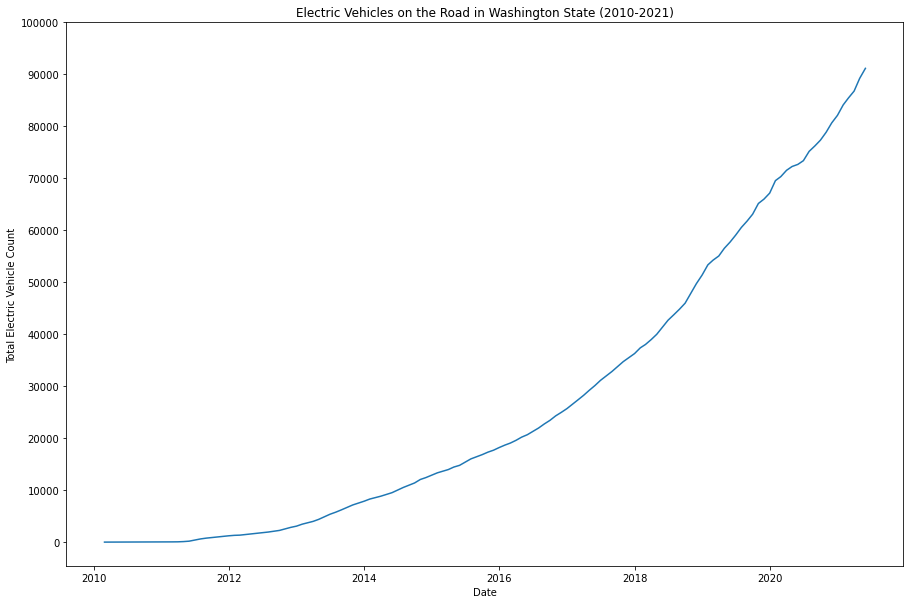

In [326]:
#plotting statewide EV Count
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,10))
sns.lineplot(x='transaction_date', y='State Total', data=df_cumsum, ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Total Electric Vehicle Count')
ax.set_title('Electric Vehicles on the Road in Washington State (2010-2021)')
ax.set_yticks(range(0,110000,10000));

As we can see above, the amount of electric vehicles on Washington State roads have been increasing exponentially over the past 10 years. On a high level, this confirms that Washington State has the necessary demand trend for electric vehicles to make investing in it profitable for an EV charging company. 

Since our data goes back as far as 2010, the count starts with 0 in 2010. However, it is important to note that this does not necessarily mean that there weren't any electric vehicles on the road in 2010. We are simply taking 2010 as our starting point and therefore the counts are relative.

## Electric Vehicles on the Road Over Time by County

Now that we looked at the statewide trend, we can start looking at individual counties. Since we have limited time for this analysis, we will be limiting our analysis to the top 10 counties that had the most electric vehicle purchases in the past 10 years.

In [327]:
df['county'].value_counts()

King            62119
Snohomish       12305
Pierce           8949
Clark            6155
Thurston         4110
Kitsap           4104
Whatcom          2963
Spokane          2575
Benton           1277
Island           1251
Skagit           1204
Clallam           708
Jefferson         692
San Juan          663
Cowlitz           537
Chelan            521
Mason             520
Yakima            508
Lewis             437
Grays Harbor      396
Franklin          347
Grant             267
Walla Walla       256
Kittitas          247
Douglas           190
Whitman           159
Klickitat         153
Pacific           136
Stevens           125
Okanogan          104
Skamania          100
Asotin             49
Adams              30
Pend Oreille       28
Wahkiakum          28
Lincoln            25
Ferry              16
Columbia           13
Garfield            2
Name: county, dtype: int64

In [328]:
top_ten_counties = ['King', 'Snohomish', 'Pierce', 'Clark', 'Thurston', 
                  'Kitsap', 'Whatcom', 'Spokane', 'Benton', 'Island']

In [329]:
#filtering out counties to keep top 10
df_cumsum = df_cumsum.loc[:, ['transaction_date', *top_ten_counties]]
df_cumsum.head()

transaction_date  King  Snohomish  Pierce  Clark  Thurston  Kitsap  Whatcom  \
0       2010-02-28   0.0        0.0     0.0    0.0       0.0       1      0.0   
1       2010-03-31   1.0        0.0     0.0    1.0       0.0       1      0.0   
2       2010-04-30   2.0        0.0     0.0    1.0       0.0       1      1.0   
3       2010-05-31   2.0        1.0     0.0    1.0       1.0       1      1.0   
4       2010-06-30   3.0        1.0     0.0    1.0       1.0       1      1.0   

   Spokane  Benton  Island  
0      0.0     0.0     0.0  
1      0.0     0.0     0.0  
2      1.0     0.0     0.0  
3      1.0     0.0     0.0  
4      1.0     0.0     0.0

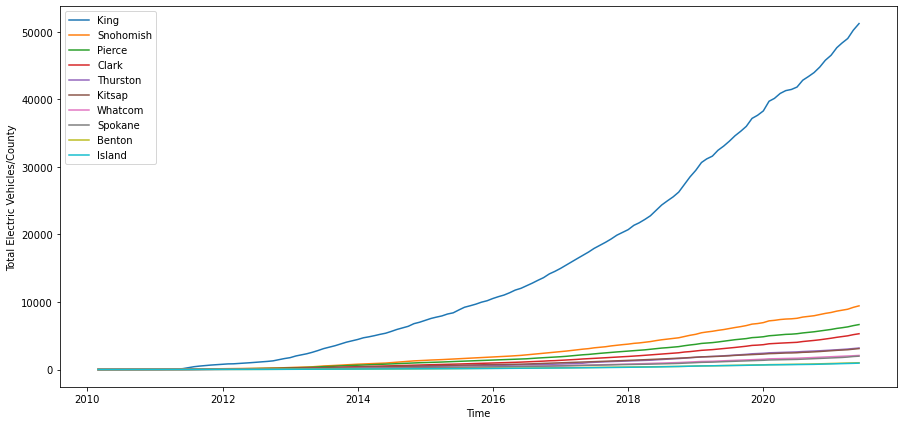

In [330]:
#plotting county trends
fig, ax = plt.subplots(figsize=(15,7))
for county in top_ten_counties:
    sns.lineplot(x='transaction_date', y=county, data=df_cumsum, ax=ax, 
                 label=county)
ax.set_xlabel('Time')
ax.set_ylabel('Total Electric Vehicles/County')
ax.legend();
# df_cumsum.plot()

Here, we can see that out of the top 10 most EV purchasing counties, King County has been growing much faster compared to others. This is expected since King County includes Seattle, which is the largest city by population in Washington State. Due to the scale differences between King County and the other 9 counties, it is difficult to see how these 9 counties compare to each other.

## Electric Vehicles on the Road Over Time (Excluding King County)

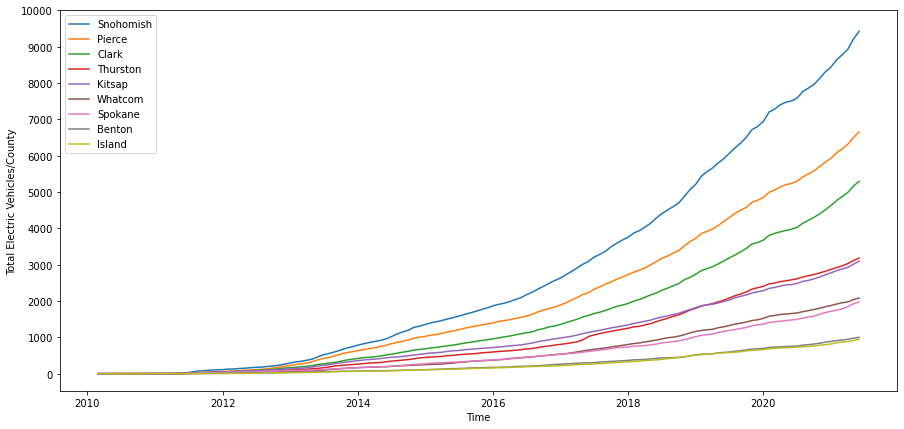

In [334]:
#plotting county trends except for King County
top_ten_counties.remove('King')

fig, ax = plt.subplots(figsize=(15,7))
for county in top_ten_counties:
    sns.lineplot(x='transaction_date', y=county, data=df_cumsum, ax=ax, 
                 label=county)
ax.set_xlabel('Time')
ax.set_ylabel('Total Electric Vehicles/County')
ax.set_yticks(range(0,11000,1000))
ax.legend()

When we exclude King County, we can see that Snohomish County is leading the charge in electric vehicle purchases followed by Pierce and Clark County. 

In [335]:
top_ten_counties += ['King']

## Most Purchased Car Models by County

Another important piece of information that can be relevant for an electric charging company is what the most purchased electric vehicle models are in each of these counties to decide on additional factors. These may include: 

- Whether to include adapters for different connector types (Tesla, CCS, CHAdeMO etc.)
- What kind of charging station to build (level 1, level 2, level 3)
- Spacing of chargers based on the size of vehicles

In [65]:
def model_counts_by_county(df=df, top_n=10, county_list=top_ten_counties):
     
    fig, ax = plt.subplots(figsize=(10, 60), nrows=len(county_list))
    
    for i, county in enumerate(county_list):
        df_county = df[(df['county']==county) & 
                       (df['transaction_type']=='Original Title')]
        model_count_df = pd.DataFrame(df_county['model'].value_counts()).reset_index()
        model_count_df.columns=['model', 'count']
        sns.barplot(x='model', y='count', data=model_count_df.head(top_n), 
                    ax=ax[i])
        ax[i].set_title(f'Top {top_n} Most Purchased Models in {county} County (2010-2021)')
    plt.tight_layout();

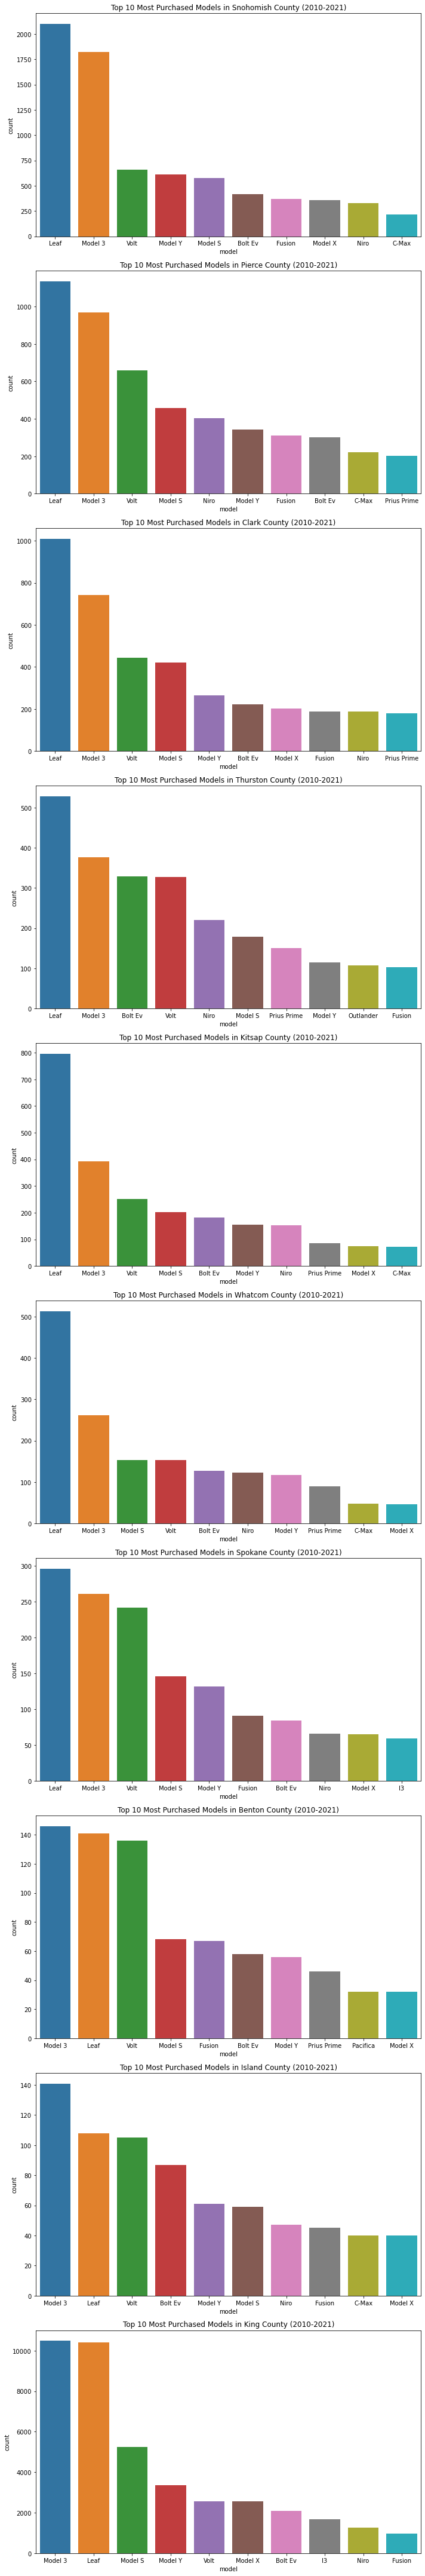

In [66]:
model_counts_by_county()

Nissan Leaf and Tesla Model 3 are the most purchased vehicles in each of these counties. Arguably, this is due to the relatively lower MSRP of these vehicles compared to more expensive models such as Tesla Model X.

# MODEL

## Preprocessing/ Defining Functions

In [67]:
df_cumsum = df_cumsum.set_index('transaction_date').resample('M').asfreq()

In [68]:
df_cumsum.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 136 entries, 2010-02-28 to 2021-05-31
Freq: M
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   King       136 non-null    float64
 1   Snohomish  136 non-null    float64
 2   Pierce     136 non-null    float64
 3   Clark      136 non-null    float64
 4   Thurston   136 non-null    float64
 5   Kitsap     136 non-null    int64  
 6   Whatcom    136 non-null    float64
 7   Spokane    136 non-null    float64
 8   Benton     136 non-null    float64
 9   Island     136 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 11.7 KB


### Separating Data for Each County

As discussed above, we will be creating time series models for the top ten counties. This requires us to break down the dataframe we have into smaller dataframes for each county.

In [69]:
def separate_data_by_county(county, df):
    df_county = pd.DataFrame(df.loc[:, county])
    df_county.columns=["EV's on the Road"]
    df_county.head()
    return df_county

In [70]:
#separating data by county and parsing this information to a dictionary
county_information = {}
for county in top_ten_counties:
    county_information[county] = {}
    county_information[county]['df']=separate_data_by_county(county, df_cumsum)

In [71]:
#separating data by county and parsing this information to a dictionary
county_dfs = {}
for county in top_ten_counties:
    county_dfs[county] = separate_data_by_county(county, df_cumsum)

### Functionizing the Evaluation of Models

Before modelling, one of the functions we will need is a function that will show us the various statistics so that we can evaluate the performance of the model.

In [72]:
def evaluate_model(model):
    display(model.summary())
    model.plot_diagnostics()
    plt.tight_layout();

### Creating a Function for train_test_split & plotting

We will be splitting the time series into two: a training set and a testing set. This will allow us to validate the performance of the models.

In [74]:
def train_test_split_ts (df, train_size, test_size):
    train_end_idx = int(round(len(df)*train_size,0))
    train_set = df.iloc[0:train_end_idx,:]["EV's on the Road"]
    test_set = df.iloc[train_end_idx:,:]["EV's on the Road"]
    return train_set, test_set

Additionally, to visualize these splits we will need a plotting function.

In [75]:
def plot_train_test_split(train_data, test_data, county):
    train_data.plot(label='Train Data')
    test_data.plot(label='Test Data')
    ax=plt.gca()
    ax.set_xlabel('Year')
    ax.set_ylabel('Electric Vehicles on the Road')
    ax.set_title(f'Electric Vehicles on the Road in {county} County')
    ax.legend();

### Creating a Function for Getting Forecasts

For validation purposes we will be getting the forecast from our model for the test period and will be plotting it against the actual test data.

In [76]:
def get_forecast(model, train_data, test_data, plot=True):
    #creating a df with the forecast information
    forecast_df = model.get_forecast(steps=len(test_data)).conf_int()
    forecast_df.columns = ['Lower Confidence Interval', 
                              'Upper Confidence Interval']
    forecast_df['Forecasts'] = model.get_forecast(steps=len(test_data))\
    .predicted_mean
    #plotting
    if plot==True:
        with plt.style.context('seaborn-whitegrid'):
            fig, ax = plt.subplots(figsize=(15, 10))
            sns.lineplot(data=train_data, color='black', ax=ax)
            sns.lineplot(data=forecast_df, x=forecast_df.index, 
                         y='Forecasts', color='blue', ax=ax, 
                         label='Forecasted Data', ls='--')
            sns.lineplot(data=test_data, color='purple', ax=ax, 
                         label='Actual Data', ls='-.')
            ax.fill_between(forecast_df.index, 
                            y1=forecast_df['Lower Confidence Interval'], 
                            y2=forecast_df['Upper Confidence Interval'],
                            color = 'green', alpha=0.3, 
                            label='Confidence Interval')
            ax.set_xlabel('Year')
            plt.show();
    return forecast_df

### Defining a Function for Getting Predictions for Future

Lastly, we will also be needing a function similar to the get_forecast function that will be used for getting predictions for the future and plotting for visualization.

In [77]:
def get_prediction(model, df, test_data, county_name, plot=True):
    #creating a df with the prediction information
    prediction_df = model.get_forecast(steps=len(test_data)).conf_int()
    prediction_df.columns = ['Lower Confidence Interval', 
                              'Upper Confidence Interval']
    prediction_df['Predictions'] = model.get_forecast(steps=len(test_data))\
    .predicted_mean
    #plotting
    if plot==True:
        with plt.style.context('seaborn-whitegrid'):
            fig, ax = plt.subplots(figsize=(15, 10))
            sns.lineplot(data=df, color='black', ax=ax)
            sns.lineplot(data=prediction_df, x=prediction_df.index, 
                         y='Predictions', color='orange', ax=ax, 
                         label='Predicted Data', ls='--')
            ax.fill_between(prediction_df.index, 
                            y1=prediction_df['Lower Confidence Interval'], 
                            y2=prediction_df['Upper Confidence Interval'],
                            color = 'green', alpha=0.3, 
                            label='Confidence Interval')
            ax.set_xlabel('Year')
            ax.set_ylabel('Electric Vehicles on the Road')
            ax.set_title(f'Predicted Electric Vehicle Count for {county_name}')
            plt.show();
    return prediction_df

## King County

### Seasonality Check

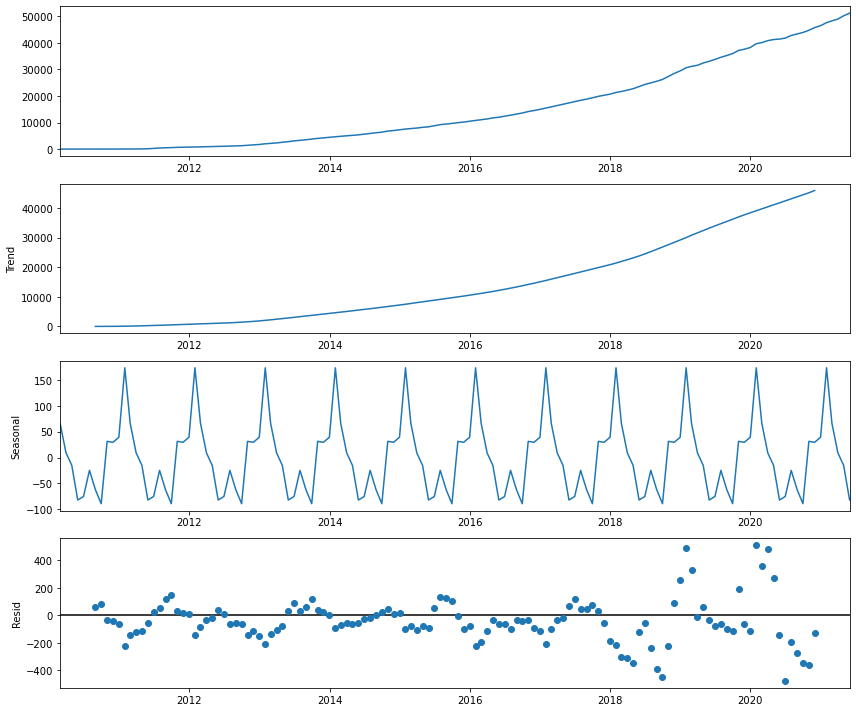

In [78]:
import statsmodels.tsa.api as tsa

plt.rcParams['figure.figsize']=(12,10)
decomp = tsa.seasonal_decompose(county_information['King']['df'])
decomp.plot();

The seasonal component of the time series for King county indicates only about a 200 car difference over the years which in the big picture is not much. Since we don't have a strong seasonality component, we will go ahead and use ARIMA models.

### train_test_split

In [79]:
train_king, test_king = train_test_split_ts(county_information['King']['df'], 
                                            0.80, 0.20)

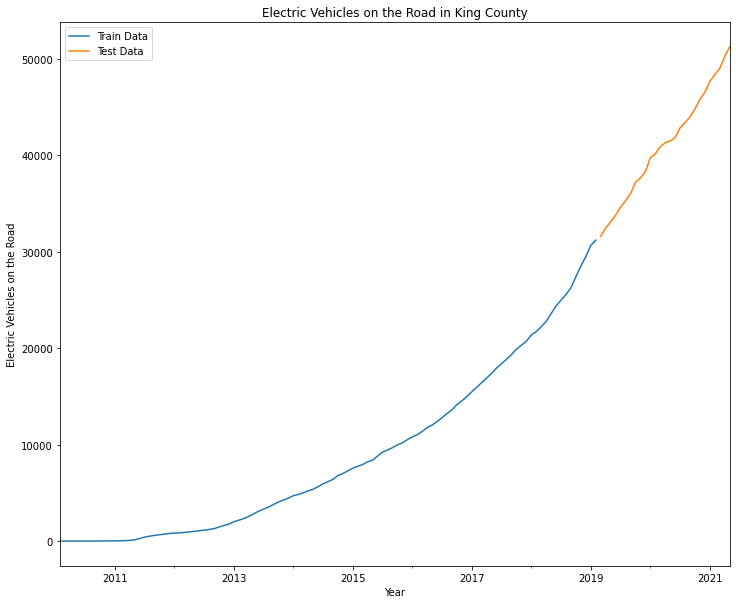

In [80]:
plot_train_test_split(train_king, test_king, 'King')

### Tuning Hyperparameters with Auto-Arima

In [81]:
import pmdarima as pm

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  109
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -570.311
Date:                            Sat, 10 Jul 2021   AIC                           1146.622
Time:                                    13:19:27   BIC                           1154.315
Sample:                                         0   HQIC                          1149.732
                                            - 109                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     26.5079     13.389      1.980      0.048       0.265      52.751
ar.L1          0.7305      0.051     14.288      0.000       0.630       0.831
sigma2      8406.6096    814.668     10.319      0.000    6809.890       1e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                61.47
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               7.72   Skew:                             0.98
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

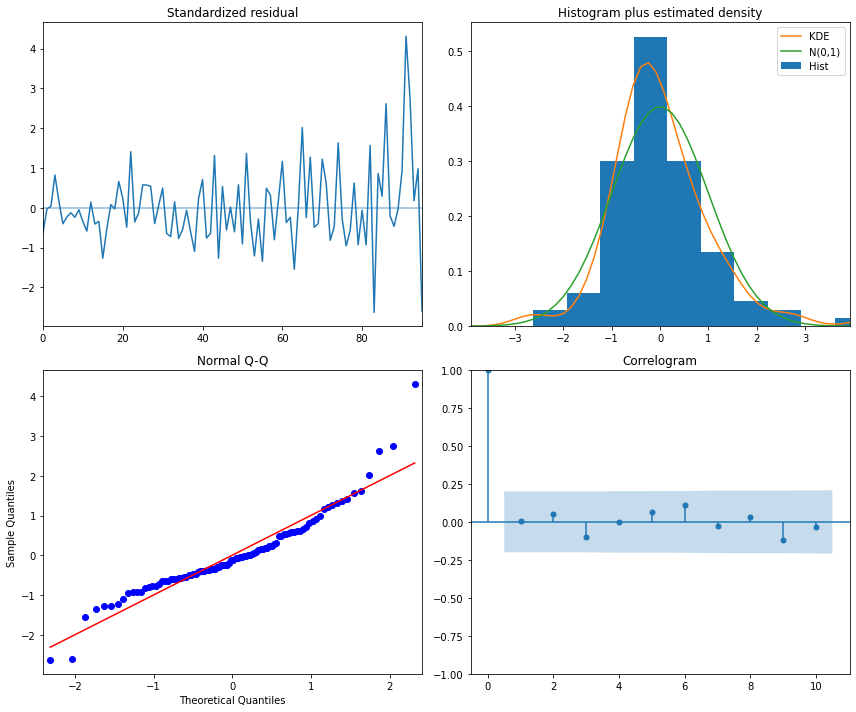

In [82]:
auto_model = pm.auto_arima(train_king, start_p=0, d=1, start_q=0, max_p=4, 
                           max_d=3, max_q=4, start_P=0, start_Q=0, max_P=3, 
                           max_D=3, max_Q=3, m=12)
evaluate_model(auto_model)

### Model with Best Parameters

In [83]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  109
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -567.043
Date:                            Sat, 10 Jul 2021   AIC                           1138.087
Time:                                    13:53:44   BIC                           1143.195
Sample:                                02-28-2010   HQIC                          1140.151
                                     - 02-28-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8305      0.042     20.002      0.000       0.749       0.912
sigma2      8954.2159    822.909     10.881      0.000    7341.344    1.06e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.66   Jarque-Bera (JB):                42.89
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               7.52   Skew:                             0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

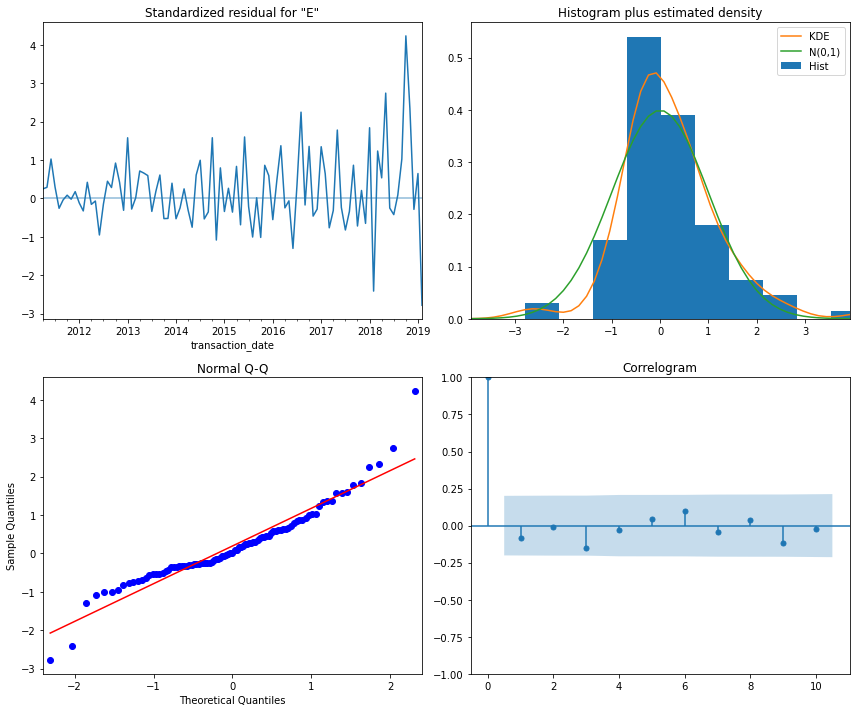

In [199]:
model = SARIMAX(train_king, order=(1,1,0), 
                seasonal_order=(0,1,0,12), enforce_invertibility=False, enforce_stationarity=False).fit(maxiter=100)
evaluate_model(model)

### Validate Model with Forecasts for Test Data

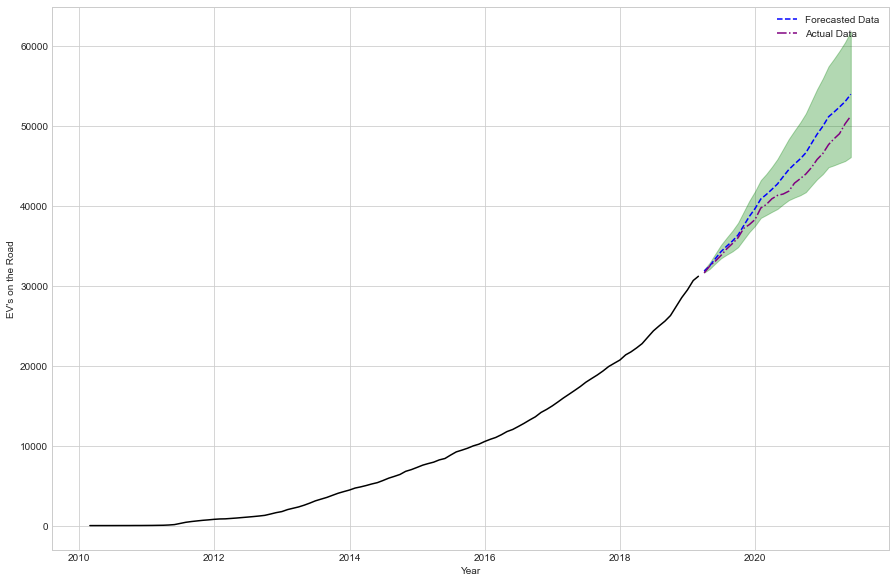

In [200]:
df_king_forecast = get_forecast(model, train_king, test_king, plot=True)

### Future Predictions

#### Finding Best Parameters with Auto-Arima

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  136
Model:             SARIMAX(3, 1, 0)x(2, 0, 0, 12)   Log Likelihood                -876.051
Date:                            Sat, 10 Jul 2021   AIC                           1766.102
Time:                                    13:54:24   BIC                           1786.439
Sample:                                         0   HQIC                          1774.367
                                            - 136                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     25.7199     20.974      1.226      0.220     -15.388      66.828
ar.L1          0.4137      0.066      6.288      0.000       0.285       0.543
ar.L2          0.1157      0.073      1.590      0.112      -0.027       0.258
ar.L3          0.3621      0.052      6.949      0.000       0.260       0.464
ar.S.L12       0.1600      0.059      2.702      0.007       0.044       0.276
ar.S.L24       0.3035      0.125      2.424      0.015       0.058       0.549
sigma2      2.453e+04   1983.255     12.369      0.000    2.06e+04    2.84e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               135.24
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):              29.97   Skew:                             0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

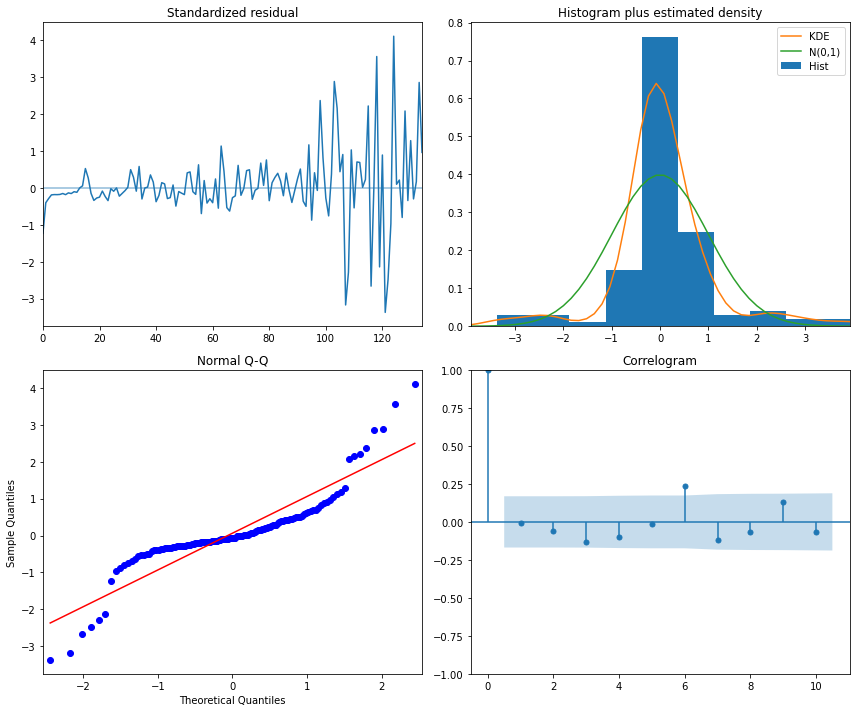

In [201]:
auto_model = pm.auto_arima(county_information['King']['df'], start_p=0, d=1, 
                           start_q=0, max_p=4, max_d=4, max_q=4, start_P=0, 
                           start_Q=0, max_P=3, max_D=3, max_Q=3, m=12)
evaluate_model(auto_model)

#### Model with Best Parameters

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  136
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -818.139
Date:                            Sat, 10 Jul 2021   AIC                           1640.277
Time:                                    16:12:56   BIC                           1645.885
Sample:                                02-28-2010   HQIC                          1642.555
                                     - 05-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4919      0.062      7.989      0.000       0.371       0.613
sigma2      3.911e+04   2910.227     13.440      0.000    3.34e+04    4.48e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.72   Jarque-Bera (JB):               108.03
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):              26.48   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

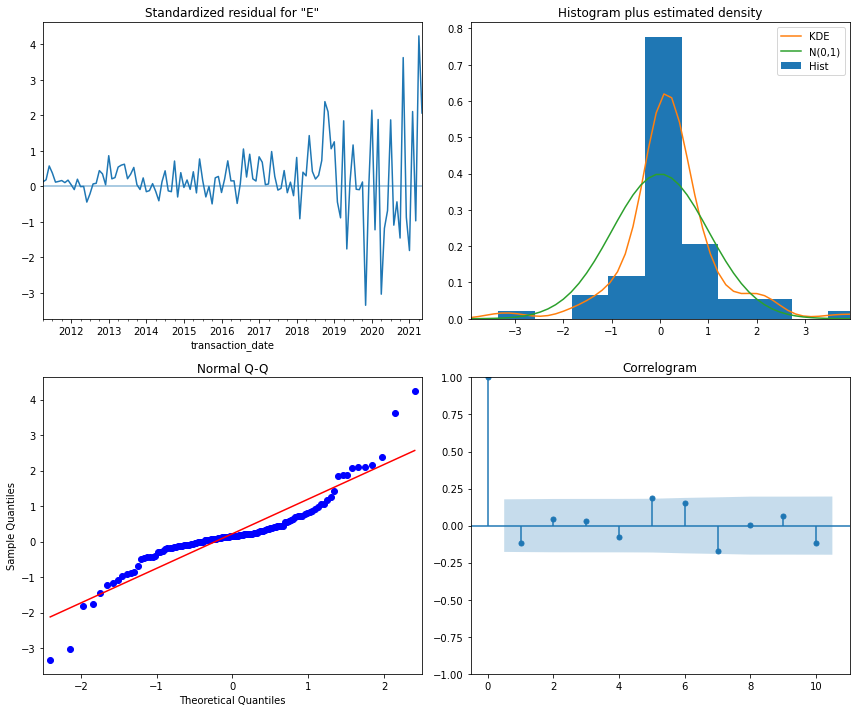

In [336]:
model = SARIMAX(county_information['King']['df'], order=(1,1,0), 
                seasonal_order=(0,1,0,12), enforce_invertibility=False, 
                enforce_stationarity=False).fit()
evaluate_model(model)

#### Plotting & Saving Predictions

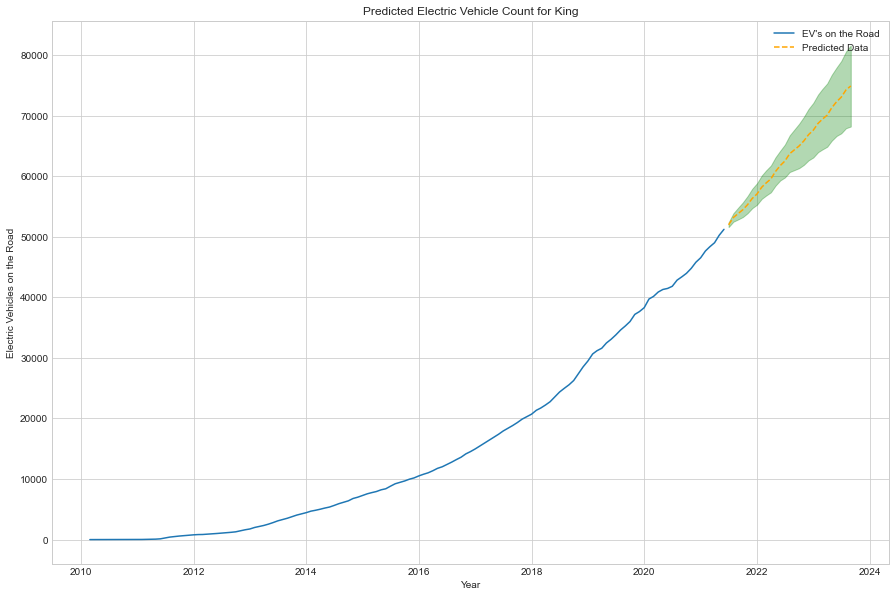

In [337]:
df_king_preds = get_prediction(model, county_information['King']['df'], 
                               test_king, 'King', plot=True)

In [204]:
county_information['King']['Predictions'] = df_king_preds

## Snohomish County

### Seasonality Check

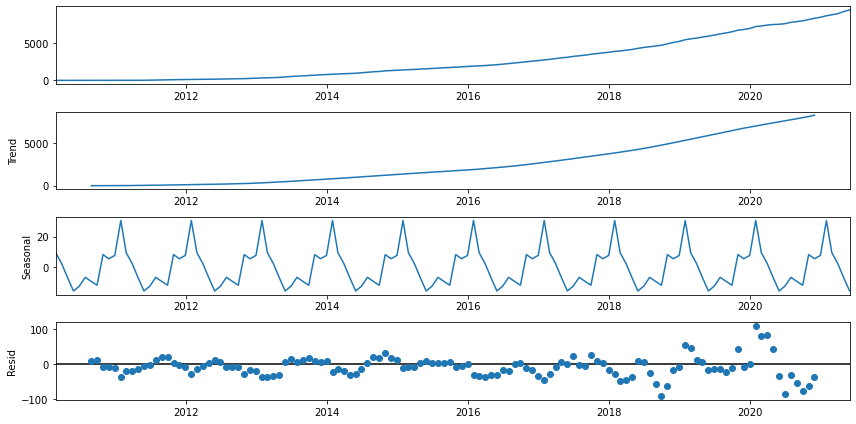

In [205]:
plt.rcParams['figure.figsize']=(12,6)
decomp = tsa.seasonal_decompose(county_information['Snohomish']['df'])
decomp.plot();

### train_test_split

In [206]:
train_sno, test_sno = train_test_split_ts(county_information['Snohomish']['df'],
                                          0.80, 0.20)

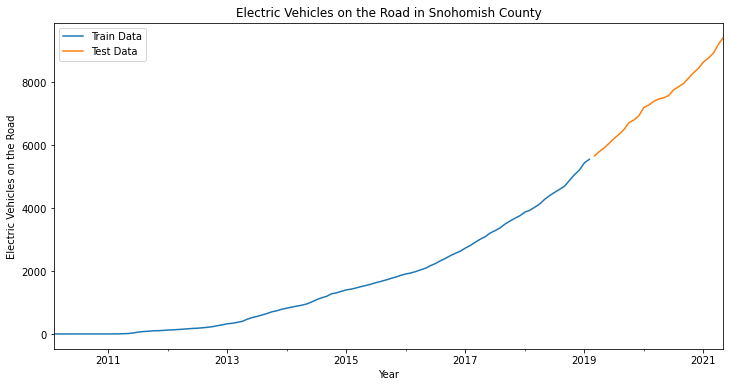

In [207]:
plot_train_test_split(train_sno, test_sno, 'Snohomish')

### Tuning Hyperparameters with Auto-Arima

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  109
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -469.482
Date:                            Sat, 10 Jul 2021   AIC                            948.965
Time:                                    13:55:08   BIC                            962.376
Sample:                                         0   HQIC                           954.402
                                            - 109                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9946      0.011     88.051      0.000       0.972       1.017
ma.L1         -0.6151      0.074     -8.282      0.000      -0.761      -0.470
ar.S.L12       0.8306      0.284      2.923      0.003       0.274       1.387
ma.S.L12      -0.6102      0.320     -1.910      0.056      -1.237       0.016
sigma2       327.2626     33.190      9.860      0.000     262.211     392.314
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):               138.11
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):              17.10   Skew:                             1.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

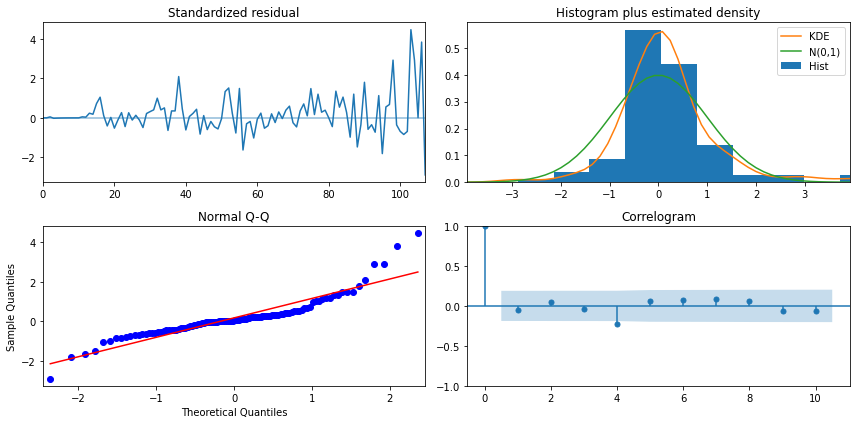

In [208]:
auto_model = pm.auto_arima(train_sno, start_p=0, start_q=0, d=1, max_p=4, 
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0, 
                           m=12, verbose=2)
evaluate_model(auto_model)

### Model with Best Parameters

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  109
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -411.509
Date:                            Sat, 10 Jul 2021   AIC                            833.017
Time:                                    13:55:09   BIC                            845.734
Sample:                                02-28-2010   HQIC                           838.154
                                     - 02-28-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0262      0.012     83.379      0.000       1.002       1.050
ma.L1         -0.7143      0.059    -12.167      0.000      -0.829      -0.599
ar.S.L12       0.6426      0.389      1.650      0.099      -0.121       1.406
ma.S.L12      -0.3215      0.420     -0.766      0.444      -1.144       0.501
sigma2       365.5570     49.905      7.325      0.000     267.745     463.369
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                52.50
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               6.94   Skew:                             0.99
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

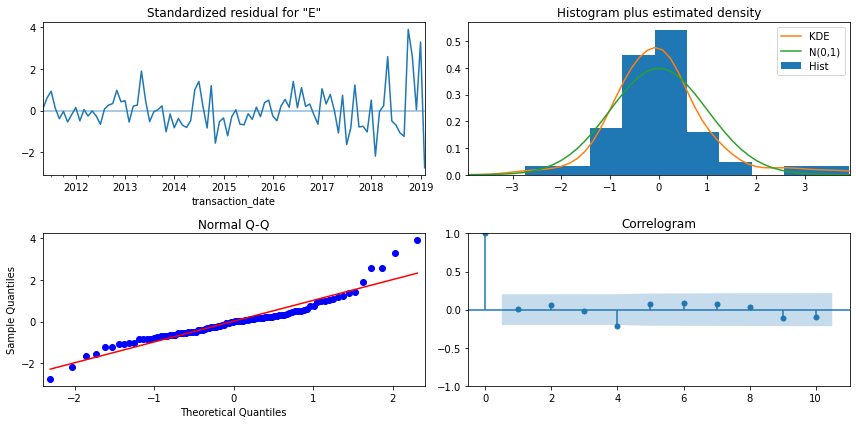

In [209]:
model = SARIMAX(train_sno, order=(1,1,1), seasonal_order=(1,0,1,12), 
                enforce_invertibility=False, enforce_stationarity=False).fit()
evaluate_model(model)

### Validate Model with Forecasts for Test Data

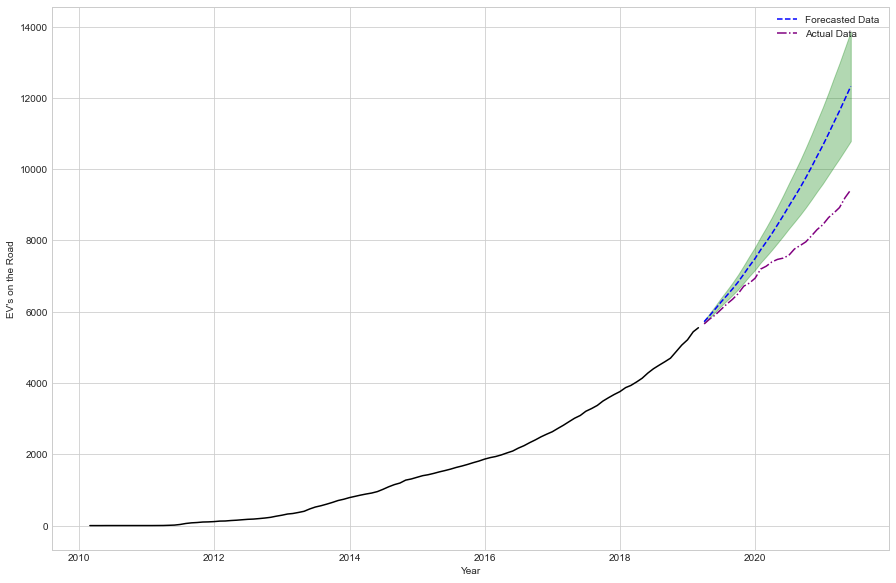

In [210]:
df_sno_forecast = get_forecast(model, train_sno, test_sno, plot=True)

### Future Predictions

#### Finding Best Parameters with Auto-Arima

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  136
Model:             SARIMAX(3, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -648.483
Date:                              Sat, 10 Jul 2021   AIC                           1308.967
Time:                                      13:21:12   BIC                           1326.398
Sample:                                           0   HQIC                          1316.050
                                              - 136                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4371      0.074      5.880      0.000       0.291       0.583
ar.L2          0.1163      0.082      1.421      0.155      -0.044       0.277
ar.L3          0.4170      0.047      8.919      0.000       0.325       0.509
ar.S.L12       0.8644      0.295      2.934      0.003       0.287       1.442
ma.S.L12      -0.7078      0.316     -2.239      0.025      -1.328      -0.088
sigma2       835.3371     61.515     13.579      0.000     714.771     955.904
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               178.98
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):              25.22   Skew:                             0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

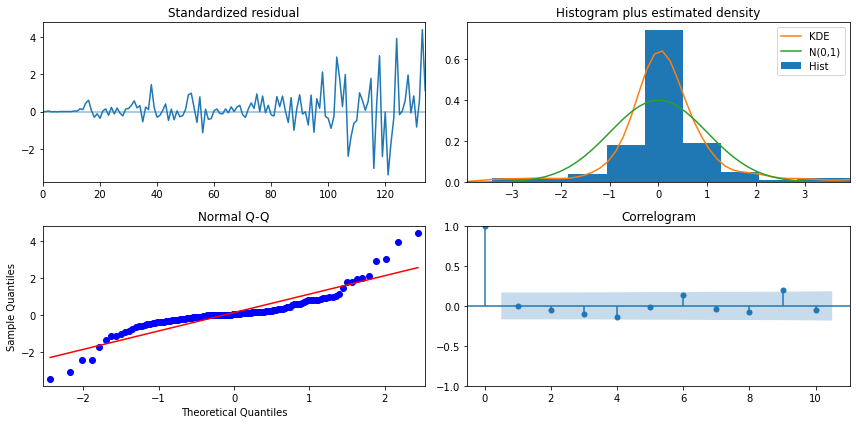

In [96]:
auto_model = pm.auto_arima(county_information['Snohomish']['df'], start_p=0, 
                           start_q=0,d=1, max_p=4, max_q=4, max_P=3,max_Q=3, 
                           start_P=0, start_Q=0, m=12, verbose=2)
evaluate_model(auto_model)

#### Model with Best Parameters

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                     EV's on the Road   No. Observations:                  136
Model:             SARIMAX(3, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -582.365
Date:                              Sat, 10 Jul 2021   AIC                           1176.730
Time:                                      13:55:15   BIC                           1193.455
Sample:                                  02-28-2010   HQIC                          1183.522
                                       - 05-31-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4461      0.080      5.557      0.000       0.289       0.603
ar.L2          0.1274      0.094      1.357      0.175      -0.057       0.311
ar.L3          0.4466      0.050      8.869      0.000       0.348       0.545
ar.S.L12       0.4206      0.550      0.764      0.445      -0.658       1.499
ma.S.L12      -0.1976      0.569     -0.347      0.729      -1.313       0.918
sigma2       957.4263     72.865     13.140      0.000     814.613    1100.239
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               111.87
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):              15.90   Skew:                             0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

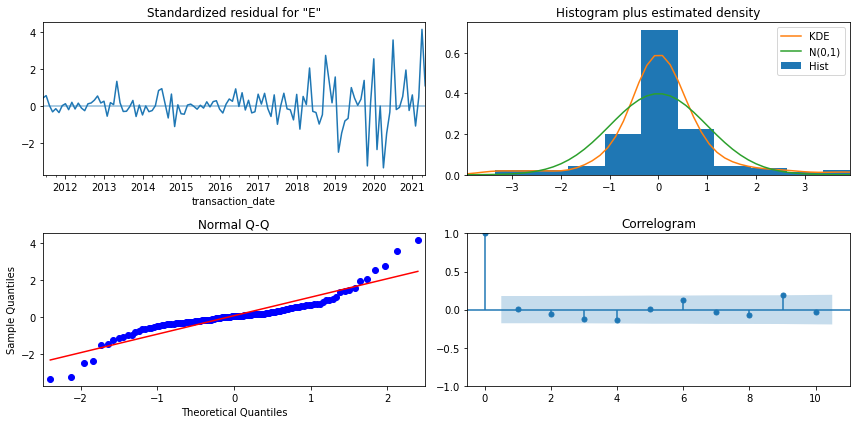

In [211]:
model = SARIMAX(county_information['Snohomish']['df'], order=(3,1,0), 
                seasonal_order=(1,0,1,12), enforce_invertibility=False, 
                enforce_stationarity=False).fit()
evaluate_model(model)

#### Plotting & Saving Predictions

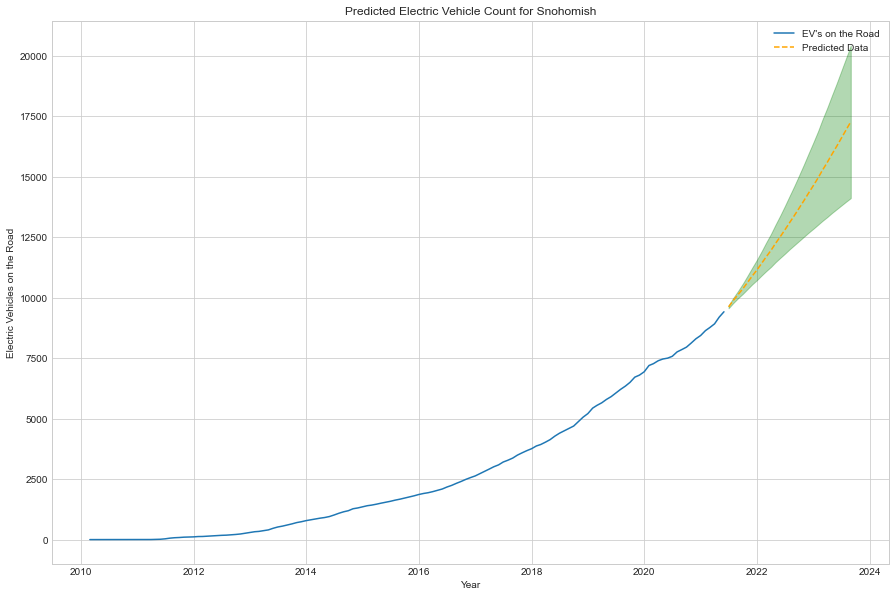

In [212]:
df_sno_preds = get_prediction(model, county_information['Snohomish']['df'], 
                               test_sno, 'Snohomish', plot=True)

In [213]:
county_information['Snohomish']['Predictions'] = df_sno_preds

## Pierce County

### Seasonality Check

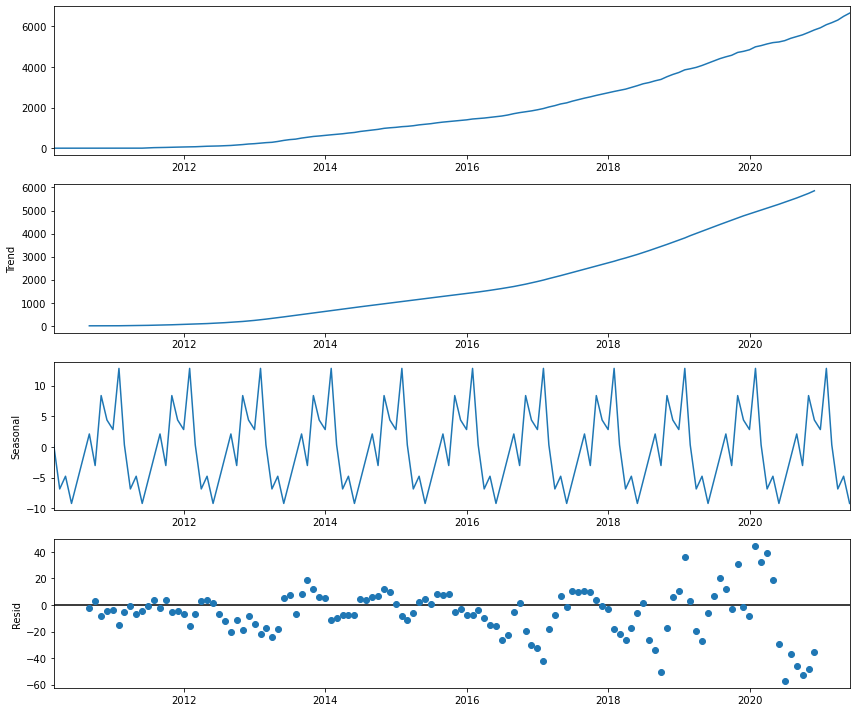

In [214]:
plt.rcParams['figure.figsize']=(12,10)
decomp = tsa.seasonal_decompose(county_information['Pierce']['df'])
decomp.plot();

The seasonal component of the time series for King county indicates only about a 200 car difference over the years which in the big picture is not much. Since we don't have a strong seasonality component, we will go ahead and use ARIMA models.

### train_test_split

In [215]:
train_pierce, test_pierce = train_test_split_ts(county_information['Pierce']['df'], 
                                            0.80, 0.20)

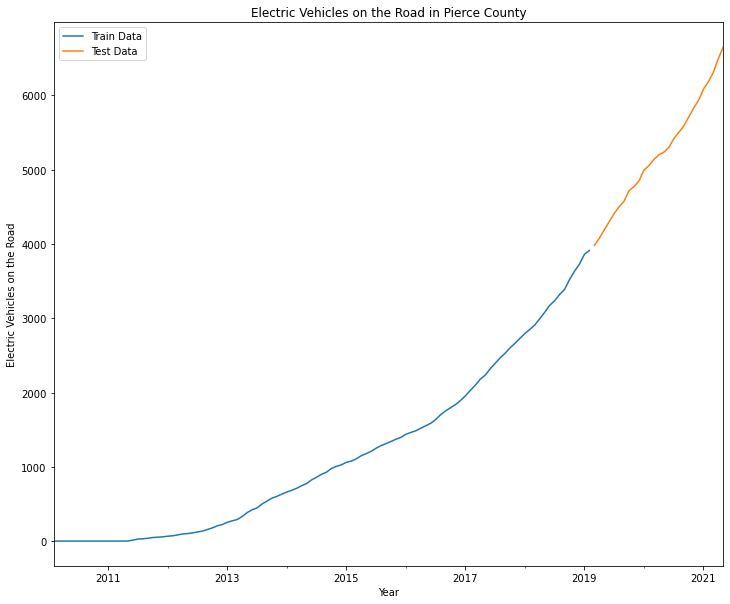

In [216]:
plot_train_test_split(train_pierce, test_pierce, 'Pierce')

### Tuning Hyperparameters with Auto-Arima

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  109
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -430.825
Date:                            Sat, 10 Jul 2021   AIC                            869.649
Time:                                    13:21:37   BIC                            880.378
Sample:                                         0   HQIC                           873.999
                                            - 109                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9953      0.010    103.009      0.000       0.976       1.014
ma.L1         -0.6335      0.093     -6.826      0.000      -0.815      -0.452
ma.S.L12       0.3058      0.155      1.968      0.049       0.001       0.610
sigma2       163.2606     14.744     11.073      0.000     134.363     192.158
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):               139.53
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):              17.75   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

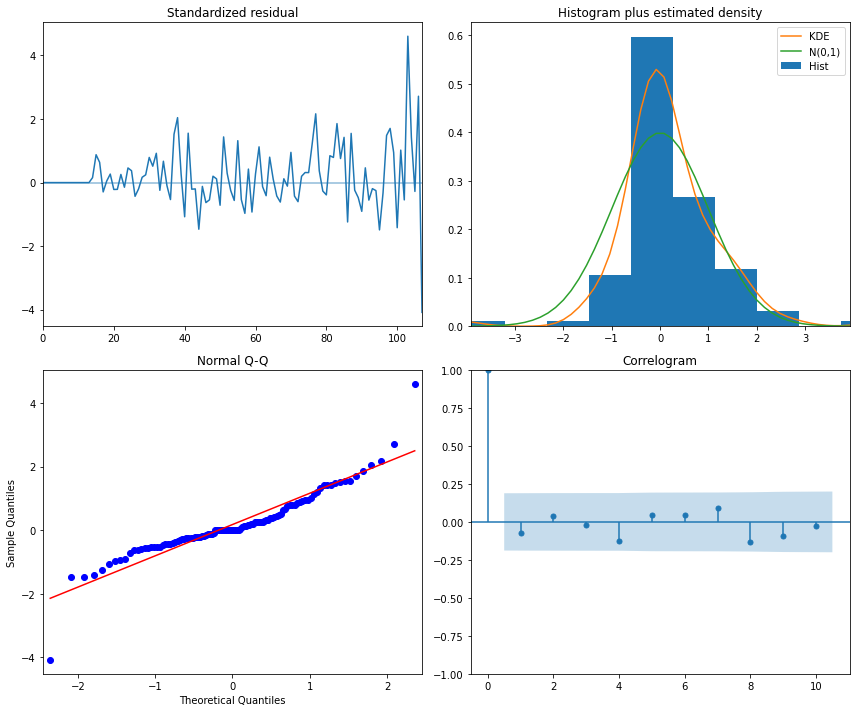

In [103]:
auto_model = pm.auto_arima(train_pierce, start_p=0, start_q=0, d=1, max_p=4, 
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0, 
                           m=12, verbose=2)
evaluate_model(auto_model)

### Model with Best Parameters

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  109
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -378.653
Date:                            Sat, 10 Jul 2021   AIC                            765.306
Time:                                    13:55:43   BIC                            775.479
Sample:                                02-28-2010   HQIC                           769.415
                                     - 02-28-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0181      0.009    114.050      0.000       1.001       1.036
ma.L1         -0.7345      0.091     -8.054      0.000      -0.913      -0.556
ma.S.L12       0.2292      0.167      1.375      0.169      -0.098       0.556
sigma2       183.7314     20.610      8.915      0.000     143.337     224.126
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                66.58
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               4.49   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

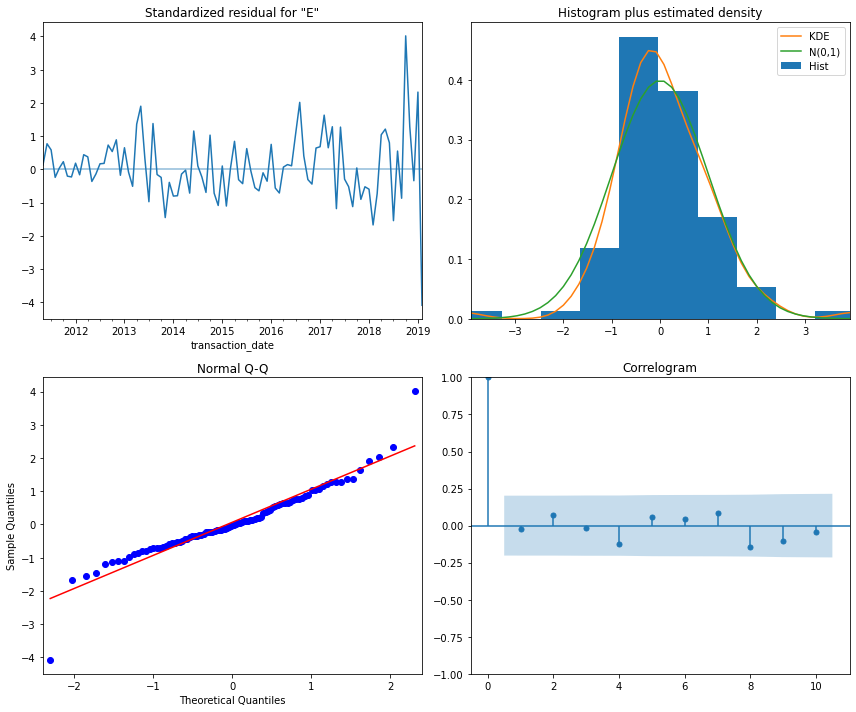

In [217]:
model = SARIMAX(train_pierce, order=(1,1,1), seasonal_order=(0,0,1,12), 
                enforce_invertibility=False, enforce_stationarity=False).fit()
evaluate_model(model)

### Validate Model with Forecasts for Test Data

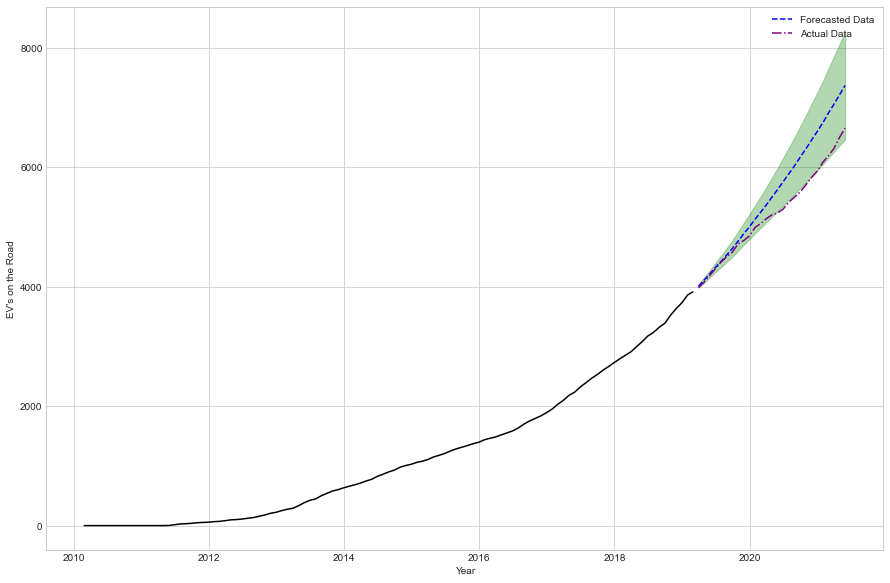

In [218]:
df_pierce_forecast = get_forecast(model, train_pierce, test_pierce, plot=True)

### Future Predictions

#### Finding Best Parameters with Auto-Arima

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  136
Model:             SARIMAX(3, 1, 0)x(0, 0, [1], 12)   Log Likelihood                -582.868
Date:                              Sat, 10 Jul 2021   AIC                           1175.736
Time:                                      13:21:55   BIC                           1190.262
Sample:                                           0   HQIC                          1181.639
                                              - 136                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4541      0.075      6.020      0.000       0.306       0.602
ar.L2          0.1687      0.071      2.371      0.018       0.029       0.308
ar.L3          0.3660      0.064      5.717      0.000       0.241       0.492
ma.S.L12       0.2741      0.067      4.081      0.000       0.142       0.406
sigma2       317.4123     25.038     12.677      0.000     268.339     366.486
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                63.29
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              12.62   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

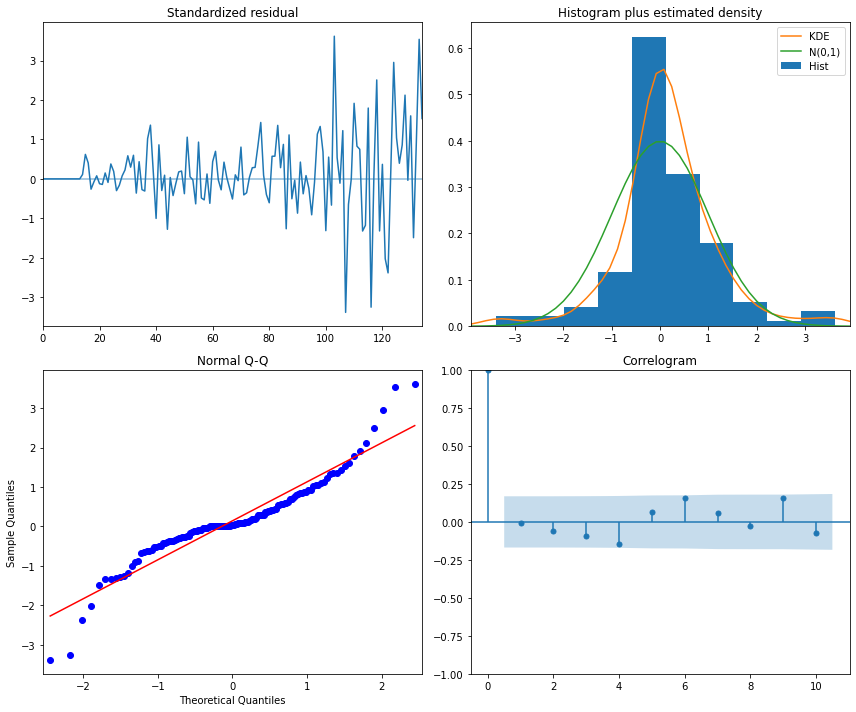

In [106]:
auto_model = pm.auto_arima(county_information['Pierce']['df'], start_p=0, 
                           start_q=0,d=1, max_p=4, max_q=4, max_P=3,max_Q=3, 
                           start_P=0, start_Q=0, m=12, verbose=2)
evaluate_model(auto_model)

#### Model with Best Parameters

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                     EV's on the Road   No. Observations:                  136
Model:             SARIMAX(3, 1, 0)x(0, 0, [1], 12)   Log Likelihood                -530.102
Date:                              Sat, 10 Jul 2021   AIC                           1070.203
Time:                                      13:56:02   BIC                           1084.224
Sample:                                  02-28-2010   HQIC                          1075.898
                                       - 05-31-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4493      0.085      5.303      0.000       0.283       0.615
ar.L2          0.1860      0.087      2.127      0.033       0.015       0.357
ar.L3          0.3997      0.070      5.682      0.000       0.262       0.538
ma.S.L12       0.2662      0.077      3.440      0.001       0.115       0.418
sigma2       345.7262     30.327     11.400      0.000     286.286     405.166
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                39.39
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              10.42   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

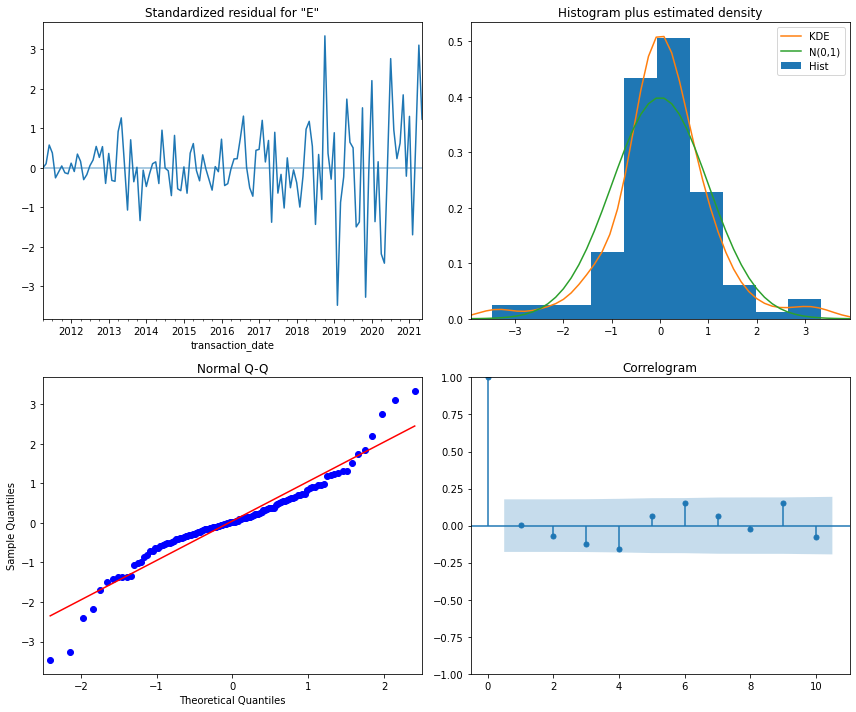

In [219]:
model = SARIMAX(county_information['Pierce']['df'], order=(3,1,0), 
                seasonal_order=(0,0,1,12), enforce_invertibility=False, 
                enforce_stationarity=False).fit()
evaluate_model(model)

#### Plotting & Saving Predictions

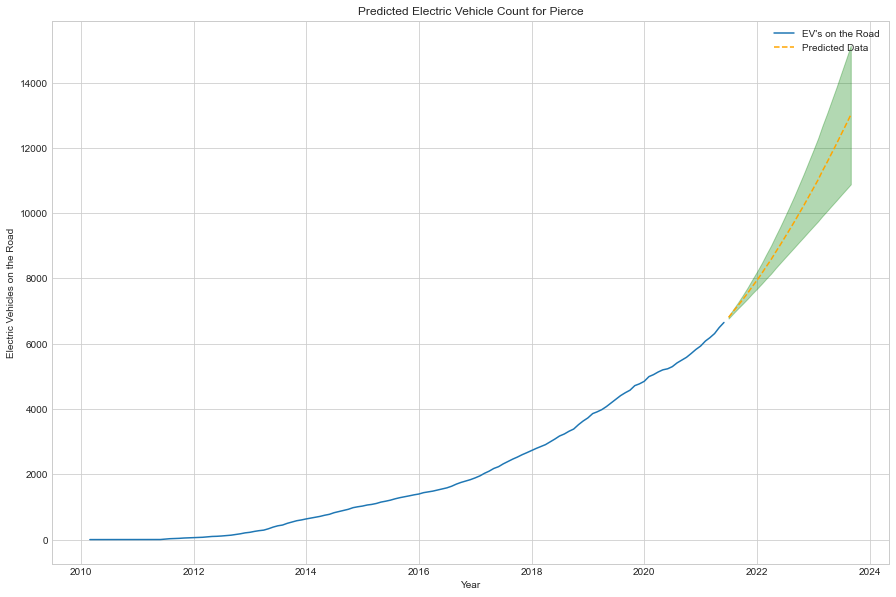

In [220]:
df_pierce_preds = get_prediction(model, county_information['Pierce']['df'], 
                               test_pierce, 'Pierce', plot=True)

In [221]:
county_information['Pierce']['Predictions'] = df_pierce_preds

## Clark County

### Seasonality Check

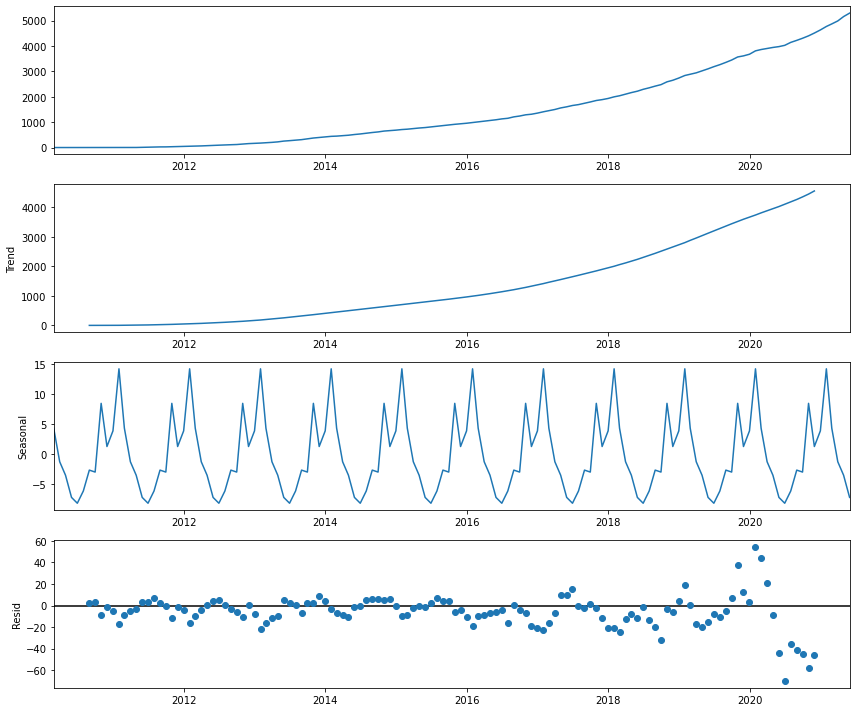

In [222]:
plt.rcParams['figure.figsize']=(12,10)
decomp = tsa.seasonal_decompose(county_information['Clark']['df'])
decomp.plot();

The seasonal component of the time series for King county indicates only about a 200 car difference over the years which in the big picture is not much. Since we don't have a strong seasonality component, we will go ahead and use ARIMA models.

### train_test_split

In [223]:
train_clark, test_clark = train_test_split_ts(county_information['Clark']['df'], 
                                            0.80, 0.20)

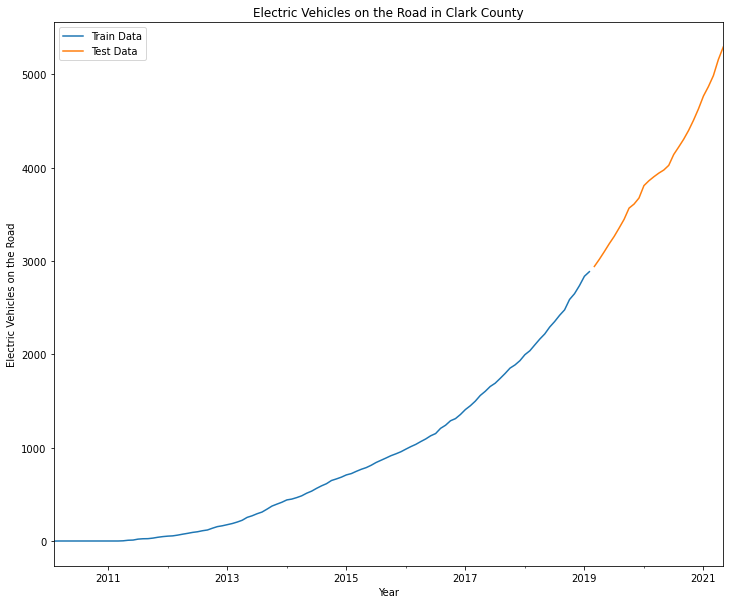

In [224]:
plot_train_test_split(train_clark, test_clark, 'Clark')

### Tuning Hyperparameters with Auto-Arima

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  109
Model:             SARIMAX(3, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -384.604
Date:                            Sat, 10 Jul 2021   AIC                            781.209
Time:                                    13:22:11   BIC                            797.302
Sample:                                         0   HQIC                           787.734
                                            - 109                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7380      1.217      0.606      0.544      -1.648       3.124
ar.L1          0.0922      0.123      0.752      0.452      -0.148       0.333
ar.L2          0.4601      0.089      5.189      0.000       0.286       0.634
ar.L3          0.4097      0.103      3.965      0.000       0.207       0.612
ar.S.L12       0.4922      0.129      3.827      0.000       0.240       0.744
sigma2        68.0026      7.886      8.623      0.000      52.546      83.459
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):               180.48
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):              11.63   Skew:                             0.91
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

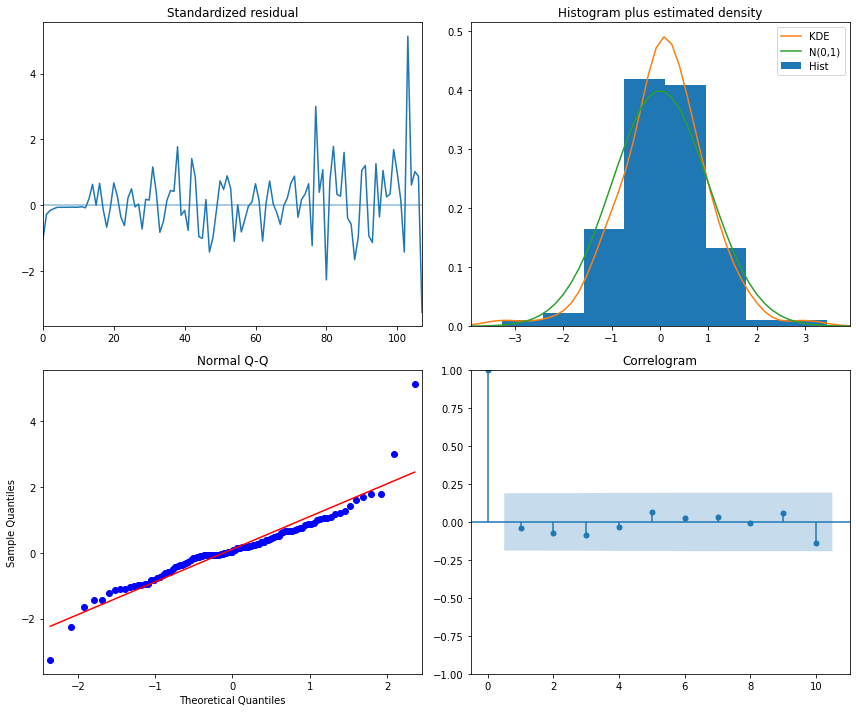

In [113]:
auto_model = pm.auto_arima(train_clark, start_p=0, start_q=0, d=1, max_p=4, 
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0, 
                           m=12, verbose=2)
evaluate_model(auto_model)

### Model with Best Parameters

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  109
Model:             SARIMAX(3, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -334.178
Date:                            Sat, 10 Jul 2021   AIC                            678.356
Time:                                    13:56:27   BIC                            691.019
Sample:                                02-28-2010   HQIC                           683.469
                                     - 02-28-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0962      0.145      0.664      0.507      -0.188       0.380
ar.L2          0.4851      0.107      4.515      0.000       0.275       0.696
ar.L3          0.4429      0.111      3.991      0.000       0.225       0.660
ar.S.L12       0.5570      0.144      3.869      0.000       0.275       0.839
sigma2        77.3810      9.951      7.776      0.000      57.878      96.884
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                77.07
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               5.20   Skew:                             0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

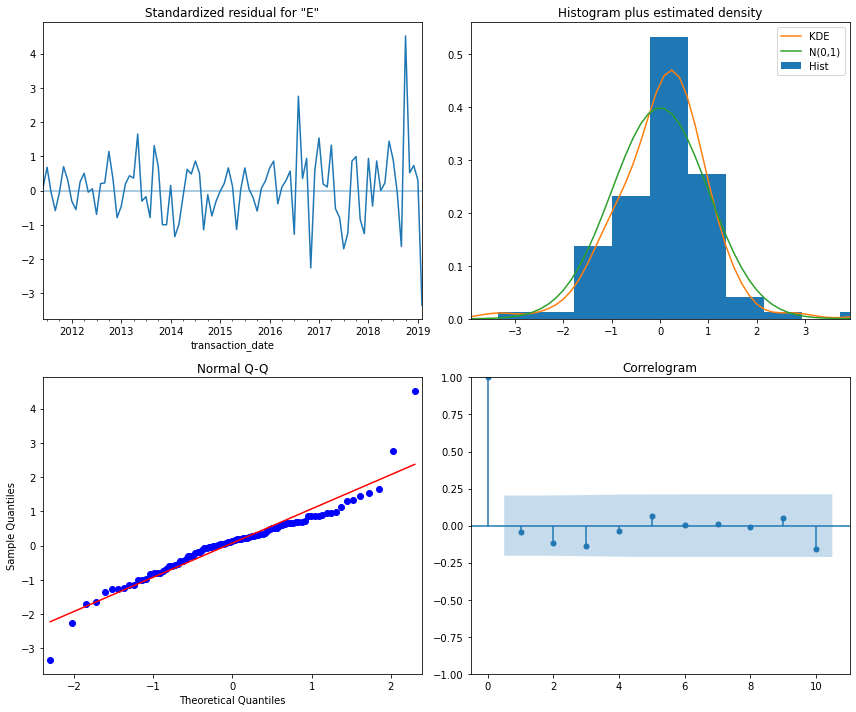

In [225]:
model = SARIMAX(train_clark, order=(3,1,0), seasonal_order=(1,0,0,12), 
                enforce_invertibility=False, enforce_stationarity=False).fit()
evaluate_model(model)

### Validate Model with Forecasts for Test Data

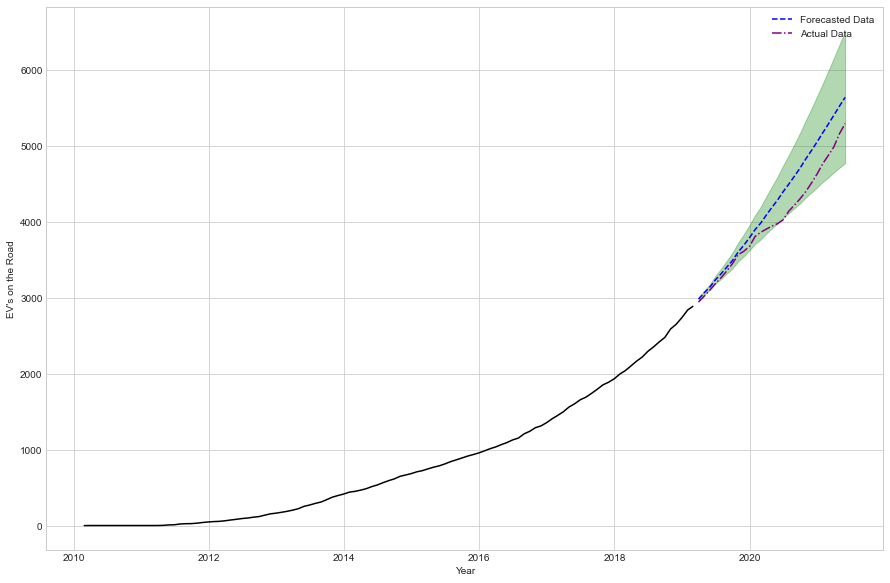

In [226]:
df_clark_forecast = get_forecast(model, train_clark, test_clark, plot=True)

### Future Predictions

#### Finding Best Parameters with Auto-Arima

In [227]:
auto_model = pm.auto_arima(county_information['Clark']['df'], start_p=0, 
                           start_q=0,d=1, max_p=4, max_q=4, max_P=3,max_Q=3, 
                           start_P=0, start_Q=0, m=12, verbose=2)
evaluate_model(auto_model)

KeyboardInterrupt: 

#### Model with Best Parameters

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  136
Model:             SARIMAX(4, 1, 0)x(2, 0, 0, 12)   Log Likelihood                -450.900
Date:                            Sat, 10 Jul 2021   AIC                            915.800
Time:                                    13:56:51   BIC                            934.510
Sample:                                02-28-2010   HQIC                           923.385
                                     - 05-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4971      0.090      5.553      0.000       0.322       0.673
ar.L2          0.1081      0.105      1.033      0.302      -0.097       0.313
ar.L3          0.1648      0.102      1.618      0.106      -0.035       0.364
ar.L4          0.2834      0.078      3.619      0.000       0.130       0.437
ar.S.L12       0.3866      0.135      2.863      0.004       0.122       0.651
ar.S.L24       0.2544      0.182      1.402      0.161      -0.101       0.610
sigma2       267.7828     20.489     13.069      0.000     227.624     307.941
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               111.76
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):              16.37   Skew:                             0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

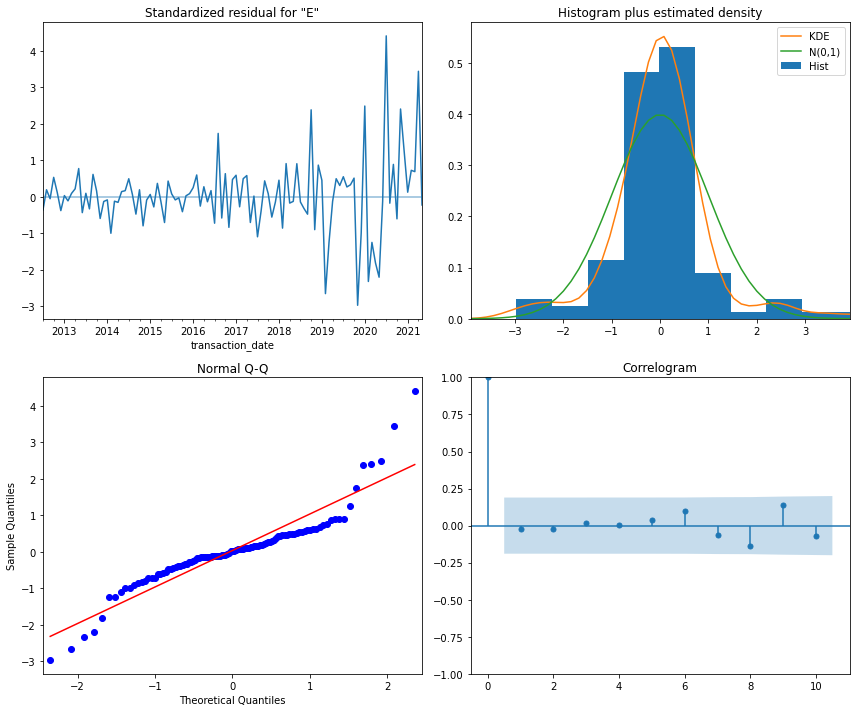

In [228]:
model = SARIMAX(county_information['Clark']['df'], order=(4,1,0), 
                seasonal_order=(2,0,0,12), enforce_invertibility=False, 
                enforce_stationarity=False).fit()
evaluate_model(model)

#### Plotting & Saving Predictions

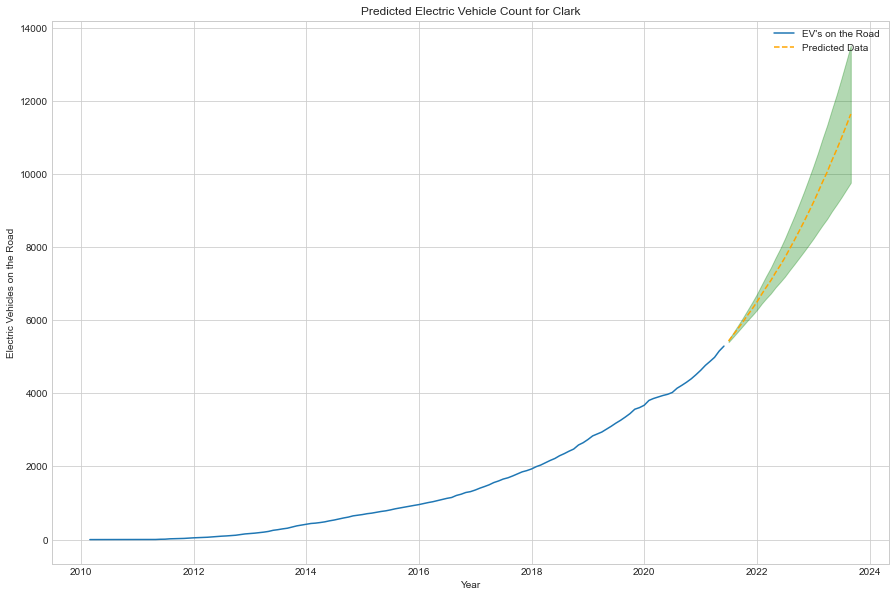

In [229]:
df_clark_preds = get_prediction(model, county_information['Clark']['df'], 
                               test_clark, 'Clark', plot=True)

In [230]:
county_information['Clark']['Predictions'] = df_clark_preds

## Thurston County

### Seasonality Check


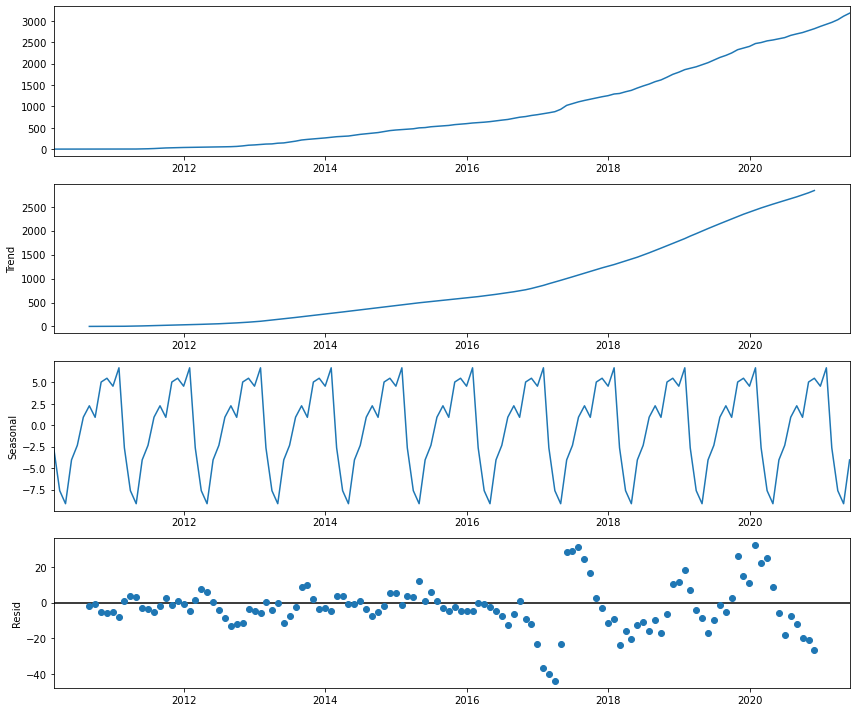

In [120]:
plt.rcParams['figure.figsize']=(12,10)
decomp = tsa.seasonal_decompose(county_information['Thurston']['df'])
decomp.plot();

The seasonal component of the time series for King county indicates only about a 200 car difference over the years which in the big picture is not much. Since we don't have a strong seasonality component, we will go ahead and use ARIMA models.

### train_test_split

In [121]:
train_thurston, test_thurston = train_test_split_ts(county_information['Thurston']['df'], 
                                            0.80, 0.20)

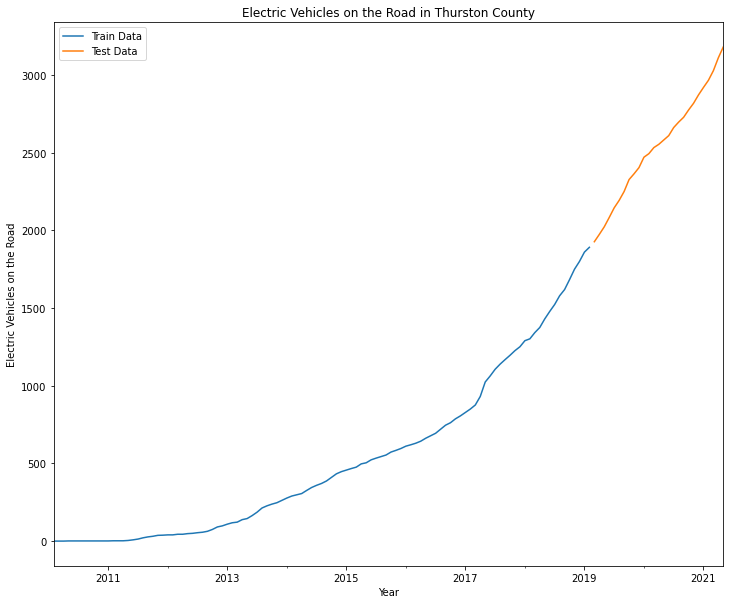

In [122]:
plot_train_test_split(train_thurston, test_thurston, 'Thurston')

### Tuning Hyperparameters with Auto-Arima

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  109
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                -396.377
Date:                             Sat, 10 Jul 2021   AIC                            802.754
Time:                                     13:22:54   BIC                            816.165
Sample:                                          0   HQIC                           808.192
                                             - 109                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9365      1.151      0.813      0.416      -1.320       3.193
ar.L1          0.9393      0.049     19.001      0.000       0.842       1.036
ma.L1         -0.4422      0.074     -5.950      0.000      -0.588      -0.297
ar.S.L12       0.1942      0.095      2.042      0.041       0.008       0.381
sigma2        88.6317      6.558     13.516      0.000      75.779     101.484
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               397.84
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):              21.49   Skew:                             1.78
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

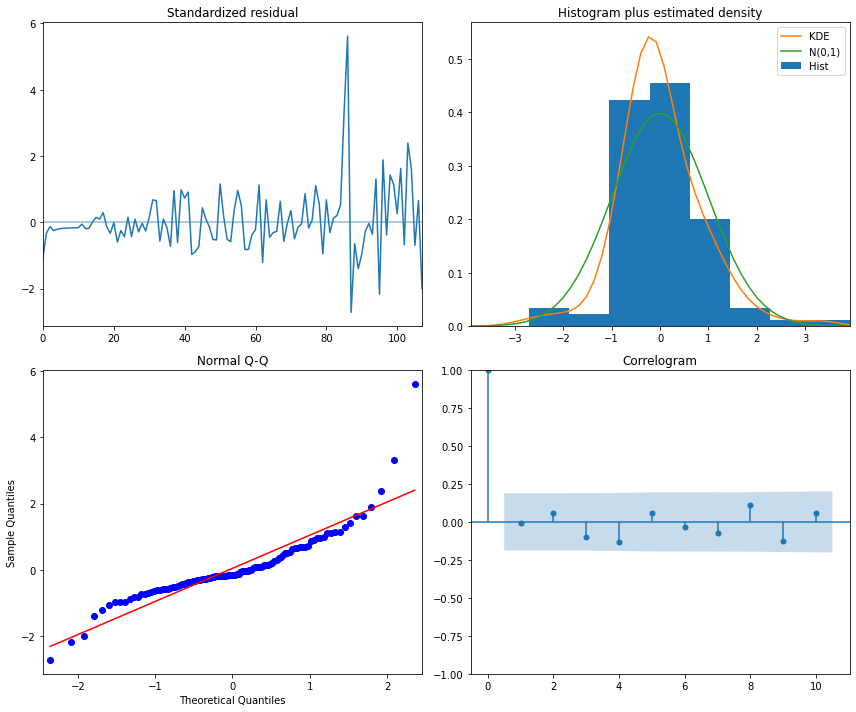

In [123]:
auto_model = pm.auto_arima(train_thurston, start_p=0, start_q=0, d=1, max_p=4, 
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0, 
                           m=12, verbose=2)
evaluate_model(auto_model)

### Model with Best Parameters

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                    EV's on the Road   No. Observations:                  109
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                -354.510
Date:                             Sat, 10 Jul 2021   AIC                            717.020
Time:                                     13:57:13   BIC                            727.235
Sample:                                 02-28-2010   HQIC                           721.148
                                      - 02-28-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9914      0.024     41.469      0.000       0.945       1.038
ma.L1         -0.5107      0.064     -8.019      0.000      -0.636      -0.386
ar.S.L12       0.2086      0.109      1.918      0.055      -0.005       0.422
sigma2       101.7330      8.384     12.134      0.000      85.300     118.166
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               230.09
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               9.21   Skew:                             1.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

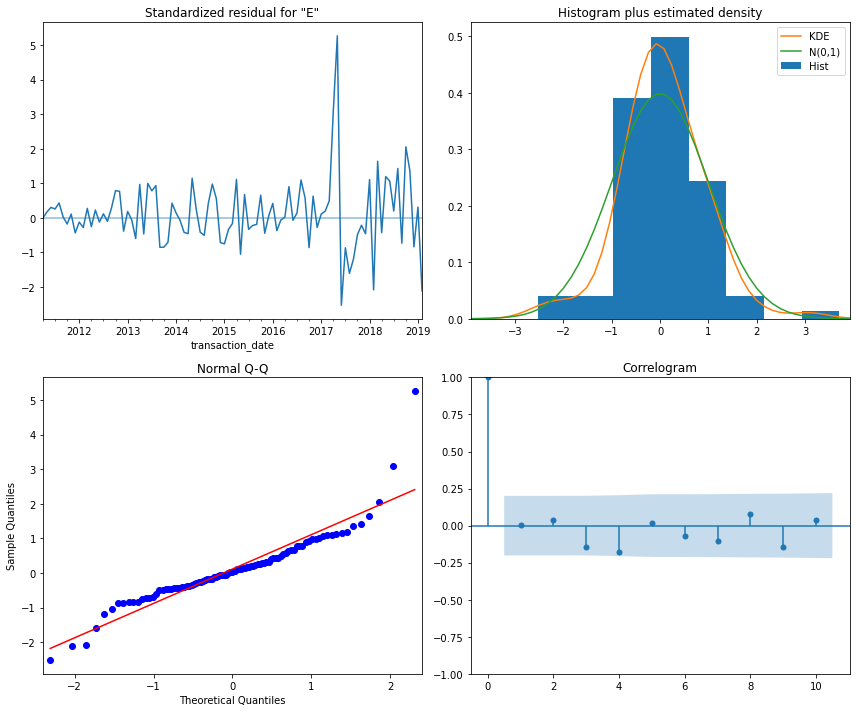

In [231]:
model = SARIMAX(train_thurston, order=(1,1,1), seasonal_order=(1,0,[],12), 
                enforce_invertibility=False, enforce_stationarity=False).fit()
evaluate_model(model)

### Validate Model with Forecasts for Test Data

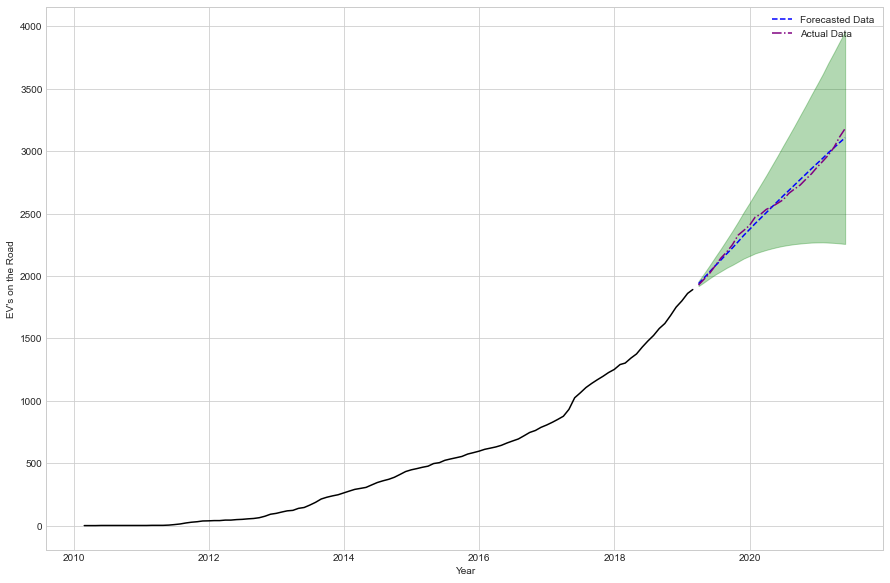

In [232]:
df_thurston_forecast = get_forecast(model, train_thurston, test_thurston, 
                                    plot=True)

### Future Predictions

#### Finding Best Parameters with Auto-Arima

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  136
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                -513.568
Date:                             Sat, 10 Jul 2021   AIC                           1035.137
Time:                                     13:23:19   BIC                           1046.758
Sample:                                          0   HQIC                          1039.859
                                             - 136                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9894      0.013     76.492      0.000       0.964       1.015
ma.L1         -0.5213      0.053     -9.871      0.000      -0.625      -0.418
ar.S.L12       0.1480      0.071      2.095      0.036       0.010       0.286
sigma2       115.1586      8.435     13.653      0.000      98.627     131.691
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               143.67
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              10.44   Skew:                             0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

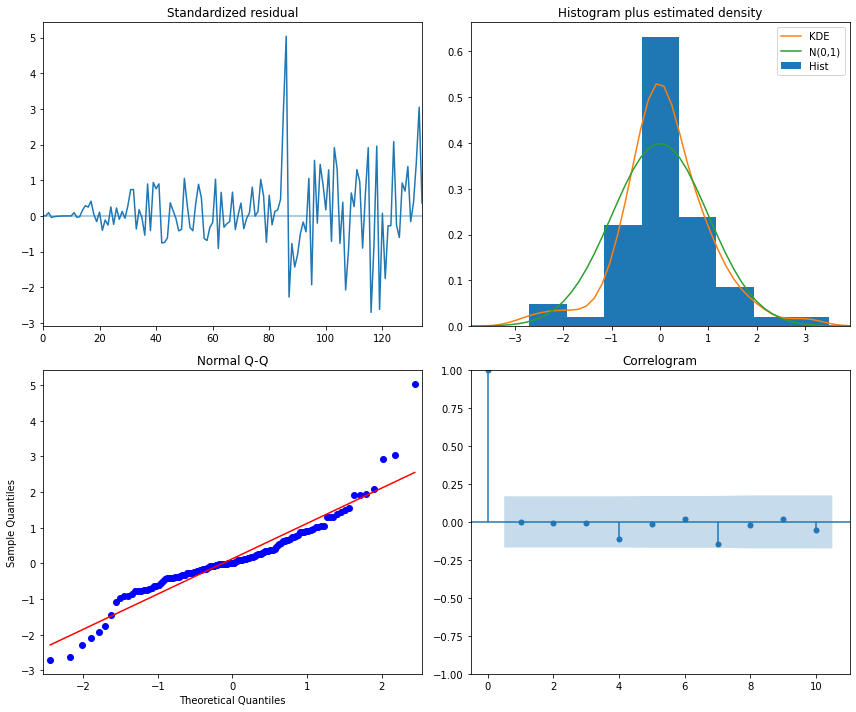

In [126]:
auto_model = pm.auto_arima(county_information['Thurston']['df'], start_p=0, 
                           start_q=0,d=1, max_p=4, max_q=4, max_P=3,max_Q=3, 
                           start_P=0, start_Q=0, m=12, verbose=2)
evaluate_model(auto_model)

#### Model with Best Parameters

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                    EV's on the Road   No. Observations:                  136
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                -468.628
Date:                             Sat, 10 Jul 2021   AIC                            945.256
Time:                                     13:57:32   BIC                            956.472
Sample:                                 02-28-2010   HQIC                           949.811
                                      - 05-31-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0045      0.015     65.642      0.000       0.974       1.034
ma.L1         -0.5388      0.058     -9.336      0.000      -0.652      -0.426
ar.S.L12       0.1574      0.078      2.007      0.045       0.004       0.311
sigma2       126.6981     10.219     12.398      0.000     106.669     146.727
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                89.96
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               7.80   Skew:                             0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

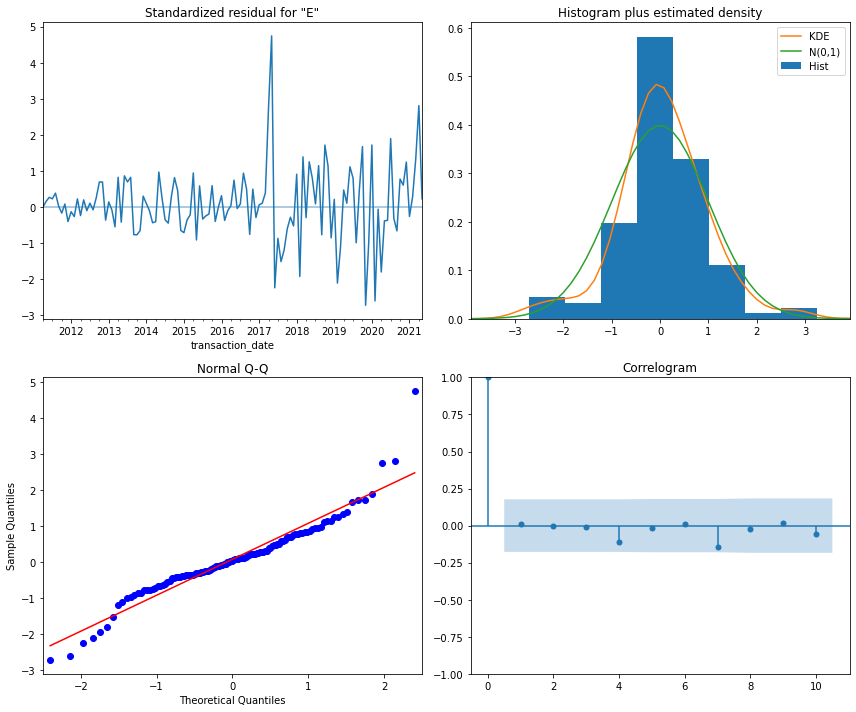

In [233]:
model = SARIMAX(county_information['Thurston']['df'], order=(1,1,1), 
                seasonal_order=(1,0,[],12), enforce_invertibility=False, 
                enforce_stationarity=False).fit()
evaluate_model(model)

#### Plotting & Saving Predictions

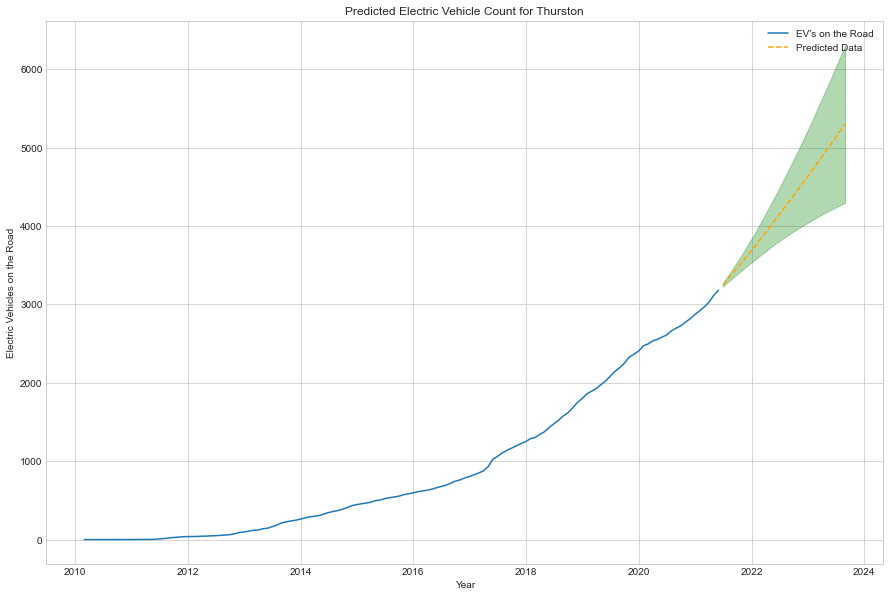

In [234]:
df_thurston_preds = get_prediction(model, county_information['Thurston']['df'], 
                               test_thurston, 'Thurston', plot=True)

In [235]:
county_information['Thurston']['Predictions'] = df_thurston_preds

## Kitsap County

In [130]:
train_kitsap, test_kitsap = train_test_split_ts(county_information['Kitsap']['df'], 
                                            0.80, 0.20)

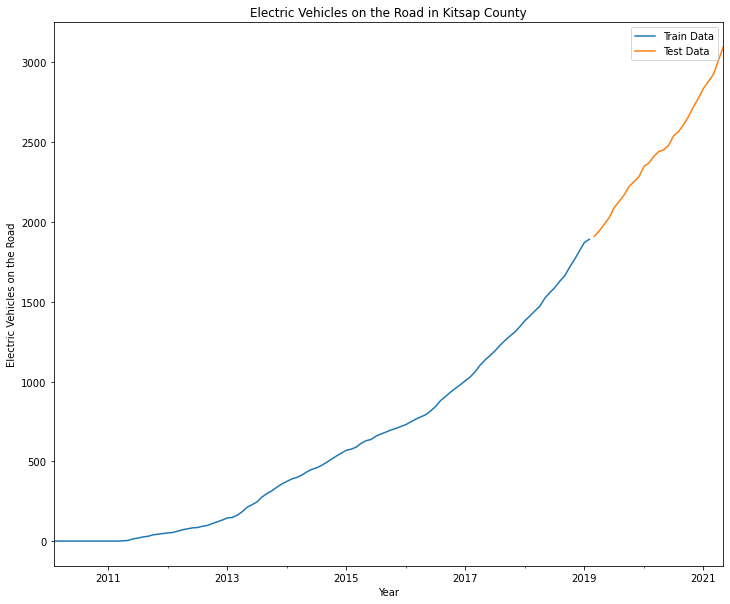

In [131]:
plot_train_test_split(train_kitsap, test_kitsap, 'Kitsap')

### Tuning Hyperparameters with Auto-Arima

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  109
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -348.618
Date:                Sat, 10 Jul 2021   AIC                            709.237
Time:                        13:23:31   BIC                            725.330
Sample:                             0   HQIC                           715.762
                                - 109                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3260      0.738      0.442      0.659      -1.121       1.773
ar.L1          0.3353      0.168      1.997      0.046       0.006       0.664
ar.L2          0.6471      0.146      4.442      0.000       0.362       0.933
ma.L1          0.2136      0.150      1.420      0.156      -0.081       0.508
ma.L2         -0.5818      0.101     -5.784      0.000      -0.779      -0.385
sigma2        36.3520      3.482     10.441      0.000      29.528      43.176
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                86.52
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               5.53   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

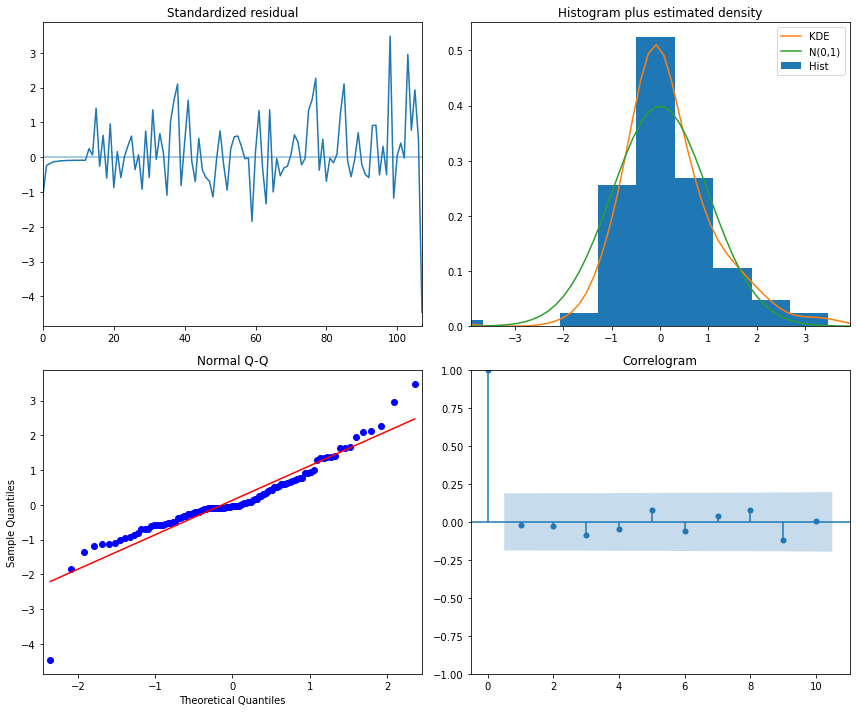

In [132]:
auto_model = pm.auto_arima(train_kitsap, start_p=0, start_q=0, d=1, max_p=4, 
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0, 
                           m=12, verbose=2)
evaluate_model(auto_model)

### Model with Best Parameters

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       EV's on the Road   No. Observations:                  109
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -338.026
Date:                Sat, 10 Jul 2021   AIC                            686.053
Time:                        13:57:49   BIC                            699.323
Sample:                    02-28-2010   HQIC                           691.430
                         - 02-28-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4327      0.175      2.476      0.013       0.090       0.775
ar.L2          0.5920      0.172      3.443      0.001       0.255       0.929
ma.L1          0.0651      0.156      0.418      0.676      -0.240       0.371
ma.L2         -0.6563      0.108     -6.088      0.000      -0.868      -0.445
sigma2        36.3461      3.688      9.854      0.000      29.117      43.575
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                84.14
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               4.37   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

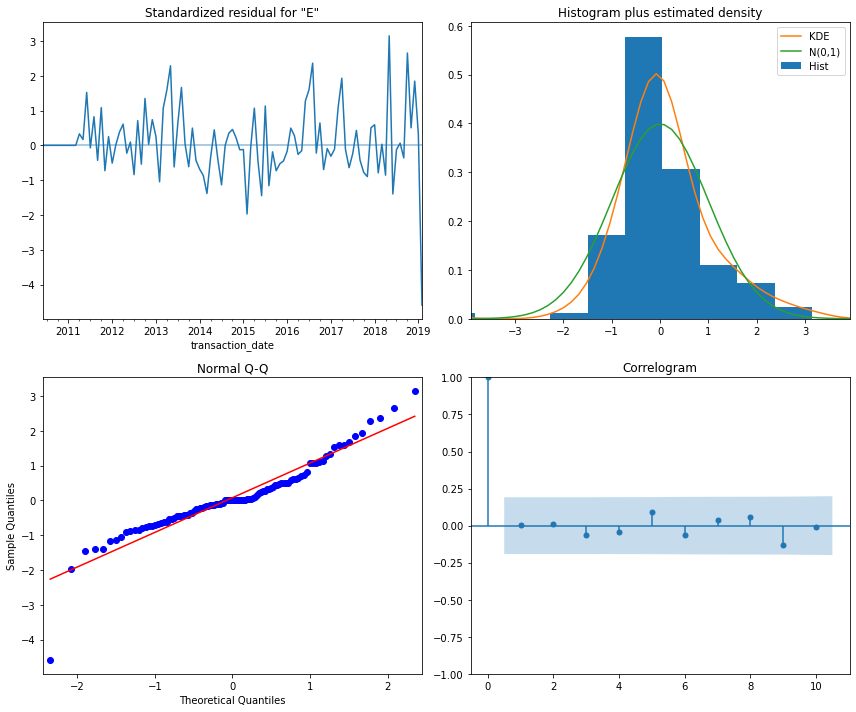

In [236]:
model = SARIMAX(train_kitsap, order=(2,1,2), enforce_invertibility=False, 
                enforce_stationarity=False).fit()
evaluate_model(model)

### Validate Model with Forecasts for Test Data

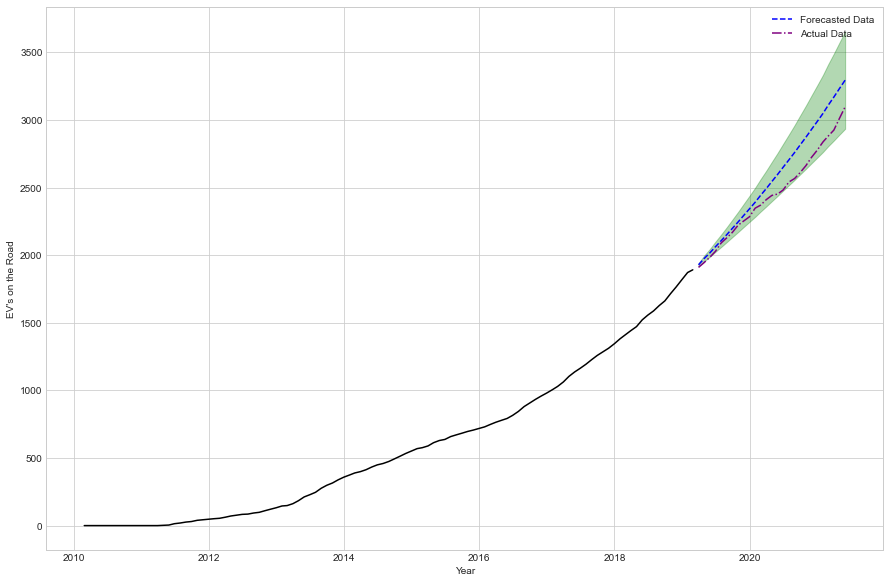

In [237]:
df_kitsap_forecast = get_forecast(model, train_kitsap, test_kitsap, plot=True)

### Future Predictions

#### Finding Best Parameters with Auto-Arima

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  136
Model:               SARIMAX(3, 1, 0)   Log Likelihood                -493.991
Date:                Sat, 10 Jul 2021   AIC                            997.981
Time:                        13:58:05   BIC                           1012.508
Sample:                             0   HQIC                          1003.884
                                - 136                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0429      1.820      0.573      0.567      -2.524       4.609
ar.L1          0.5106      0.053      9.660      0.000       0.407       0.614
ar.L2          0.0583      0.070      0.832      0.405      -0.079       0.195
ar.L3          0.3960      0.062      6.377      0.000       0.274       0.518
sigma2        86.6350      7.278     11.904      0.000      72.371     100.899
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                45.56
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              10.41   Skew:                             0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

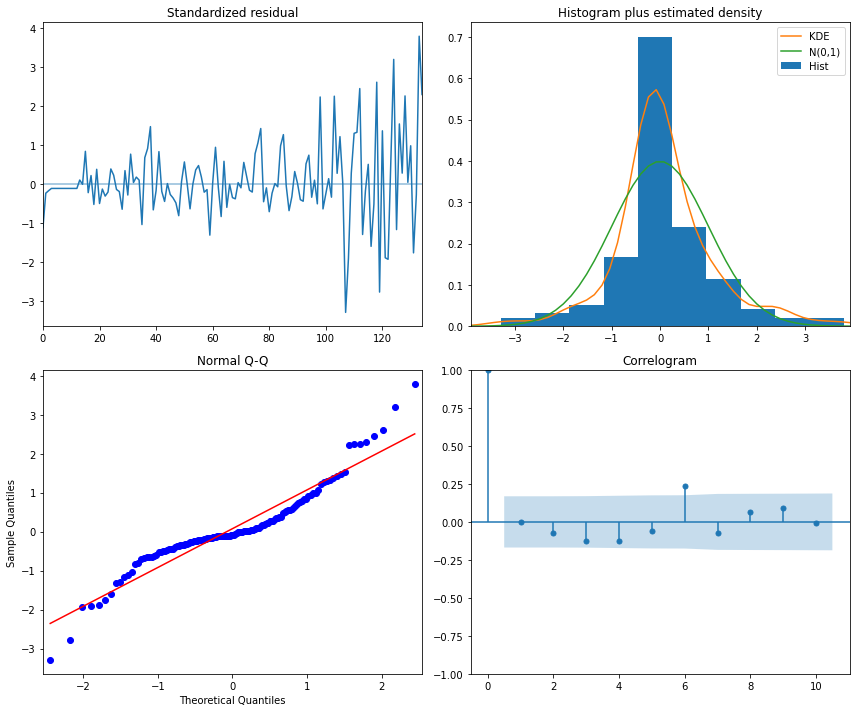

In [238]:
auto_model = pm.auto_arima(county_information['Kitsap']['df'], start_p=0, 
                           start_q=0,d=1, max_p=4, max_q=4, max_P=3,max_Q=3, 
                           start_P=0, start_Q=0, m=12, verbose=2)
evaluate_model(auto_model)

#### Model with Best Parameters

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       EV's on the Road   No. Observations:                  136
Model:               SARIMAX(3, 1, 0)   Log Likelihood                -482.645
Date:                Sat, 10 Jul 2021   AIC                            973.289
Time:                        13:58:07   BIC                            984.821
Sample:                    02-28-2010   HQIC                           977.975
                         - 05-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5187      0.052      9.886      0.000       0.416       0.622
ar.L2          0.0770      0.069      1.119      0.263      -0.058       0.212
ar.L3          0.4312      0.061      7.080      0.000       0.312       0.551
sigma2        87.7877      7.413     11.843      0.000      73.259     102.316
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                36.65
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):              11.06   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

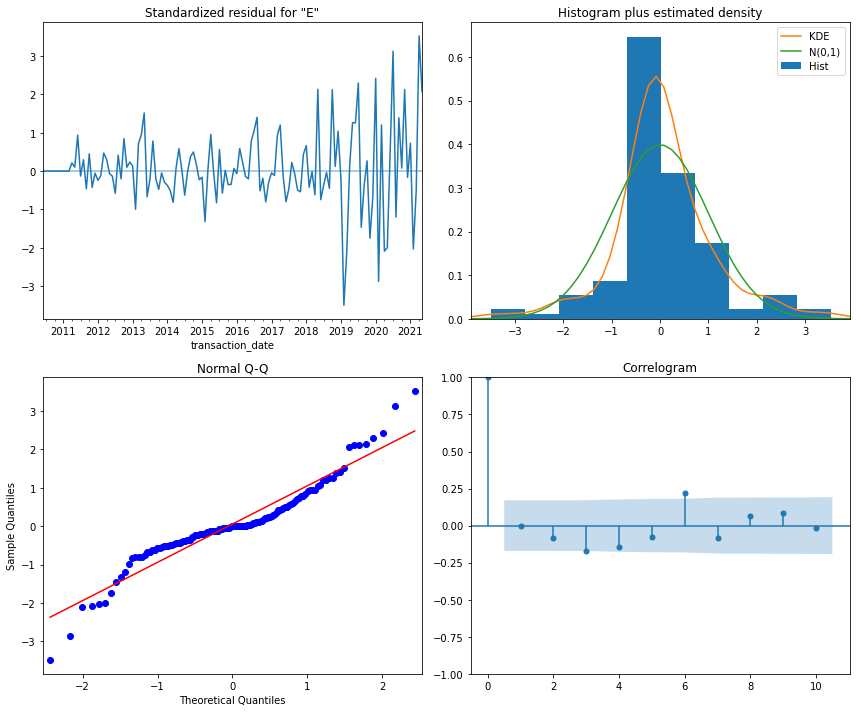

In [239]:
model = SARIMAX(county_information['Kitsap']['df'], order=(3,1,0), 
                enforce_invertibility=False, enforce_stationarity=False).fit()
evaluate_model(model)

#### Plotting & Saving Predictions

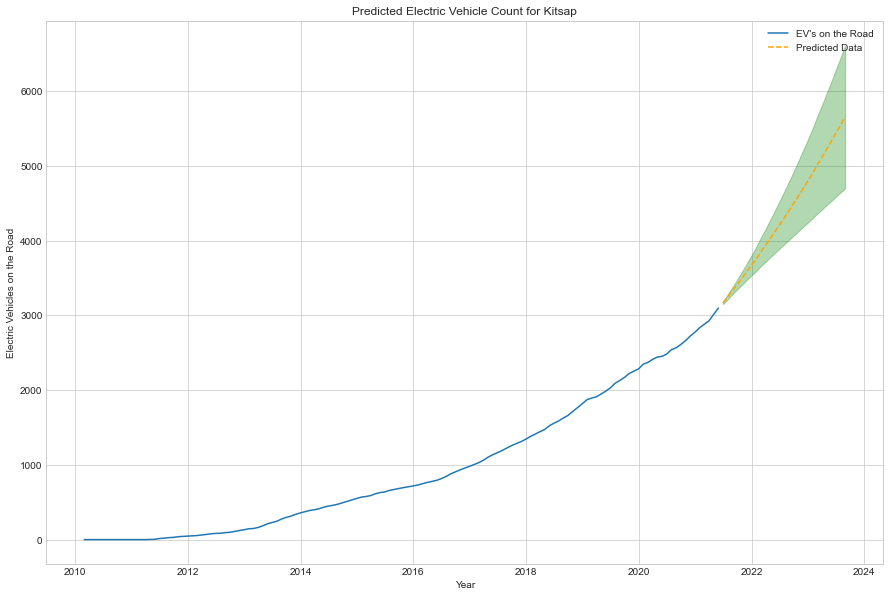

In [240]:
df_kitsap_preds = get_prediction(model, county_information['Kitsap']['df'], 
                               test_kitsap, 'Kitsap', plot=True)

In [241]:
county_information['Kitsap']['Predictions'] = df_kitsap_preds

## Whatcom County

In [139]:
train_whatcom, test_whatcom = train_test_split_ts(county_information['Whatcom']['df'], 
                                            0.80, 0.20)

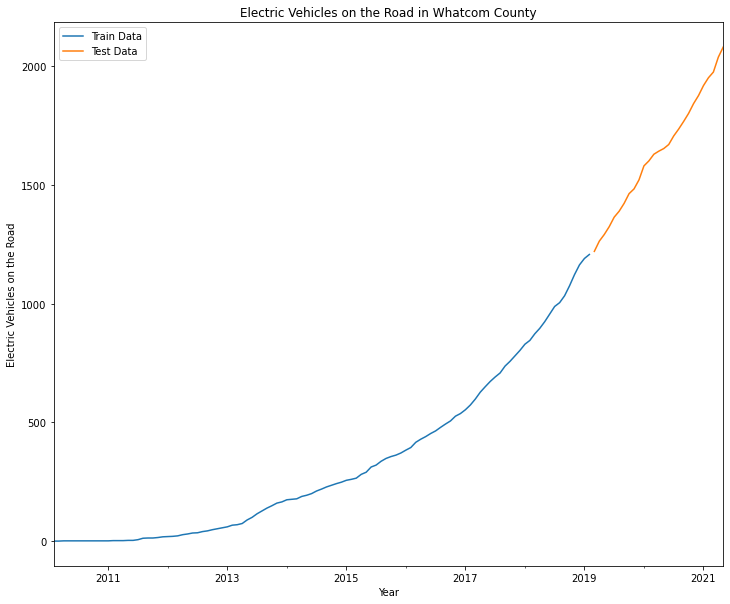

In [140]:
plot_train_test_split(train_whatcom, test_whatcom, 'Whatcom')

### Tuning Hyperparameters with Auto-Arima

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  109
Model:             SARIMAX(2, 1, 1)x(1, 0, [], 12)   Log Likelihood                -325.252
Date:                             Sat, 10 Jul 2021   AIC                            660.504
Time:                                     13:23:52   BIC                            673.915
Sample:                                          0   HQIC                           665.942
                                             - 109                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3022      0.117     11.110      0.000       1.072       1.532
ar.L2         -0.3044      0.114     -2.659      0.008      -0.529      -0.080
ma.L1         -0.8144      0.087     -9.327      0.000      -0.986      -0.643
ar.S.L12       0.1759      0.114      1.543      0.123      -0.048       0.400
sigma2        23.3444      2.524      9.249      0.000      18.397      28.291
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                13.25
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):              19.21   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

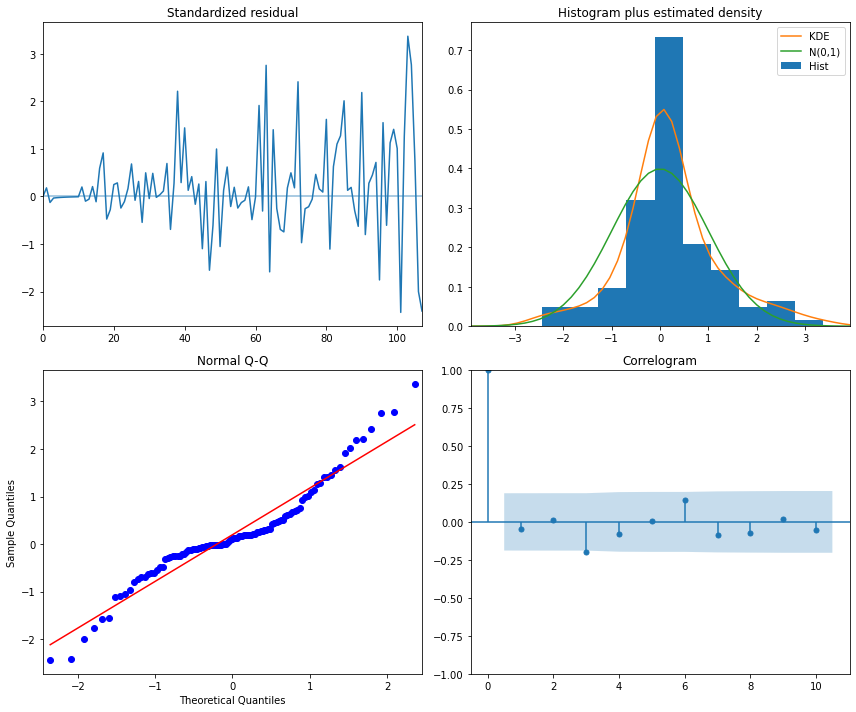

In [141]:
auto_model = pm.auto_arima(train_whatcom, start_p=0, start_q=0, d=1, max_p=4, 
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0, 
                           m=12, verbose=2)
evaluate_model(auto_model)

### Model with Best Parameters

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                    EV's on the Road   No. Observations:                  109
Model:             SARIMAX(2, 1, 1)x(1, 0, [], 12)   Log Likelihood                -283.478
Date:                             Sat, 10 Jul 2021   AIC                            576.956
Time:                                     13:58:26   BIC                            589.672
Sample:                                 02-28-2010   HQIC                           582.092
                                      - 02-28-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2769      0.116     11.021      0.000       1.050       1.504
ar.L2         -0.2577      0.119     -2.167      0.030      -0.491      -0.025
ma.L1         -0.9970      0.575     -1.733      0.083      -2.125       0.131
ar.S.L12       0.1638      0.149      1.099      0.272      -0.128       0.456
sigma2        24.6014     14.936      1.647      0.100      -4.672      53.875
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 5.17
Prob(Q):                              0.73   Prob(JB):                         0.08
Heteroskedasticity (H):               4.37   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

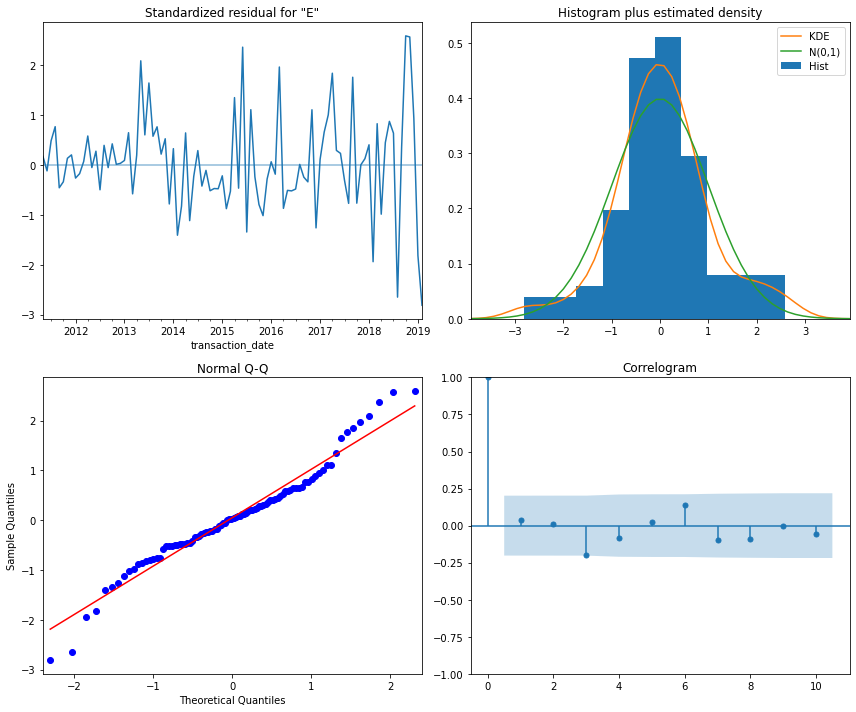

In [242]:
model = SARIMAX(train_whatcom, order=(2,1,1), seasonal_order=(1,0,[],12), 
                enforce_invertibility=False, enforce_stationarity=False).fit()
evaluate_model(model)

### Validate Model with Forecasts for Test Data

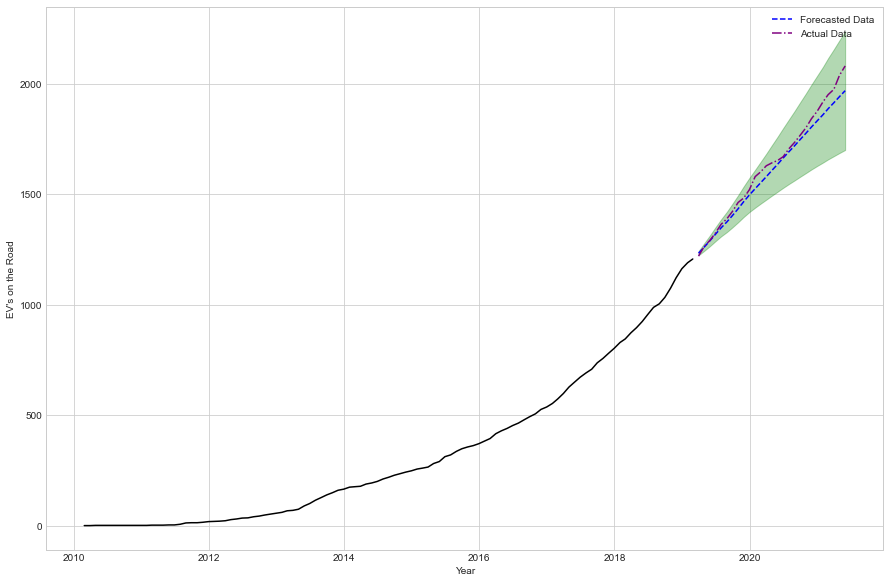

In [143]:
df_whatcom_forecast = get_forecast(model, train_whatcom, test_whatcom, plot=True)

### Future Predictions

#### Finding Best Parameters with Auto-Arima

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  136
Model:             SARIMAX(4, 1, 4)x(1, 0, [1, 2], 12)   Log Likelihood                -438.999
Date:                                 Sat, 10 Jul 2021   AIC                            903.999
Time:                                         13:26:33   BIC                            941.767
Sample:                                              0   HQIC                           919.347
                                                 - 136                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2978      1.124      0.265      0.791      -1.905       2.501
ar.L1          0.4294      0.233      1.845      0.065      -0.027       0.886
ar.L2         -0.1205      0.078     -1.542      0.123      -0.274       0.033
ar.L3          0.9752      0.073     13.329      0.000       0.832       1.119
ar.L4         -0.2939      0.236     -1.243      0.214      -0.757       0.169
ma.L1          0.0408      0.256      0.160      0.873      -0.460       0.542
ma.L2          0.3466      0.100      3.472      0.001       0.151       0.542
ma.L3         -0.7149      0.174     -4.115      0.000      -1.055      -0.374
ma.L4         -0.1652      0.187     -0.883      0.377      -0.532       0.202
ar.S.L12      -0.7888      0.454     -1.738      0.082      -1.679       0.101
ma.S.L12       0.6262      0.478      1.311      0.190      -0.310       1.562
ma.S.L24       0.1419      0.175      0.809      0.418      -0.202       0.486
sigma2        36.5504      5.454      6.701      0.000      25.860      47.241
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                12.51
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):              12.95   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

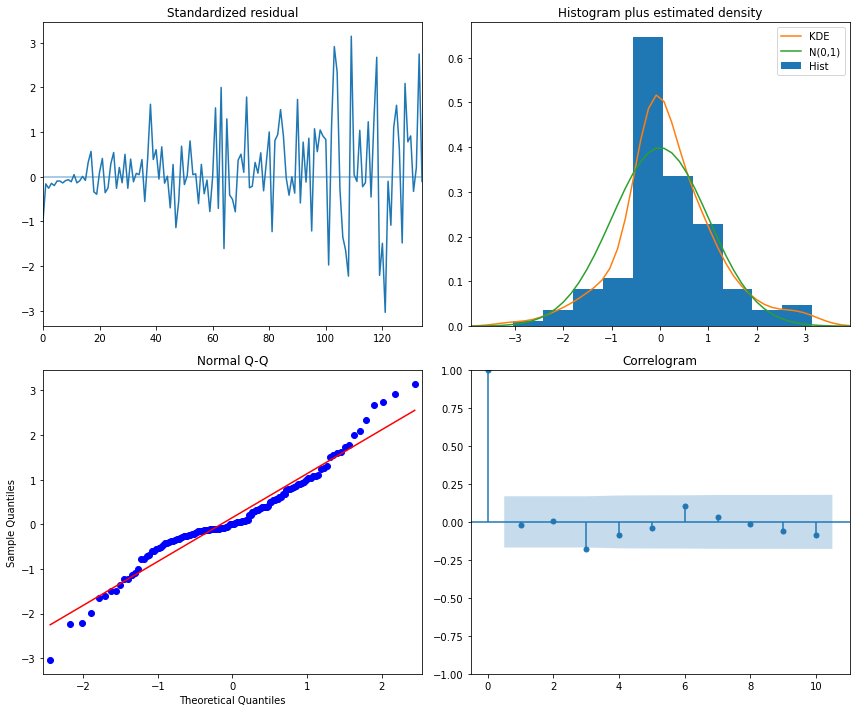

In [144]:
auto_model = pm.auto_arima(county_information['Whatcom']['df'], start_p=0, 
                           start_q=0,d=1, max_p=4, max_q=4, max_P=3,max_Q=3, 
                           start_P=0, start_Q=0, m=12, verbose=2)
evaluate_model(auto_model)

#### Model with Best Parameters

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                        EV's on the Road   No. Observations:                  136
Model:             SARIMAX(4, 1, 4)x(1, 0, [1, 2], 12)   Log Likelihood                -352.833
Date:                                 Sat, 10 Jul 2021   AIC                            729.667
Time:                                         13:58:40   BIC                            761.628
Sample:                                     02-28-2010   HQIC                           742.621
                                          - 05-31-2021                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5026      0.180      2.790      0.005       0.149       0.856
ar.L2         -0.0862      0.077     -1.126      0.260      -0.236       0.064
ar.L3          0.9181      0.054     17.042      0.000       0.812       1.024
ar.L4         -0.3084      0.173     -1.779      0.075      -0.648       0.031
ma.L1         -0.0553      4.201     -0.013      0.989      -8.289       8.178
ma.L2          0.3542     11.972      0.030      0.976     -23.111      23.819
ma.L3         -0.7960     10.518     -0.076      0.940     -21.412      19.820
ma.L4         -0.2787      4.050     -0.069      0.945      -8.216       7.658
ar.S.L12      -0.9272      0.165     -5.633      0.000      -1.250      -0.605
ma.S.L12       0.7096      0.203      3.493      0.000       0.311       1.108
ma.S.L24       0.1983      0.133      1.493      0.135      -0.062       0.459
sigma2        39.5345    578.166      0.068      0.945   -1093.649    1172.718
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.30
Prob(Q):                              0.92   Prob(JB):                         0.52
Heteroskedasticity (H):               4.53   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

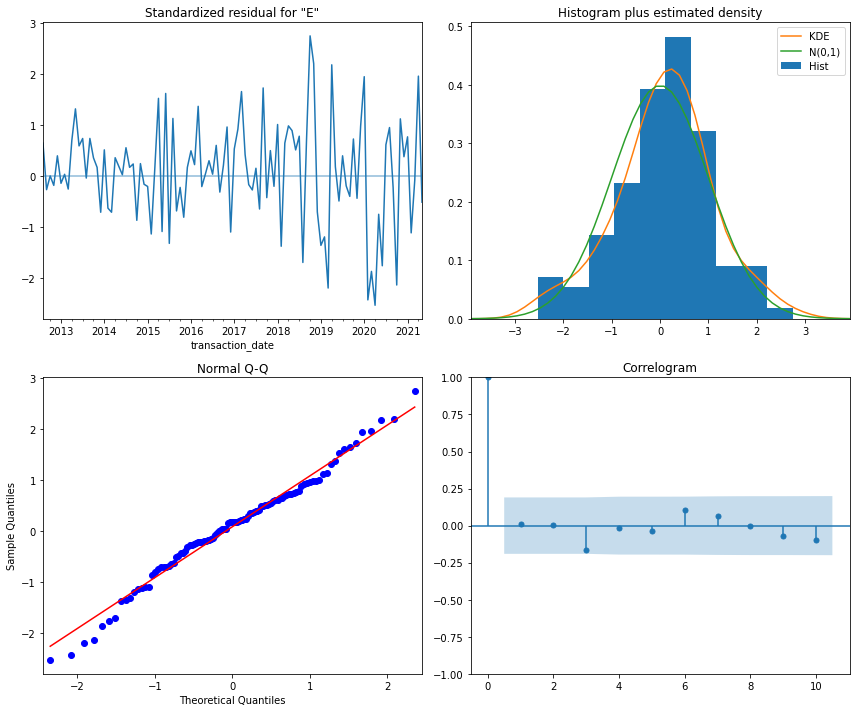

In [243]:
model = SARIMAX(county_information['Whatcom']['df'], order=(4,1,4), 
                seasonal_order=(1,0,[1,2],12), enforce_invertibility=False, 
                enforce_stationarity=False).fit(maxiter=125)
evaluate_model(model)

#### Plotting & Saving Predictions

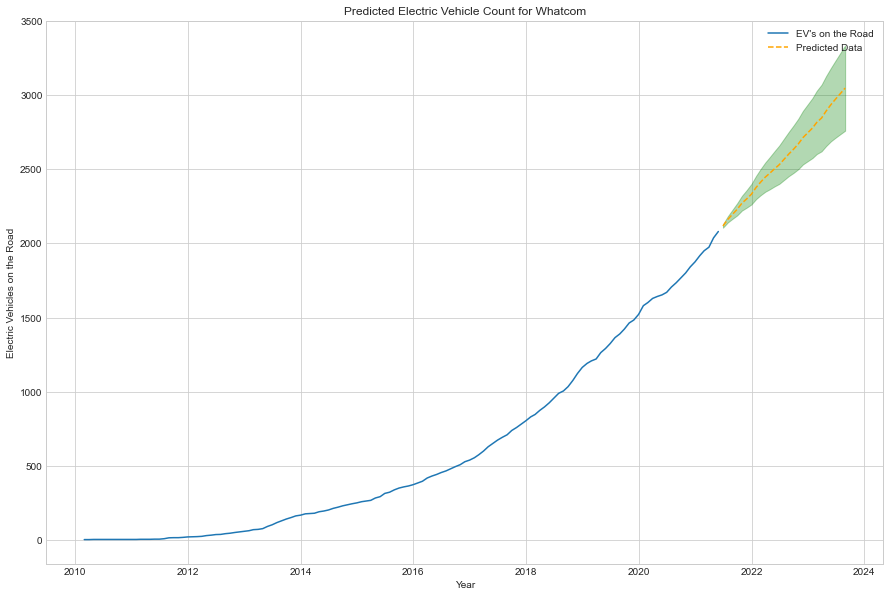

In [146]:
df_whatcom_preds = get_prediction(model, county_information['Whatcom']['df'], 
                               test_whatcom, 'Whatcom', plot=True)

In [147]:
county_information['Whatcom']['Predictions'] = df_whatcom_preds

## Spokane County

In [148]:
train_spokane, test_spokane = train_test_split_ts(county_information['Spokane']['df'], 
                                            0.80, 0.20)

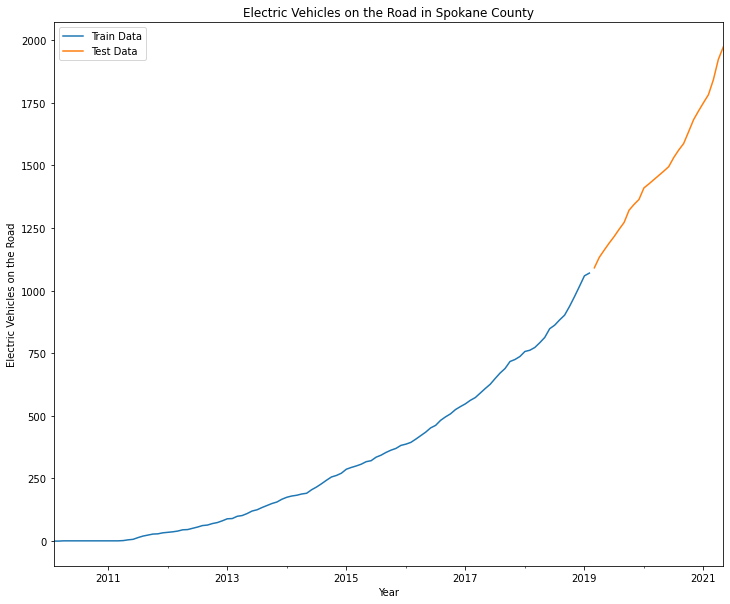

In [149]:
plot_train_test_split(train_spokane, test_spokane, 'Spokane')

### Tuning Hyperparameters with Auto-Arima

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  109
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -337.727
Date:                Sat, 10 Jul 2021   AIC                            681.453
Time:                        13:26:47   BIC                            689.500
Sample:                             0   HQIC                           684.716
                                - 109                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9955      0.009    105.551      0.000       0.977       1.014
ma.L1         -0.6912      0.051    -13.474      0.000      -0.792      -0.591
sigma2        29.6154      2.500     11.845      0.000      24.715      34.516
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               111.36
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              18.60   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

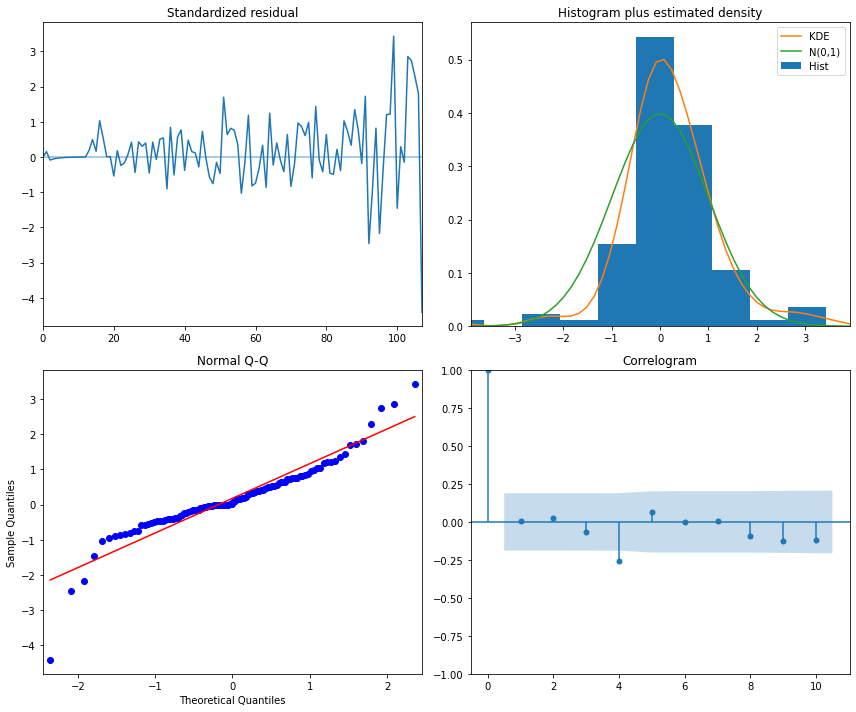

In [150]:
auto_model = pm.auto_arima(train_spokane, start_p=0, start_q=0, d=1, max_p=4, 
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0, 
                           m=12, verbose=2)
evaluate_model(auto_model)

### Model with Best Parameters

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       EV's on the Road   No. Observations:                  109
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -326.639
Date:                Sat, 10 Jul 2021   AIC                            659.278
Time:                        13:58:51   BIC                            667.268
Sample:                    02-28-2010   HQIC                           662.516
                         - 02-28-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0246      0.001   1014.331      0.000       1.023       1.027
ma.L1         -1.0000     91.441     -0.011      0.991    -180.221     178.221
sigma2        26.7756   2448.799      0.011      0.991   -4772.783    4826.334
===================================================================================
Ljung-Box (L1) (Q):                   3.05   Jarque-Bera (JB):                23.47
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):              11.41   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

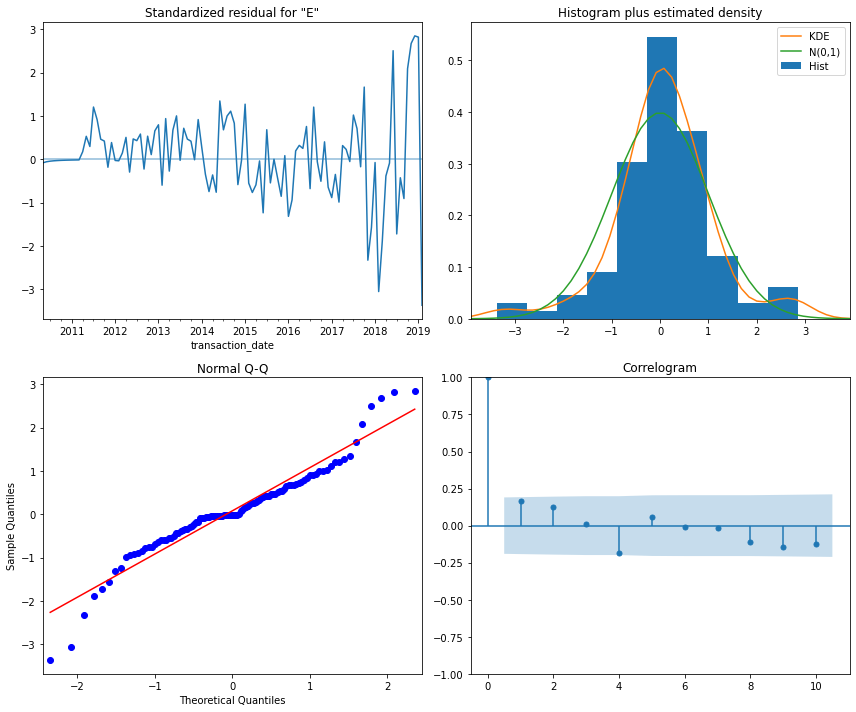

In [244]:
model = SARIMAX(train_spokane, order=(1,1,1), enforce_invertibility=False, 
                enforce_stationarity=False).fit()
evaluate_model(model)

### Validate Model with Forecasts for Test Data

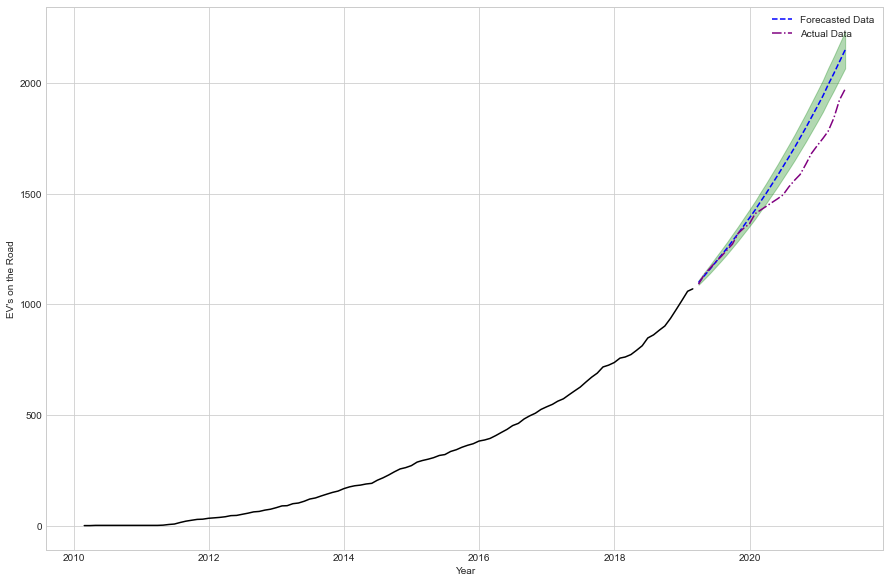

In [245]:
df_spokane_forecast = get_forecast(model, train_spokane, test_spokane, plot=True)

### Future Predictions

#### Finding Best Parameters with Auto-Arima

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  136
Model:             SARIMAX(1, 1, 2)x(2, 0, [], 12)   Log Likelihood                -461.866
Date:                             Sat, 10 Jul 2021   AIC                            935.733
Time:                                     13:27:51   BIC                            953.164
Sample:                                          0   HQIC                           942.816
                                             - 136                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9966      0.007    150.923      0.000       0.984       1.010
ma.L1         -0.4723      0.077     -6.133      0.000      -0.623      -0.321
ma.L2         -0.3069      0.103     -2.992      0.003      -0.508      -0.106
ar.S.L12       0.0699      0.075      0.927      0.354      -0.078       0.218
ar.S.L24       0.3974      0.089      4.444      0.000       0.222       0.573
sigma2        51.6056      4.886     10.562      0.000      42.029      61.182
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                60.90
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):              22.75   Skew:                             0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

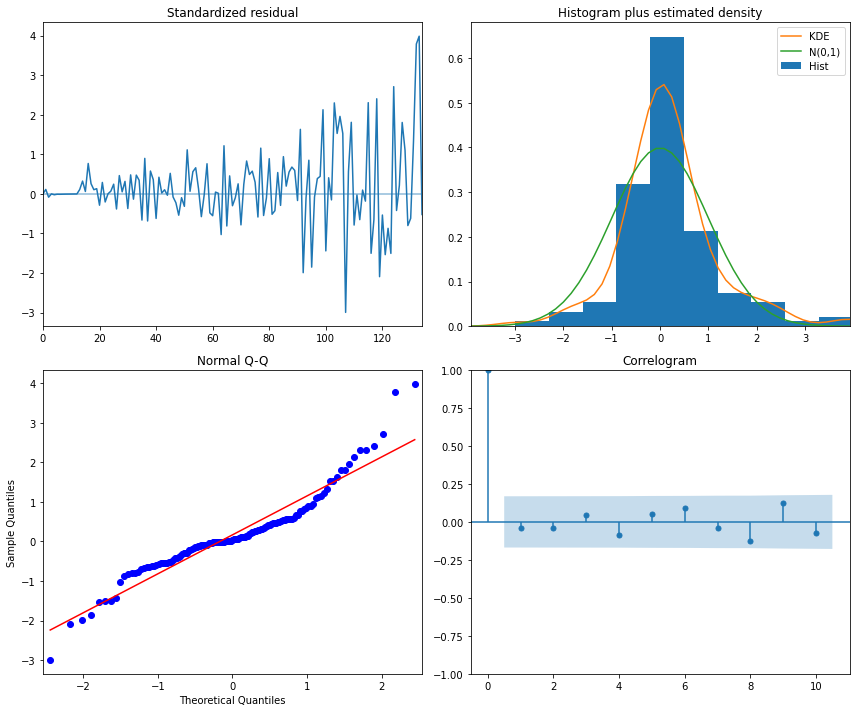

In [153]:
auto_model = pm.auto_arima(county_information['Spokane']['df'], start_p=0, 
                           start_q=0,d=1, max_p=4, max_q=4, max_P=3,max_Q=3, 
                           start_P=0, start_Q=0, m=12, verbose=2)
evaluate_model(auto_model)

#### Model with Best Parameters

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                    EV's on the Road   No. Observations:                  136
Model:             SARIMAX(1, 1, 2)x(2, 0, [], 12)   Log Likelihood                -379.154
Date:                             Sat, 10 Jul 2021   AIC                            770.309
Time:                                     13:59:15   BIC                            786.512
Sample:                                 02-28-2010   HQIC                           776.881
                                      - 05-31-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0193      0.002    466.214      0.000       1.015       1.024
ma.L1         -0.6190    166.187     -0.004      0.997    -326.339     325.101
ma.L2         -0.3810     63.367     -0.006      0.995    -124.579     123.817
ar.S.L12       0.0046      0.087      0.053      0.958      -0.165       0.174
ar.S.L24       0.5238      0.103      5.087      0.000       0.322       0.726
sigma2        55.5581   9235.966      0.006      0.995    -1.8e+04    1.82e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 7.98
Prob(Q):                              0.87   Prob(JB):                         0.02
Heteroskedasticity (H):              12.50   Skew:                             0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

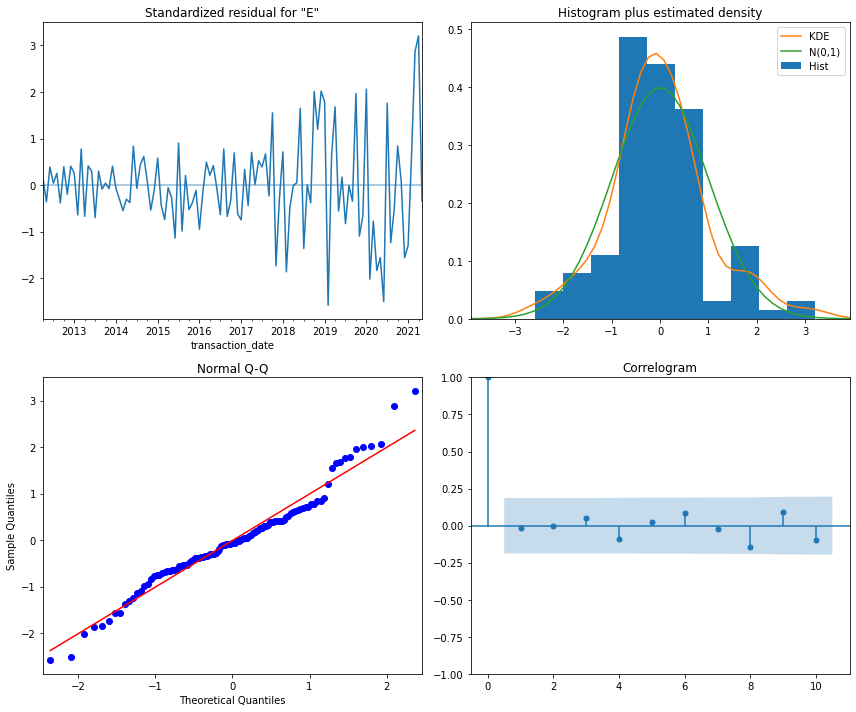

In [246]:
model = SARIMAX(county_information['Spokane']['df'], order=(1,1,2), 
                seasonal_order=(2,0,[],12), enforce_invertibility=False, 
                enforce_stationarity=False).fit(maxiter=125)
evaluate_model(model)

#### Plotting & Saving Predictions

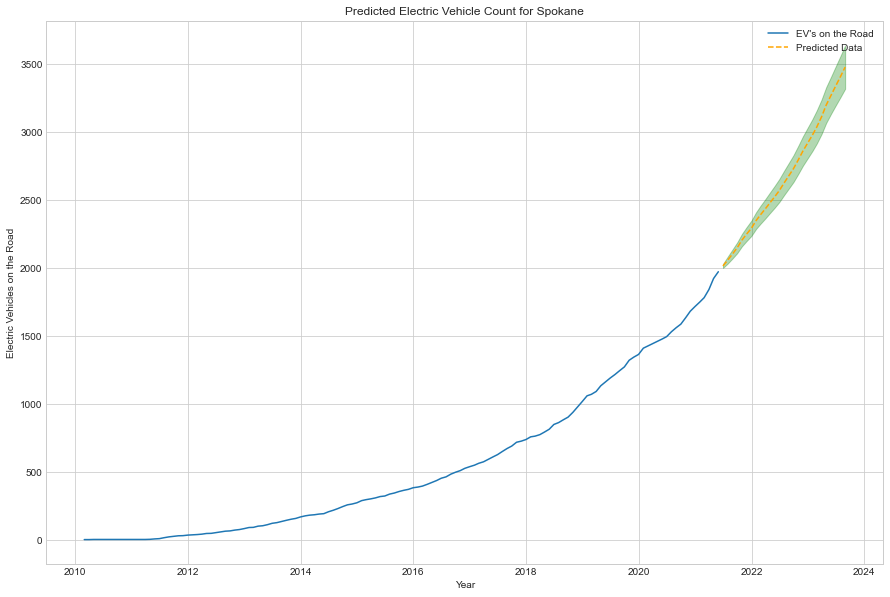

In [247]:
df_spokane_preds = get_prediction(model, county_information['Spokane']['df'], 
                               test_spokane, 'Spokane', plot=True)

In [248]:
county_information['Spokane']['Predictions'] = df_spokane_preds

## Benton County

In [157]:
train_benton, test_benton = train_test_split_ts(county_information['Benton']['df'], 
                                            0.80, 0.20)

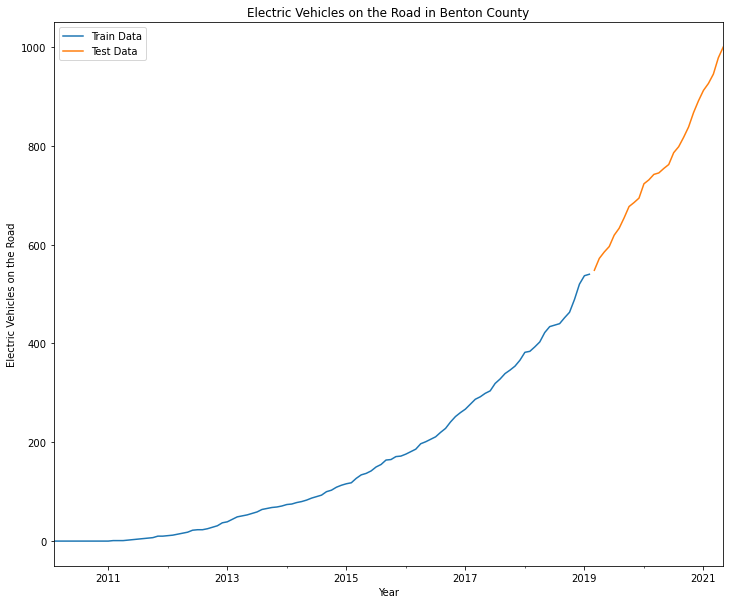

In [158]:
plot_train_test_split(train_benton, test_benton, 'Benton')

### Tuning Hyperparameters with Auto-Arima

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  109
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -300.334
Date:                Sat, 10 Jul 2021   AIC                            606.669
Time:                        13:27:55   BIC                            614.715
Sample:                             0   HQIC                           609.931
                                - 109                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.5805      0.690      2.291      0.022       0.228       2.932
ar.L1          0.6755      0.052     13.002      0.000       0.574       0.777
sigma2        15.1540      1.369     11.066      0.000      12.470      17.838
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                87.69
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):              11.50   Skew:                             1.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

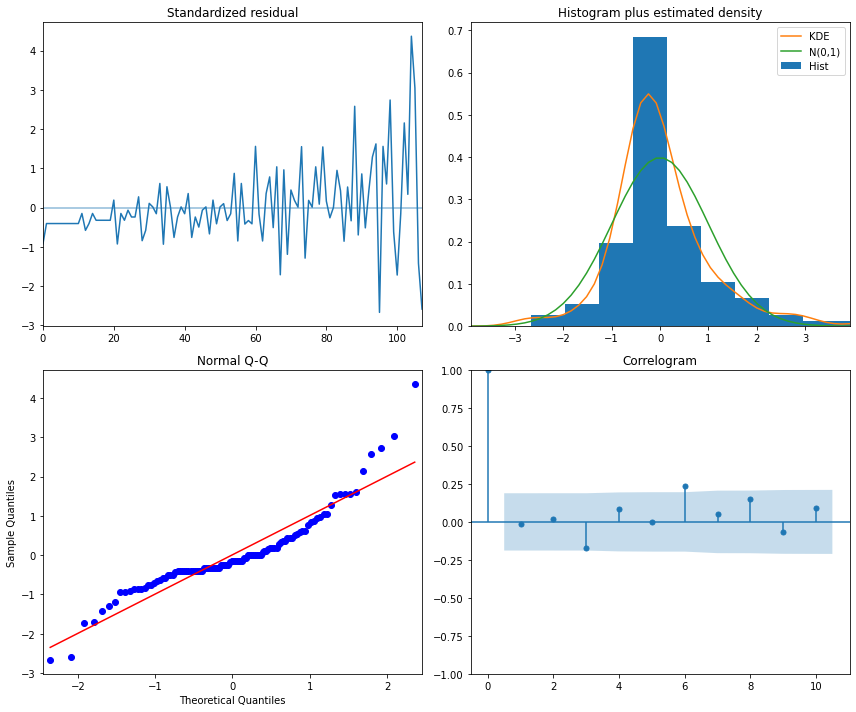

In [159]:
auto_model = pm.auto_arima(train_benton, start_p=0, start_q=0, d=1, max_p=4, 
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0, 
                           m=12, verbose=2)
evaluate_model(auto_model)

### Model with Best Parameters

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       EV's on the Road   No. Observations:                  109
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -302.182
Date:                Sat, 10 Jul 2021   AIC                            608.364
Time:                        13:59:36   BIC                            613.710
Sample:                    02-28-2010   HQIC                           610.531
                         - 02-28-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8312      0.031     26.863      0.000       0.771       0.892
sigma2        16.6163      1.425     11.657      0.000      13.822      19.410
===================================================================================
Ljung-Box (L1) (Q):                   2.20   Jarque-Bera (JB):                47.25
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):              21.32   Skew:                             0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

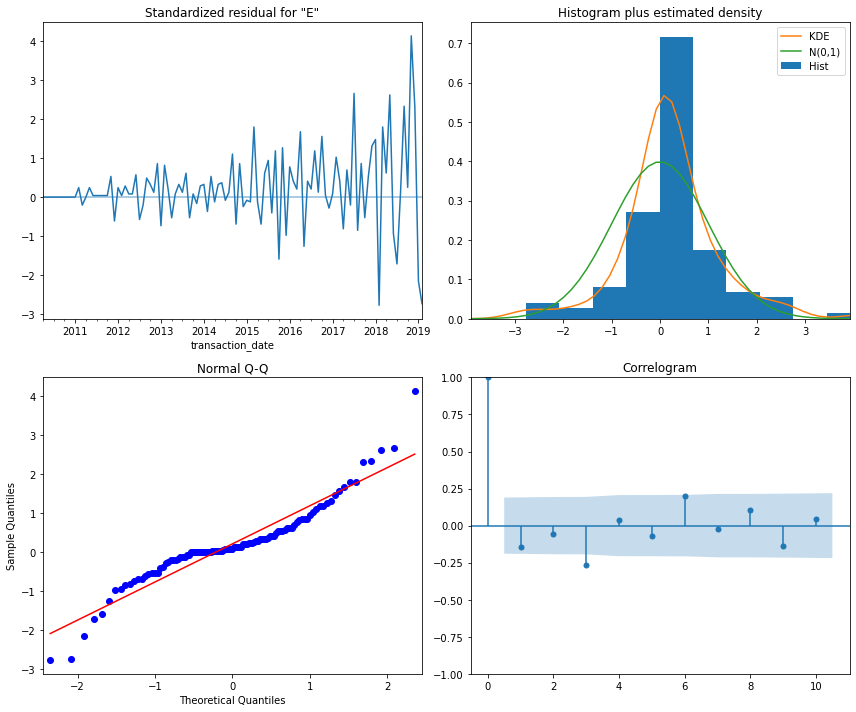

In [249]:
model = SARIMAX(train_benton, order=(1,1,0), enforce_invertibility=False, 
                enforce_stationarity=False).fit()
evaluate_model(model)

### Validate Model with Forecasts for Test Data

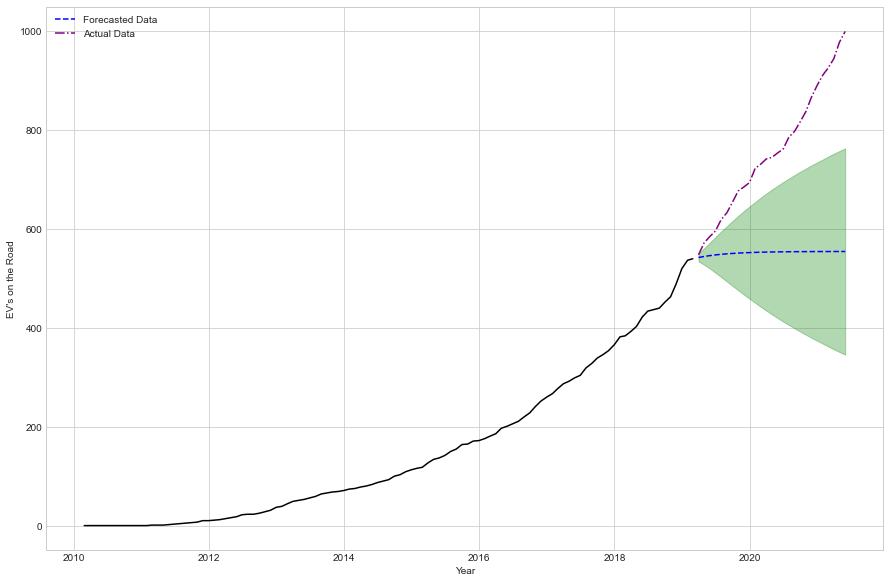

In [250]:
df_benton_forecast = get_forecast(model, train_benton, test_benton, plot=True)

### Future Predictions

#### Finding Best Parameters with Auto-Arima

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  136
Model:             SARIMAX(3, 1, 1)x(3, 0, [], 12)   Log Likelihood                -398.328
Date:                             Sat, 10 Jul 2021   AIC                            812.655
Time:                                     13:29:10   BIC                            835.898
Sample:                                          0   HQIC                           822.100
                                             - 136                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1900      0.087     13.728      0.000       1.020       1.360
ar.L2         -0.3825      0.125     -3.068      0.002      -0.627      -0.138
ar.L3          0.1903      0.070      2.729      0.006       0.054       0.327
ma.L1         -0.8689      0.053    -16.356      0.000      -0.973      -0.765
ar.S.L12      -0.0764      0.070     -1.092      0.275      -0.214       0.061
ar.S.L24       0.3557      0.107      3.315      0.001       0.145       0.566
ar.S.L36       0.2039      0.133      1.530      0.126      -0.057       0.465
sigma2        20.0448      2.016      9.943      0.000      16.094      23.996
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                48.22
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):              31.25   Skew:                             0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

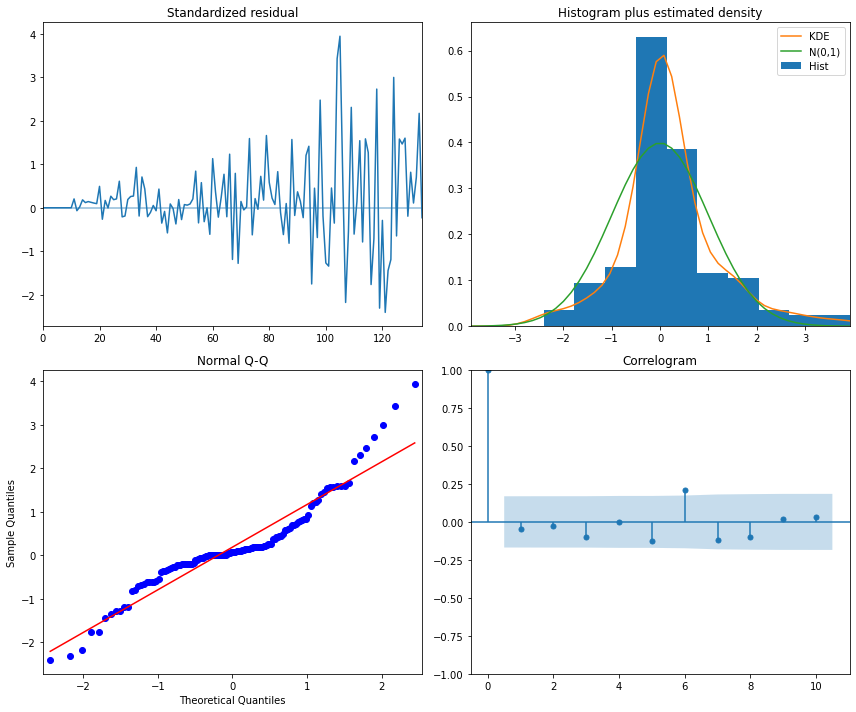

In [162]:
auto_model = pm.auto_arima(county_information['Benton']['df'], start_p=0, 
                           start_q=0,d=1, max_p=4, max_q=4, max_P=3,max_Q=3, 
                           start_P=0, start_Q=0, m=12, verbose=2)
evaluate_model(auto_model)

#### Model with Best Parameters

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                    EV's on the Road   No. Observations:                  136
Model:             SARIMAX(3, 1, 1)x(3, 0, [], 12)   Log Likelihood                -295.966
Date:                             Sat, 10 Jul 2021   AIC                            607.933
Time:                                     13:59:55   BIC                            628.447
Sample:                                 02-28-2010   HQIC                           616.225
                                      - 05-31-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3905      1.763      0.222      0.825      -3.064       3.845
ar.L2         -0.3117      0.554     -0.562      0.574      -1.398       0.774
ar.L3         -0.0196      0.543     -0.036      0.971      -1.084       1.045
ma.L1         -0.0940      1.779     -0.053      0.958      -3.581       3.393
ar.S.L12       0.1334      0.084      1.587      0.112      -0.031       0.298
ar.S.L24       0.8014      0.098      8.174      0.000       0.609       0.994
ar.S.L36       0.7055      0.186      3.796      0.000       0.341       1.070
sigma2        27.8821      4.135      6.744      0.000      19.779      35.986
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 3.20
Prob(Q):                              0.76   Prob(JB):                         0.20
Heteroskedasticity (H):               6.36   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

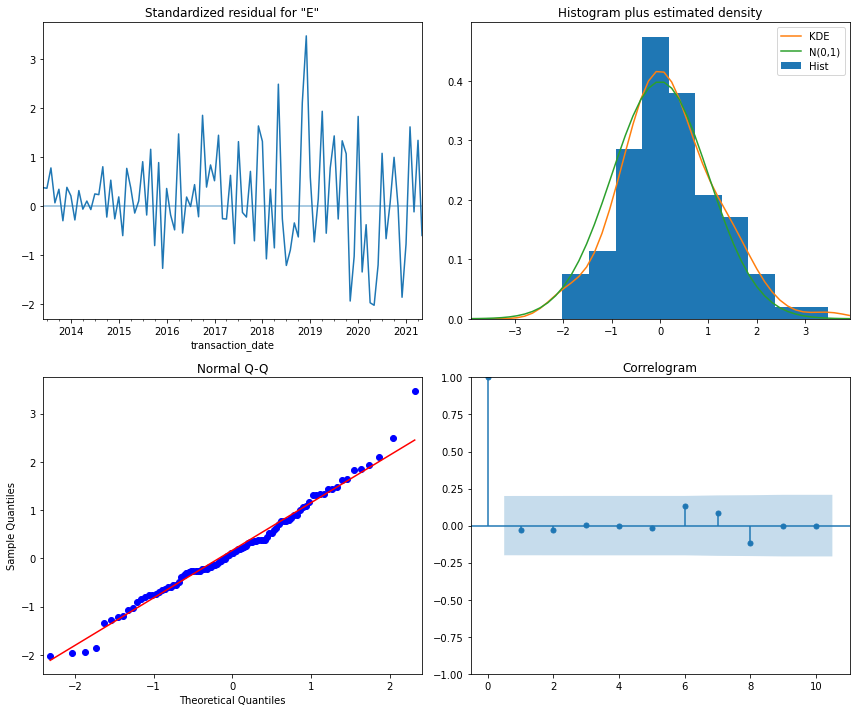

In [251]:
model = SARIMAX(county_information['Benton']['df'], order=(3,1,1), 
                seasonal_order=(3,0,[],12), enforce_invertibility=False, 
                enforce_stationarity=False).fit(maxiter=125)
evaluate_model(model)

#### Plotting & Saving Predictions

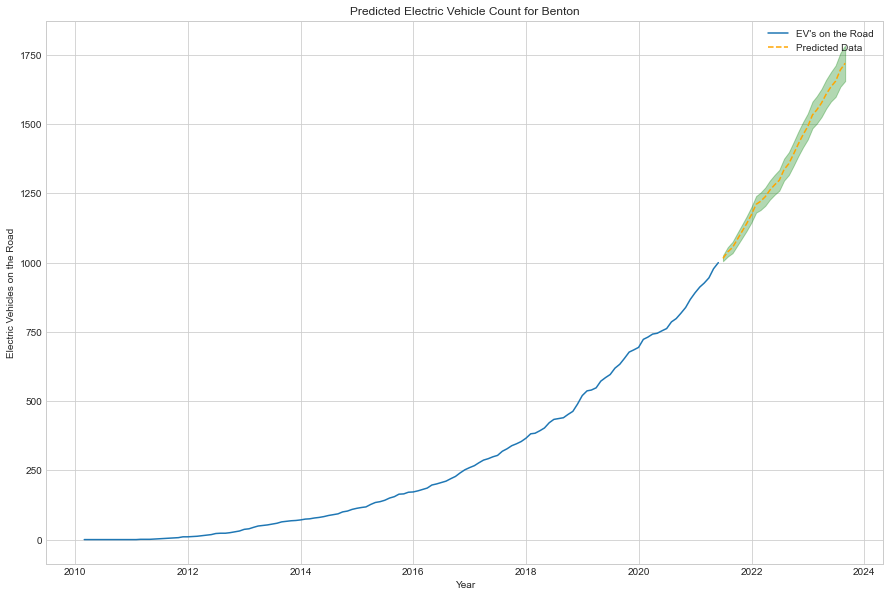

In [252]:
df_benton_preds = get_prediction(model, county_information['Benton']['df'], 
                               test_benton, 'Benton', plot=True)

In [253]:
county_information['Benton']['Predictions'] = df_benton_preds

## Island County

### Seasonality Check


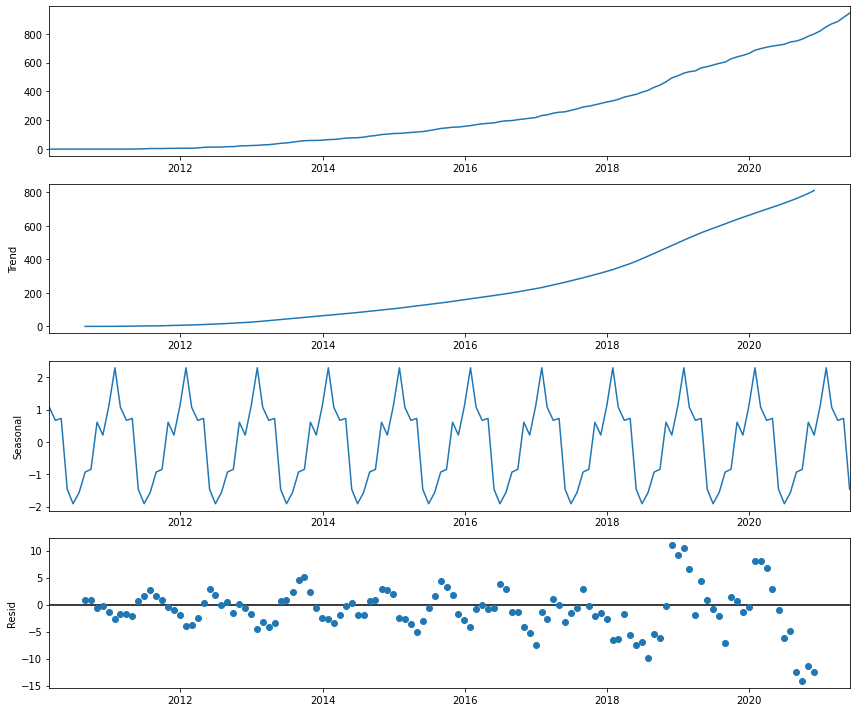

In [166]:
plt.rcParams['figure.figsize']=(12,10)
decomp = tsa.seasonal_decompose(county_information['Island']['df'])
decomp.plot();

The seasonal component of the time series for King county indicates only about a 200 car difference over the years which in the big picture is not much. Since we don't have a strong seasonality component, we will go ahead and use ARIMA models.

### train_test_split

In [167]:
train_island, test_island = train_test_split_ts(county_information['Island']['df'], 
                                            0.80, 0.20)

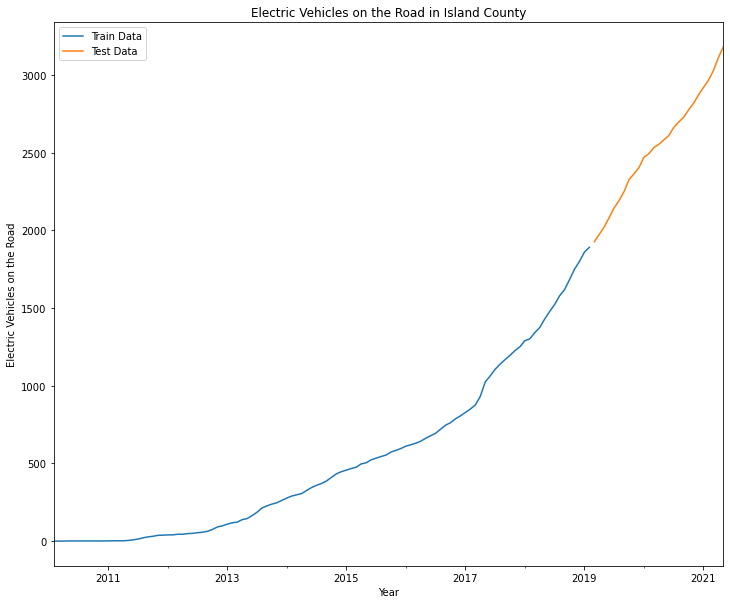

In [168]:
plot_train_test_split(train_thurston, test_thurston, 'Island')

### Tuning Hyperparameters with Auto-Arima

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  109
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                -265.444
Date:                             Sat, 10 Jul 2021   AIC                            538.889
Time:                                     13:29:33   BIC                            549.617
Sample:                                          0   HQIC                           543.239
                                             - 109                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9949      0.011     94.234      0.000       0.974       1.016
ma.L1         -0.6846      0.061    -11.249      0.000      -0.804      -0.565
ar.S.L12       0.1881      0.122      1.545      0.122      -0.051       0.427
sigma2         7.7138      0.783      9.847      0.000       6.178       9.249
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                28.13
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):              12.07   Skew:                             0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

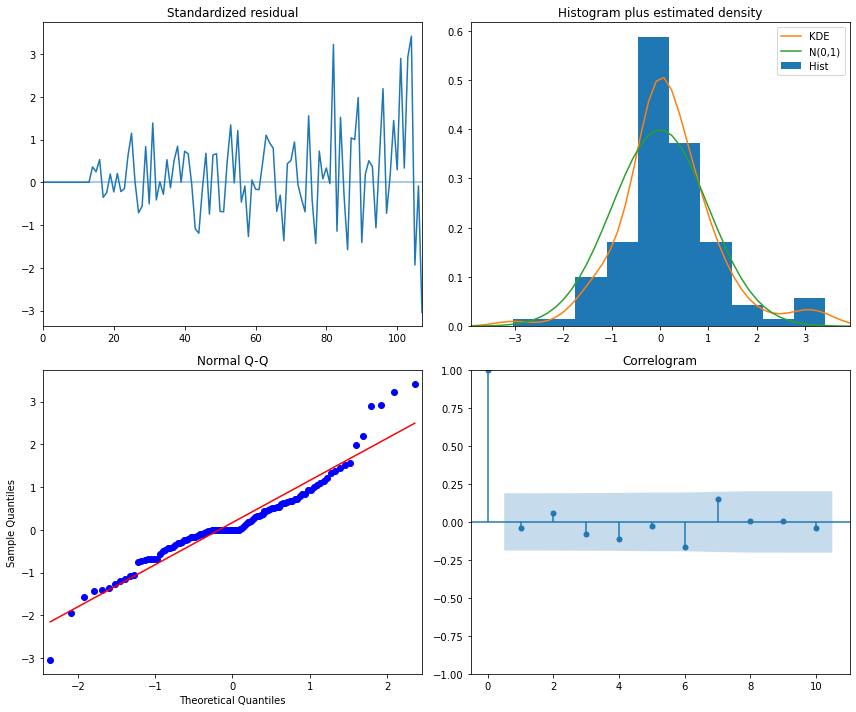

In [169]:
auto_model = pm.auto_arima(train_island, start_p=0, start_q=0, d=1, max_p=4, 
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0, 
                           m=12, verbose=2)
evaluate_model(auto_model)

### Model with Best Parameters

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                    EV's on the Road   No. Observations:                  109
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                -233.796
Date:                             Sat, 10 Jul 2021   AIC                            475.592
Time:                                     14:00:15   BIC                            485.808
Sample:                                 02-28-2010   HQIC                           479.720
                                      - 02-28-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0348      0.003    384.003      0.000       1.030       1.040
ma.L1         -0.9466      0.031    -30.441      0.000      -1.008      -0.886
ar.S.L12       0.2052      0.132      1.552      0.121      -0.054       0.464
sigma2         7.8485      0.819      9.581      0.000       6.243       9.454
===================================================================================
Ljung-Box (L1) (Q):                   0.50   Jarque-Bera (JB):                31.75
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               6.46   Skew:                             0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

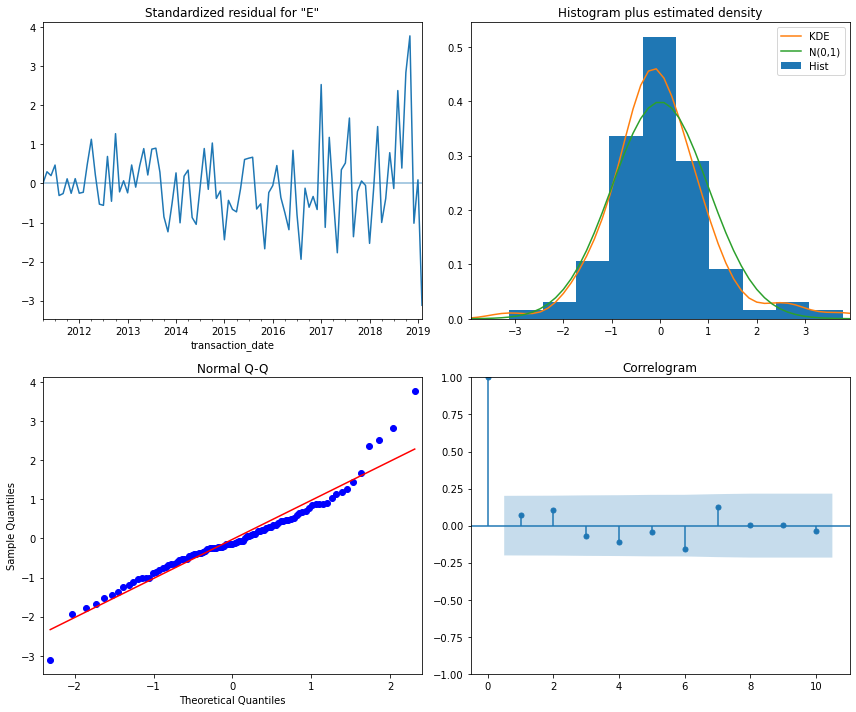

In [254]:
model = SARIMAX(train_island, order=(1,1,1), seasonal_order=(1,0,[],12), 
                enforce_invertibility=False, enforce_stationarity=False).fit()
evaluate_model(model)

### Validate Model with Forecasts for Test Data

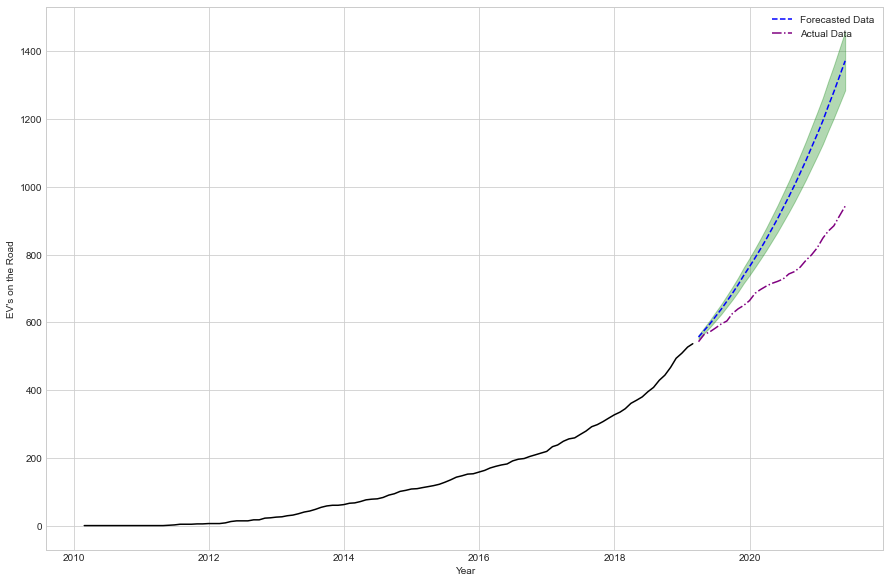

In [255]:
df_island_forecast = get_forecast(model, train_island, test_island, plot=True)

### Future Predictions

#### Finding Best Parameters with Auto-Arima

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  136
Model:               SARIMAX(3, 1, 0)   Log Likelihood                -369.454
Date:                Sat, 10 Jul 2021   AIC                            748.907
Time:                        13:29:39   BIC                            763.433
Sample:                             0   HQIC                           754.810
                                - 136                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3962      0.640      0.619      0.536      -0.858       1.651
ar.L1          0.3732      0.069      5.397      0.000       0.238       0.509
ar.L2          0.1992      0.075      2.674      0.008       0.053       0.345
ar.L3          0.3859      0.060      6.433      0.000       0.268       0.503
sigma2        13.7069      1.423      9.629      0.000      10.917      16.497
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                13.55
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              11.36   Skew:                             0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

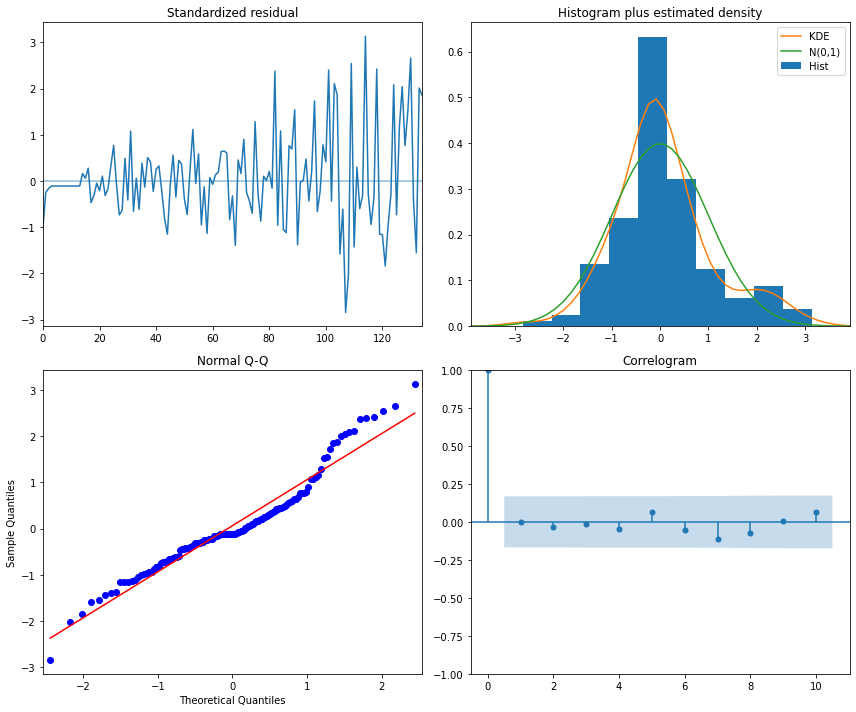

In [172]:
auto_model = pm.auto_arima(county_information['Island']['df'], start_p=0, 
                           start_q=0,d=1, max_p=4, max_q=4, max_P=3,max_Q=3, 
                           start_P=0, start_Q=0, m=12, verbose=2)
evaluate_model(auto_model)

#### Model with Best Parameters

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  136
Model:             SARIMAX(4, 1, 0)x(2, 0, 0, 12)   Log Likelihood                -303.230
Date:                            Sat, 10 Jul 2021   AIC                            620.461
Time:                                    14:00:36   BIC                            639.170
Sample:                                02-28-2010   HQIC                           628.045
                                     - 05-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3752      0.088      4.251      0.000       0.202       0.548
ar.L2          0.2236      0.087      2.573      0.010       0.053       0.394
ar.L3          0.4129      0.083      4.992      0.000       0.251       0.575
ar.L4          0.0134      0.083      0.163      0.871      -0.148       0.175
ar.S.L12       0.0255      0.094      0.271      0.786      -0.159       0.210
ar.S.L24       0.0014      0.106      0.013      0.989      -0.207       0.210
sigma2        16.9451      2.272      7.457      0.000      12.491      21.399
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.19
Prob(Q):                              0.93   Prob(JB):                         0.55
Heteroskedasticity (H):               7.85   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

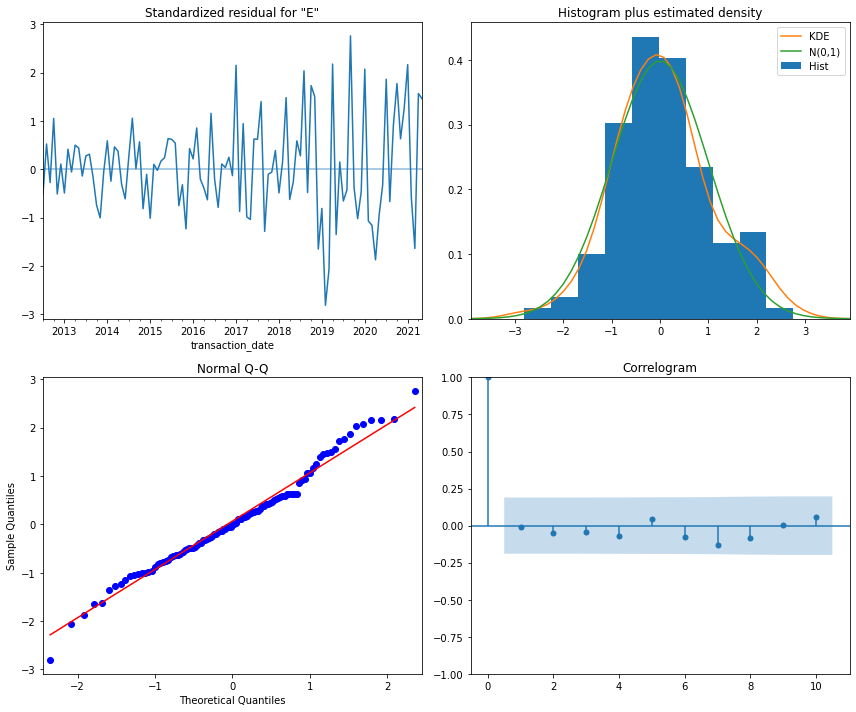

In [256]:
model = SARIMAX(county_information['Island']['df'], order=(4,1,0), 
                seasonal_order=(2,0,0,12), enforce_invertibility=False, 
                enforce_stationarity=False).fit()
evaluate_model(model)

#### Plotting & Saving Predictions

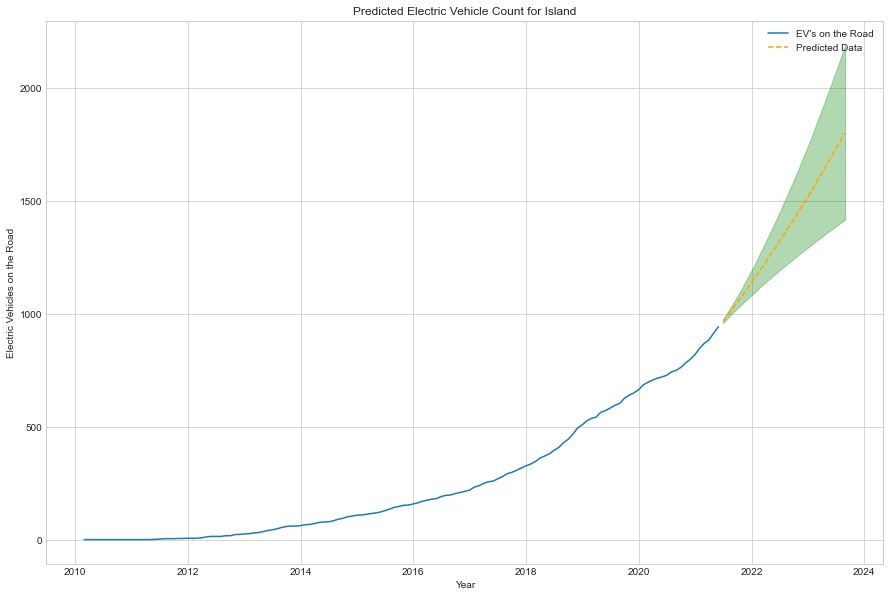

In [257]:
df_island_preds = get_prediction(model, county_information['Island']['df'], 
                               test_island, 'Island', plot=True)

In [258]:
county_information['Island']['Predictions'] = df_island_preds

# iNTERPRET

To be able to interpret our results correctly and find the counties with the most potential for investment, we need to take into account the existing charging infrastructure. As discussed in the introduction section, we will be gathering this information from the National Renewable Energy Laboratory's (NREL) API.

## Current Charger Infrastructure by County

### Accessing NREL API for Current Charger Information

In [259]:
#storing API keys in variables
nrel_keys = get_keys("/Users/berke/.secret/nrel_api_project_5.json")
api_key_nrel = nrel_keys['api_key']

Since we only want electric chargers in Washington State from all the fuel stations that is in this API, we will be limiting the results with the parameters shown below.

In [260]:
if run_api_calls == True:
    #Defining/initializing API request headers and parameters
    headers = {}
    params = {'api_key': api_key_nrel, 'fuel_type': 'ELEC', 'state': 'WA', 'limit': 'all'}
    df_chargers = None
    #Requesting data from API and parsing results to a dictionary
    r = requests.get(f'https://developer.nrel.gov/api/alt-fuel-stations/v1.json', 
                         headers=headers, params=params)
    df_chargers=pd.DataFrame.from_records(r.json()['fuel_stations'])

### Parsing results to a compressed .csv file

In [346]:
if run_api_calls == True:
    path = './data'
    output_file = os.path.join(path,'charging_infrastructure.csv.gz')
    df_chargers.to_csv(output_file, index=False, compression='gzip')

### Importing the data

In [340]:
df_chargers=pd.read_csv('./data/charging_infrastructure.csv.gz')
df_chargers.head()

access_code         access_days_time access_detail_code cards_accepted  \
0      public           24 hours daily                NaN            NaN   
1      public  24 hours daily; pay lot                NaN            NaN   
2      public           24 hours daily                NaN            NaN   
3      public           24 hours daily                NaN            NaN   
4      public           24 hours daily                NaN            NaN   

  date_last_confirmed expected_date fuel_type_code groups_with_access_code  \
0          2021-01-14           NaN           ELEC                  Public   
1          2020-07-13           NaN           ELEC                  Public   
2          2020-09-03           NaN           ELEC                  Public   
3          2021-02-15           NaN           ELEC                  Public   
4          2021-02-15           NaN           ELEC                  Public   

      id   open_date owner_type_code status_code  \
0  33351  2018-01-15              LG           E   
1  33717  2010-03-01               P           E   
2  35337  2009-08-15               P           E   
3  35620  2010-04-15               P           E   
4  35621  2010-04-15               P           E   

                                        station_name station_phone  \
0                  City of Lacey - City Hall Parking  360-491-3214   
1  Seattle-Tacoma International Airport - General...  206-787-5388   
2                             Haggen Food & Pharmacy  360-754-1428   
3                                        Avista Corp  509-489-0500   
4                                  Steam Plant Grill  509-777-3900   

             updated_at facility_type geocode_status   latitude   longitude  \
0  2021-03-11T23:22:17Z      MUNI_GOV          200-9  47.044011 -122.822404   
1  2021-03-11T23:22:17Z       AIRPORT          200-8  47.443377 -122.296229   
2  2021-03-11T23:22:17Z       GROCERY          200-8  47.035421 -122.938962   
3  2021-03-11T23:22:17Z   OFFICE_BLDG            GPS  47.673347 -117.388933   
4  2021-03-11T23:22:17Z    RESTAURANT          200-8  47.654998 -117.425025   

      city                         intersection_directions  plus4 state  \
0    Lacey           At 3rd Ave SE, next to police station    NaN    WA   
1  Seattle      5th floor parking garage; rows D, G, and I    NaN    WA   
2  Olympia  In front of the building on the left hand side    NaN    WA   
3  Spokane                                             NaN    NaN    WA   
4  Spokane                                             NaN    NaN    WA   

            street_address    zip country  bd_blends  cng_dispenser_num  \
0           420 College St  98503      US        NaN                NaN   
1      17801 Pacific Hwy S  98188      US        NaN                NaN   
2  1313 Cooper Point Rd SW  98502      US        NaN                NaN   
3       1411 E Mission Ave  99252      US        NaN                NaN   
4         159 S Lincoln St  99201      US        NaN                NaN   

   cng_fill_type_code  cng_psi  cng_renewable_source  cng_total_compression  \
0                 NaN      NaN                   NaN                    NaN   
1                 NaN      NaN                   NaN                    NaN   
2                 NaN      NaN                   NaN                    NaN   
3                 NaN      NaN                   NaN                    NaN   
4                 NaN      NaN                   NaN                    NaN   

   cng_total_storage  cng_vehicle_class  e85_blender_pump  \
0                NaN                NaN               NaN   
1                NaN                NaN               NaN   
2                NaN                NaN               NaN   
3                NaN                NaN               NaN   
4                NaN                NaN               NaN   

   e85_other_ethanol_blends    ev_connector_types  ev_dc_fast_num  \
0                       NaN             ['J1772']     

In [339]:
len(df_chargers)

1686

In our charger dataframe we have a total of 1686 charging stations. To be able to compare the existing infrastructure in each county, we need to figure out how many stations there are in each county. Unfortunately, the data that we have does not have county information but has the zipcode of each station. We can use these zipcodes to figure out in which county each of these stations are.

### Creating Zipcode Map to Find Counties

In [263]:
from uszipcode import SearchEngine

In [264]:
#Creating a dictionary that shows which county each zipcode is in
zipcodes_to_search = list(df_chargers['zip'].unique())
search = SearchEngine(simple_zipcode=True)
zip_map = {}
for zipcode in zipcodes_to_search:
    zip_info = search.by_zipcode(zipcode)
    zip_map[zipcode] = zip_info.values()[5].split()[0]

zip_map

{98503: 'Thurston',
 98188: 'King',
 98502: 'Thurston',
 99252: 'Spokane',
 99201: 'Spokane',
 98004: 'King',
 98506: 'Thurston',
 98505: 'Thurston',
 98501: 'Thurston',
 98027: 'King',
 98052: 'King',
 98011: 'King',
 98072: 'King',
 98002: 'King',
 98229: 'Whatcom',
 98312: 'Kitsap',
 98148: 'King',
 98026: 'Snohomish',
 98204: 'Snohomish',
 99301: 'Franklin',
 98362: 'Clallam',
 98371: 'Pierce',
 98058: 'King',
 99218: 'Spokane',
 99212: 'Spokane',
 98409: 'Pierce',
 98662: 'Clark',
 99362: 'Walla',
 98201: 'Snohomish',
 98104: 'King',
 98402: 'Pierce',
 98006: 'King',
 98007: 'King',
 98075: 'King',
 98032: 'King',
 98055: 'King',
 98056: 'King',
 98057: 'King',
 98134: 'King',
 98133: 'King',
 98124: 'King',
 98109: 'King',
 98103: 'King',
 98106: 'King',
 98901: 'Yakima',
 98272: 'Snohomish',
 98296: 'Snohomish',
 98283: 'Skagit',
 98277: 'Island',
 98684: 'Clark',
 98108: 'King',
 98801: 'Chelan',
 98273: 'Skagit',
 98101: 'King',
 98382: 'Clallam',
 98424: 'Pierce',
 98366: 'Ki

### Feature Engineering 'county' Column for df_chargers

In [344]:
#mapping county information for each charger based on zipcode
df_chargers['county'] = df_chargers['zip'].map(zip_map)
df_chargers['county'].head()

0    Thurston
1        King
2    Thurston
3     Spokane
4     Spokane
Name: county, dtype: object

### Saving Total Electrical Charger Count in Each County

Now that we know in which county each charging station is, we can see how many stations there are in each county and save this information.

In [266]:
df_charger_counts = pd.DataFrame(df_chargers['county'].value_counts())
df_charger_counts.reset_index(inplace=True)
df_charger_counts.columns=['County', 'Charger Count']
df_charger_counts

County  Charger Count
0        King            846
1      Pierce            123
2   Snohomish            104
3     Spokane             70
4       Clark             66
5    Thurston             62
6      Kitsap             61
7      Benton             61
8      Chelan             37
9     Whatcom             32
10     Skagit             28
11    Clallam             25
12     Yakima             22
13      Walla             17
14        San             14
15  Jefferson             10
16      Grant             10
17   Okanogan             10
18     Island             10
19   Kittitas             10
20    Whitman              9
21      Grays              8
22      Lewis              8
23    Cowlitz              8
24   Franklin              5
25    Douglas              5
26    Pacific              4
27      Mason              4
28      Adams              3
29   Columbia              3
30    Stevens              2
31   Skamania              2
32  Wahkiakum              2
33      Ferry              1
34       Pend              1
35  Klickitat              1
36    Lincoln              1
37     Asotin              1

## County Comparison

To be able to accurately compare each county, we need to put all of the information we have been gathering together in one dataframe. For each county, we will be looking at how many electric vehicles there are today (May 31, 2021) and in August 31, 2023 to find how many cars will be getting added over the next 2 years as well as what the ratios of these counts are to the number of existing charging stations.

In [268]:
comparison_df=pd.DataFrame()
i=0
for county in top_ten_counties:
    comparison_df.loc[i, 'County']=county
    
    comparison_df.loc[i, 'EV Count for 2021-05-31']= \
    county_information[county]['df']["EV's on the Road"][-1]
    
    comparison_df.loc[i, 'EV Prediction for 2023-08-31'] = \
    round(county_information[county]['Predictions']['Predictions'][-1],0)
    
    comparison_df.loc[i, 'Existing Charger Count'] = \
    int(df_charger_counts[df_charger_counts['County']==county]['Charger Count'])
    i+=1
#add airport data(?)

comparison_df['EVs Added (Today-2023)'] = \
comparison_df['EV Prediction for 2023-08-31'] - comparison_df['EV Count for 2021-05-31']

comparison_df['Chargers per EV'] = \
round(comparison_df['Existing Charger Count']/\
      comparison_df['EV Prediction for 2023-08-31'],3)

comparison_df['EVs per Charger'] = \
round(comparison_df['EV Prediction for 2023-08-31']/\
      comparison_df['Existing Charger Count'],0)

comparison_df.sort_values('EV Prediction for 2023-08-31', ascending=False, inplace=True)
comparison_df.set_index('County', inplace=True)
comparison_df

EV Count for 2021-05-31  EV Prediction for 2023-08-31  \
County                                                             
King                       51209.0                       75734.0   
Snohomish                   9423.0                       17282.0   
Pierce                      6652.0                       13012.0   
Clark                       5294.0                       11642.0   
Kitsap                      3097.0                        5654.0   
Thurston                    3181.0                        5299.0   
Spokane                     1973.0                        3480.0   
Whatcom                     2081.0                        3050.0   
Island                       943.0                        1804.0   
Benton                      1000.0                        1720.0   

           Existing Charger Count  EVs Added (Today-2023)  Chargers per EV  \
County                                                                       
King                        846.0                 24525.0            0.011   
Snohomish                   104.0                  7859.0            0.006   
Pierce                      123.0                  6360.0            0.009   
Clark                        66.0                  6348.0            0.006   
Kitsap                       61.0                  2557.0            0.011   
Thurston                     62.0                  2118.0            0.012   
Spokane                      70.0                  1507.0            0.020   
Whatcom                      32.0                   969.0            0.010   
Island                       10.0                   861.0            0.006   
Benton                       61.0                   720.0            0.035   

           EVs per Charger  
County                      
King                  90.0  
Snohomish            166.0  
Pierce               106.0  
Clark                176.0  
Kitsap                93.0  
Thurston              85.0  
Spokane               50.0  
Whatcom               95.0  
Island               180.0  
Benton                28.0

# CONCLUSIONS & RECOMMENDATIONS

Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***

# TESTING SANDBOX

In [195]:
def plot_acf_pacf(ts,figsize=(9,6),lags=52,suptitle=None,sup_y = 1.01):
    """Plot pacf and acf using statsmodels"""
    fig,axes=plt.subplots(nrows=2,figsize=figsize)
    
    tsa.graphics.plot_acf(ts,ax=axes[0],lags=lags);
    tsa.graphics.plot_pacf(ts,ax=axes[1],lags=lags);
    
    ## Add grid
    [ax.grid(axis='x',which='both') for ax in axes]
    
    if suptitle is not None:
        fig.suptitle(suptitle,y=sup_y,fontweight='bold',fontsize=15)
        
    fig.tight_layout()
    return fig,ax